In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

We consider missiles with only 1 stage

In [6]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 7000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

# 0. Only one param - m1

In [7]:
m1_param_1 = 'fuelmass'
m1_domain_param_1 = basic_param_spaces[m1_param_1] # [500, 6000] # [5000,15000]

m1_space = ParameterSpace(
          [ContinuousParameter(m1_param_1, *m1_domain_param_1), 
          ])

custom_param_names = [m1_param_1]

In [8]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



New simulation 

fuelmass: 5296.932436961693


Stage 1 burnout
Velocity (km/s):  2.0012551500506564
Angle (deg h):  43.64719276266897
Range (km):  42.195362198063236
Time (sec):  130.49999999999687
Final results: 
Range (km):  526.091996366165
Apogee (km):  166.67822087281195
Time to target (sec):  474.0000000000393




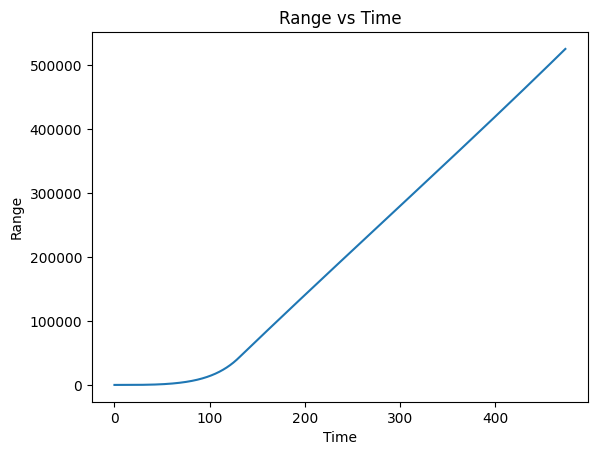

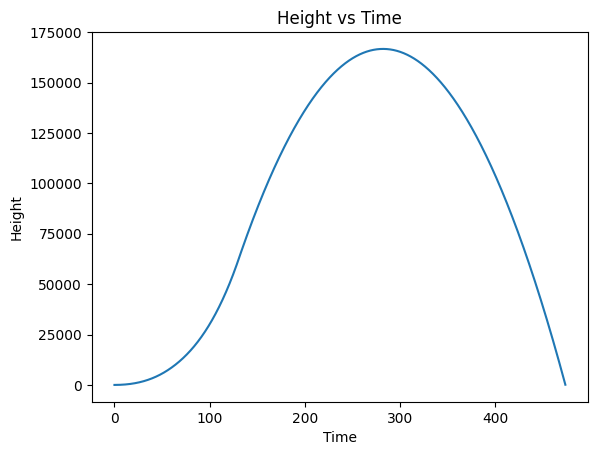

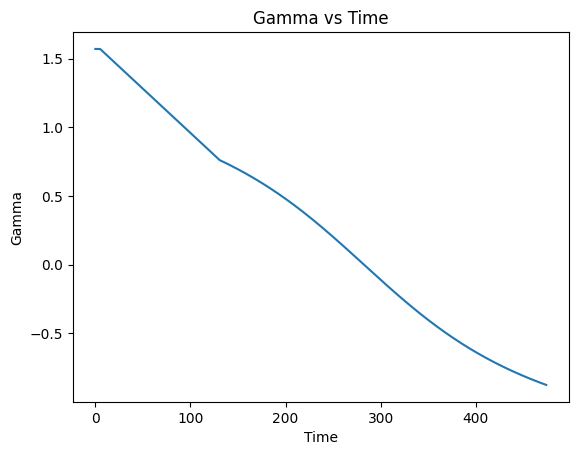

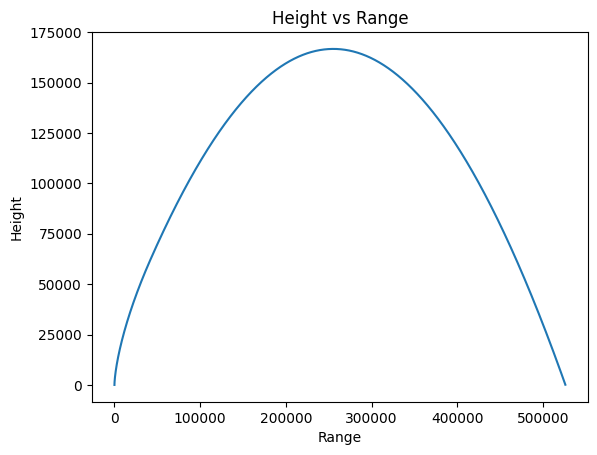

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4648.890104101334


Stage 1 burnout
Velocity (km/s):  1.8978811613432207
Angle (deg h):  43.6657620187178
Range (km):  36.76995909749365
Time (sec):  114.49999999999777
Final results: 
Range (km):  469.8147164930727
Apogee (km):  148.75567441424124
Time to target (sec):  437.80000000003105




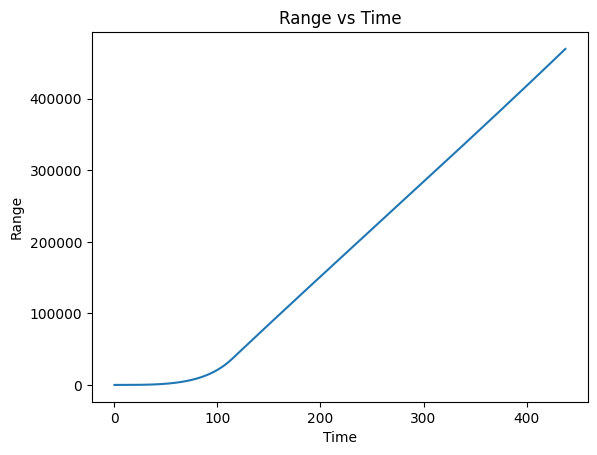

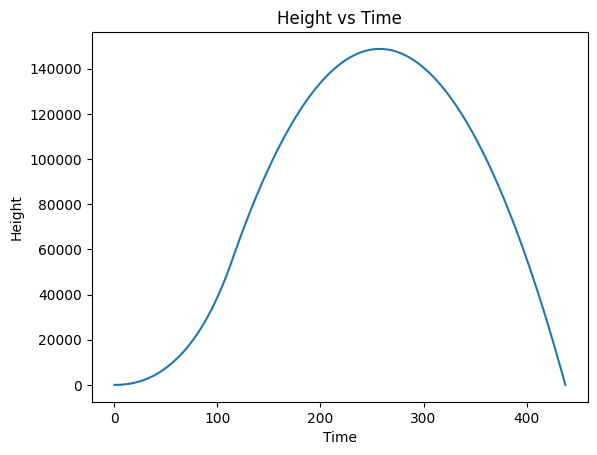

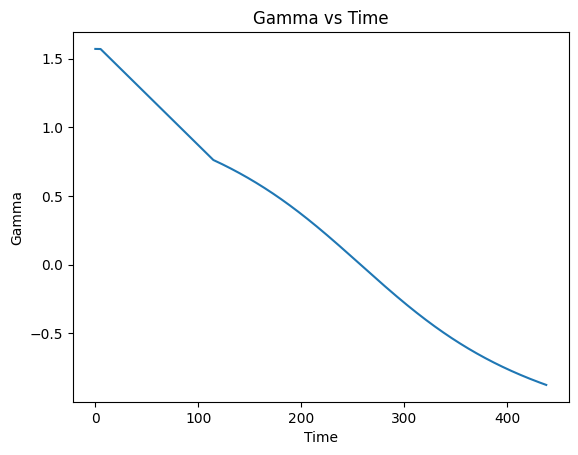

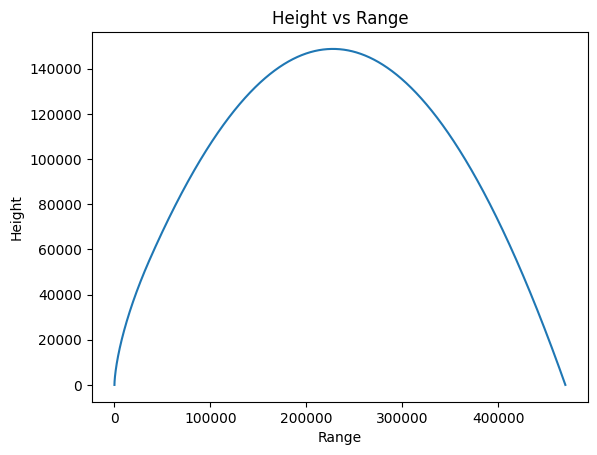

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 1877.3389894264665


Stage 1 burnout
Velocity (km/s):  1.0866526150625575
Angle (deg h):  43.64885410449177
Range (km):  10.472466015405928
Time (sec):  46.30000000000039
Final results: 
Range (km):  148.86698198931086
Apogee (km):  47.22482381643256
Time to target (sec):  223.69999999999158




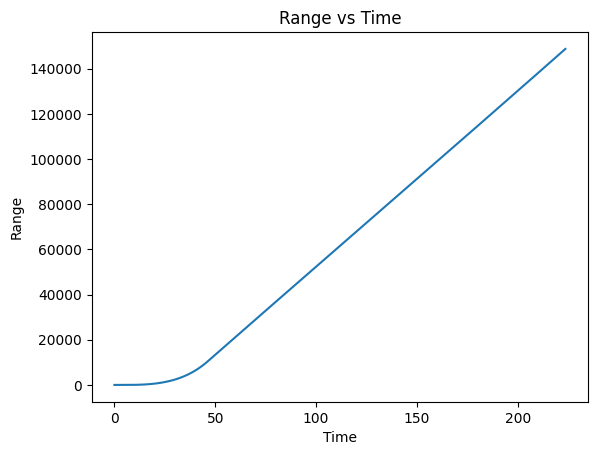

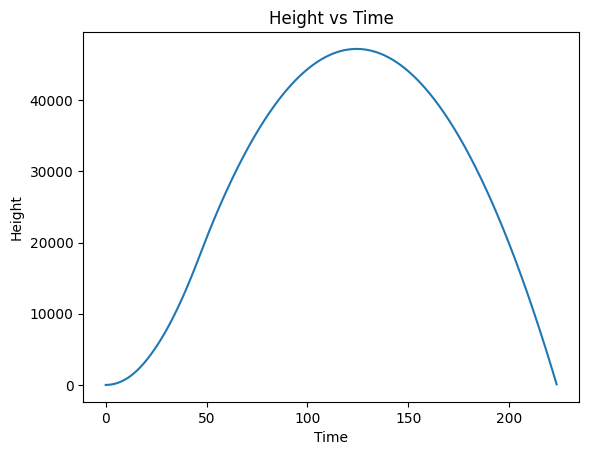

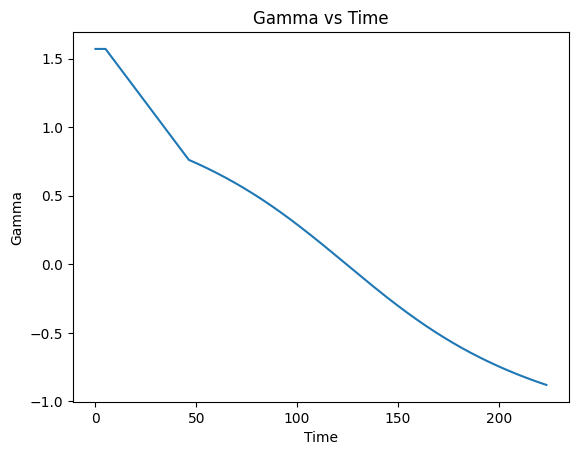

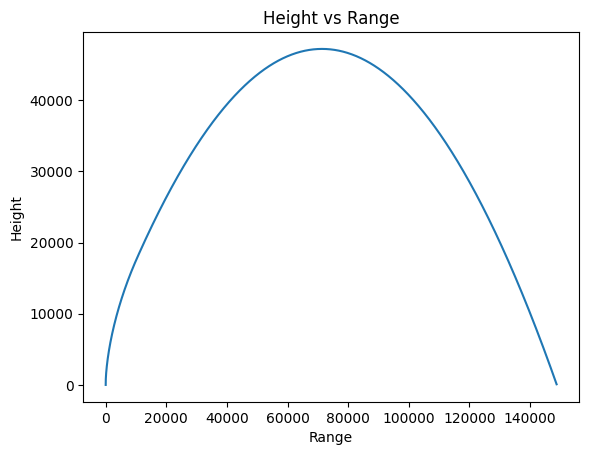

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 6661.992853126185


Stage 1 burnout
Velocity (km/s):  2.1382685000920745
Angle (deg h):  43.64997584241883
Range (km):  51.05949647072676
Time (sec):  164.09999999999496
Final results: 
Range (km):  607.2823784150386
Apogee (km):  192.2554315908972
Time to target (sec):  535.2000000000531




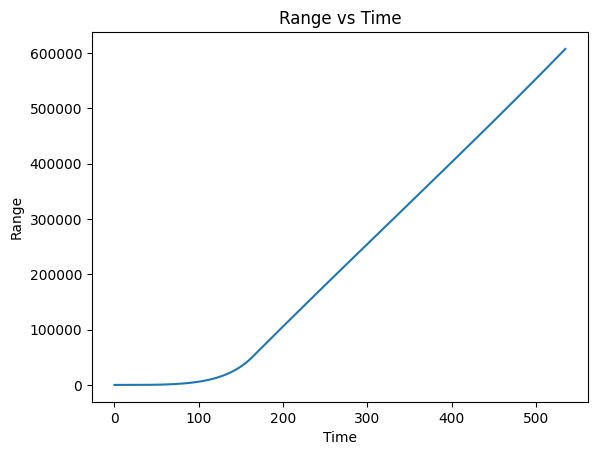

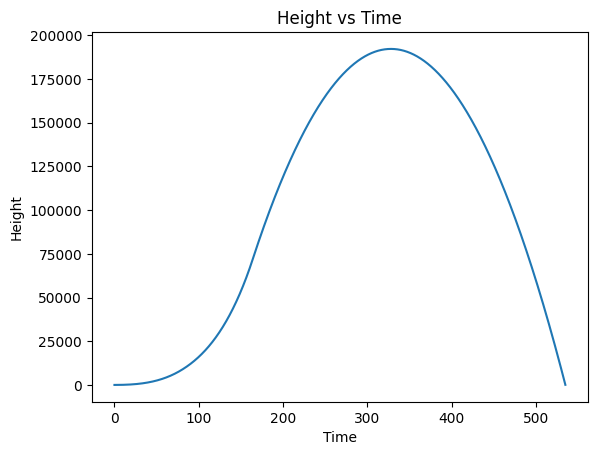

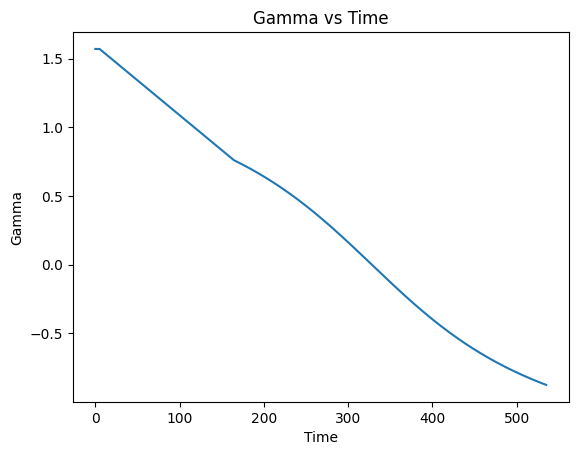

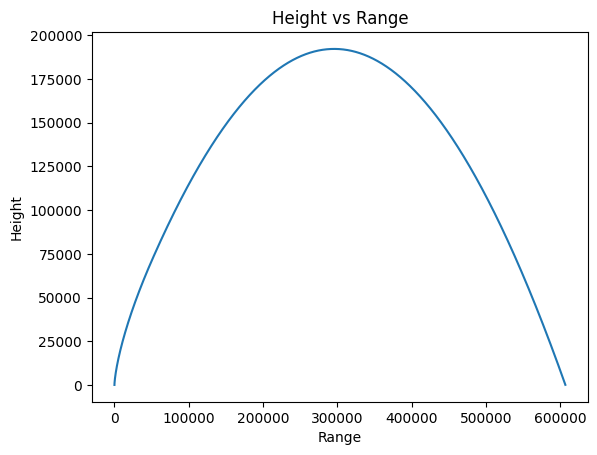

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 3268.5602898432417


Stage 1 burnout
Velocity (km/s):  1.5825707009488603
Angle (deg h):  43.68205037464285
Range (km):  23.728740971831193
Time (sec):  80.4999999999997
Final results: 
Range (km):  320.819048853411
Apogee (km):  101.29762588432382
Time to target (sec):  344.50000000000983




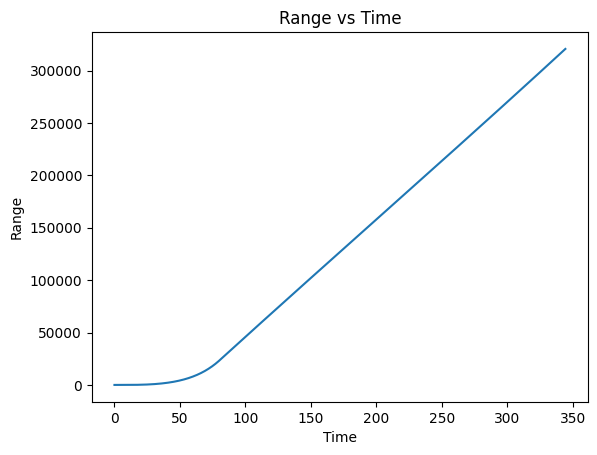

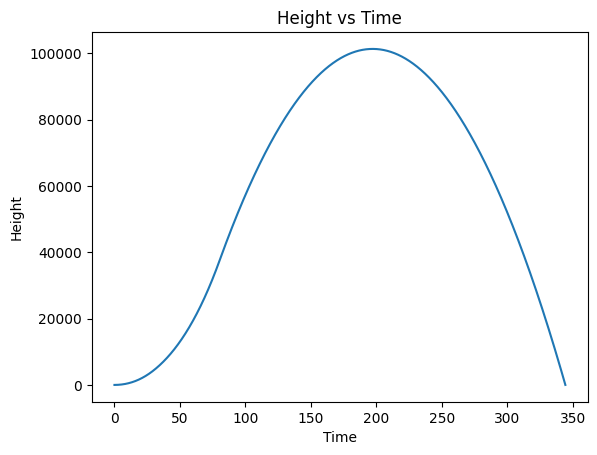

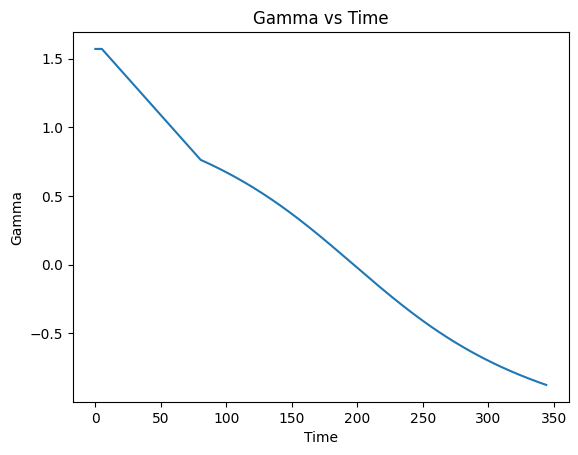

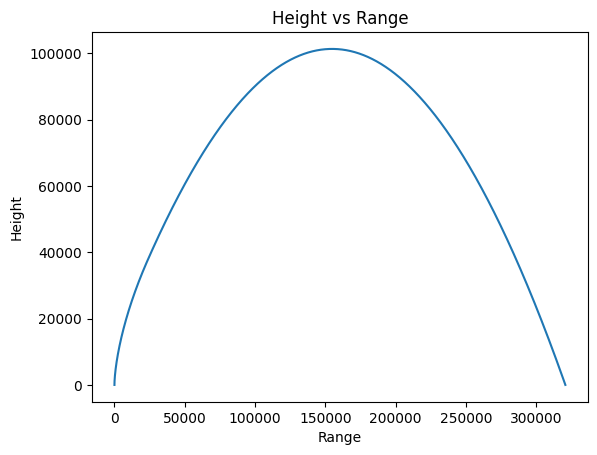

Data written to 'results/results_4.txt'


In [9]:
# Get true points (to build model)
wirte_output_txt = True

m1_design = RandomDesign(m1_space)
m1_x = m1_design.get_samples(5)
m1_y = run_missile_sim(m1_x)

In [12]:
# Build model
m1_var_kernel = (100)**2 
m1_lengthscale = 1 # 1
m1_var_linear_kernel = (100)**2 
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m1_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=1, lengthscale=100, variance =var_kernel )  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
m1_kern = GPy.kern.RBF(input_dim=1, lengthscale=m1_lengthscale ) + \
    GPy.kern.Linear(input_dim=1)

m1_model_gpy = GPRegression(m1_x,m1_y, kernel=m1_kern)
m1_model_gpy.kern.variance =  m1_var_kernel 
m1_model_gpy.likelihood.variance.fix(m1_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m1_model_gpy)



In [13]:
# Fit emulator
m1_model_emukit = GPyModelWrapper(m1_model_gpy)
m1_model_emukit.optimize() # Optimize model hyperparameters



In [14]:
display(m1_model_gpy)

In [15]:
# Get true points corresponding to param_1_x_plot (for plot)
wirte_output_txt = False

nr_points_plot = 301
m1_param_1_x_plot = np.linspace(m1_space.parameters[0].min, m1_space.parameters[0].max, nr_points_plot)[:, None]
m1_param_1_y_plot = run_missile_sim(m1_param_1_x_plot)




New simulation 

fuelmass: 500.0


Stage 1 burnout
Velocity (km/s):  0.4265056287972526
Angle (deg h):  43.732284489193205
Range (km):  0.9440400159604505
Time (sec):  12.299999999999974
Final results: 
Range (km):  21.661219962904816
Apogee (km):  6.737492515662497
Time to target (sec):  79.59999999999975



New simulation 

fuelmass: 521.6666666666666


Stage 1 burnout
Velocity (km/s):  0.4416434717954563
Angle (deg h):  43.83287275857593
Range (km):  1.057916877925568
Time (sec):  12.899999999999972
Final results: 
Range (km):  23.299268434743006
Apogee (km):  7.265468825488651
Time to target (sec):  82.79999999999957



New simulation 

fuelmass: 543.3333333333334


Stage 1 burnout
Velocity (km/s):  0.4531012653971142
Angle (deg h):  44.00365733623127
Range (km):  1.1426446275193176
Time (sec):  13.39999999999997
Final results: 
Range (km):  24.577426049485343
Apogee (km):  7.711014064268049
Time to target (sec):  85.39999999999942



New simulation 

fuelmass: 565.0


Stage 1 bur

Final results: 
Range (km):  72.71690788575486
Apogee (km):  23.045208837630337
Time to target (sec):  151.79999999999566



New simulation 

fuelmass: 1171.6666666666667


Stage 1 burnout
Velocity (km/s):  0.7776703903147185
Angle (deg h):  43.70228822687215
Range (km):  4.833532583038125
Time (sec):  28.900000000000144
Final results: 
Range (km):  75.11009405942215
Apogee (km):  23.815003362564784
Time to target (sec):  154.39999999999552



New simulation 

fuelmass: 1193.3333333333335


Stage 1 burnout
Velocity (km/s):  0.7864751328493715
Angle (deg h):  43.7644578928051
Range (km):  4.967347913653514
Time (sec):  29.40000000000015
Final results: 
Range (km):  76.86367516851995
Apogee (km):  24.42587373484769
Time to target (sec):  156.4999999999954



New simulation 

fuelmass: 1215.0


Stage 1 burnout
Velocity (km/s):  0.7988686883595202
Angle (deg h):  43.638062821288294
Range (km):  5.159814800704635
Time (sec):  30.00000000000016
Final results: 
Range (km):  79.37108415381337


Stage 1 burnout
Velocity (km/s):  1.0817240527618768
Angle (deg h):  43.644565960568734
Range (km):  10.367458459133884
Time (sec):  46.000000000000384
Final results: 
Range (km):  147.53325193300196
Apogee (km):  46.784617546744556
Time to target (sec):  222.59999999999164



New simulation 

fuelmass: 1886.6666666666667


Stage 1 burnout
Velocity (km/s):  1.0892716374493936
Angle (deg h):  43.68197791941445
Range (km):  10.530926851738005
Time (sec):  46.50000000000039
Final results: 
Range (km):  149.64522462153005
Apogee (km):  47.50972628209598
Time to target (sec):  224.49999999999153



New simulation 

fuelmass: 1908.3333333333335


Stage 1 burnout
Velocity (km/s):  1.0967768406404779
Angle (deg h):  43.71844062173274
Range (km):  10.694881068185232
Time (sec):  47.0000000000004
Final results: 
Range (km):  151.7665640367034
Apogee (km):  48.236189417639004
Time to target (sec):  226.39999999999142



New simulation 

fuelmass: 1930.0


Stage 1 burnout
Velocity (km/s):  1.10836

Final results: 
Range (km):  240.07539505268537
Apogee (km):  75.8493751252011
Time to target (sec):  291.39999999999776



New simulation 

fuelmass: 2645.0


Stage 1 burnout
Velocity (km/s):  1.3852296170552467
Angle (deg h):  43.64954242112931
Range (km):  17.63685518150972
Time (sec):  65.20000000000057
Final results: 
Range (km):  243.84426786859245
Apogee (km):  76.99095877271084
Time to target (sec):  293.7999999999983



New simulation 

fuelmass: 2666.666666666667


Stage 1 burnout
Velocity (km/s):  1.3913467599440688
Angle (deg h):  43.67508867877185
Range (km):  17.814816298636455
Time (sec):  65.70000000000054
Final results: 
Range (km):  246.08784653453588
Apogee (km):  77.75787015899104
Time to target (sec):  295.4999999999987



New simulation 

fuelmass: 2688.3333333333335


Stage 1 burnout
Velocity (km/s):  1.3974081719995268
Angle (deg h):  43.65241109734481
Range (km):  17.99275895284626
Time (sec):  66.20000000000051
Final results: 
Range (km):  248.31961218343858
A

Final results: 
Range (km):  321.0764735529113
Apogee (km):  101.33093579433285
Time to target (sec):  344.60000000000986



New simulation 

fuelmass: 3295.0


Stage 1 burnout
Velocity (km/s):  1.5924665491197987
Angle (deg h):  43.65196169425391
Range (km):  24.045887055208244
Time (sec):  81.19999999999966
Final results: 
Range (km):  324.8959017876049
Apogee (km):  102.48589207367766
Time to target (sec):  346.80000000001036



New simulation 

fuelmass: 3316.666666666667


Stage 1 burnout
Velocity (km/s):  1.5970201664260437
Angle (deg h):  43.67215513945864
Range (km):  24.221421763017098
Time (sec):  81.69999999999963
Final results: 
Range (km):  326.8163986261255
Apogee (km):  103.18731203334593
Time to target (sec):  348.2000000000107



New simulation 

fuelmass: 3338.3333333333335


Stage 1 burnout
Velocity (km/s):  1.6015262317496535
Angle (deg h):  43.656107657600266
Range (km):  24.39658659898041
Time (sec):  82.1999999999996
Final results: 
Range (km):  328.8084876055538

Final results: 
Range (km):  399.3934735089142
Apogee (km):  126.16716173159215
Time to target (sec):  393.500000000021



New simulation 

fuelmass: 3966.666666666667


Stage 1 burnout
Velocity (km/s):  1.761118303270128
Angle (deg h):  43.67016987435943
Range (km):  30.529881831784014
Time (sec):  97.69999999999872
Final results: 
Range (km):  400.97906456800104
Apogee (km):  126.7700294617183
Time to target (sec):  394.70000000002125



New simulation 

fuelmass: 3988.3333333333335


Stage 1 burnout
Velocity (km/s):  1.7643719817477028
Angle (deg h):  43.65853469190714
Range (km):  30.692883325346997
Time (sec):  98.1999999999987
Final results: 
Range (km):  402.61859423414046
Apogee (km):  127.28857141670919
Time to target (sec):  395.8000000000215



New simulation 

fuelmass: 4010.0


Stage 1 burnout
Velocity (km/s):  1.7724524382487614
Angle (deg h):  43.65359586078074
Range (km):  30.982417525651318
Time (sec):  98.79999999999866
Final results: 
Range (km):  406.3273284453291
A

Final results: 
Range (km):  465.40655192495603
Apogee (km):  147.27302518718702
Time to target (sec):  434.80000000003037



New simulation 

fuelmass: 4616.666666666667


Stage 1 burnout
Velocity (km/s):  1.891841066189895
Angle (deg h):  43.6687046358543
Range (km):  36.47867077331507
Time (sec):  113.69999999999781
Final results: 
Range (km):  466.58989880324503
Apogee (km):  147.75954165407995
Time to target (sec):  435.8000000000306



New simulation 

fuelmass: 4638.333333333334


Stage 1 burnout
Velocity (km/s):  1.898978940305747
Angle (deg h):  43.64040125477374
Range (km):  36.759228909551325
Time (sec):  114.29999999999778
Final results: 
Range (km):  470.2358199278562
Apogee (km):  148.7404982440433
Time to target (sec):  437.600000000031



New simulation 

fuelmass: 4660.0


Stage 1 burnout
Velocity (km/s):  1.901139270987802
Angle (deg h):  43.65455765008606
Range (km):  36.90303830858904
Time (sec):  114.79999999999775
Final results: 
Range (km):  471.4073439672777
Apo

Final results: 
Range (km):  516.3503478646778
Apogee (km):  163.61671227212386
Time to target (sec):  467.70000000003785



New simulation 

fuelmass: 5201.666666666667


Stage 1 burnout
Velocity (km/s):  1.9852355532702903
Angle (deg h):  43.66764607342738
Range (km):  41.36962637466163
Time (sec):  128.099999999997
Final results: 
Range (km):  517.2491822996838
Apogee (km):  163.98851758599056
Time to target (sec):  468.60000000003805



New simulation 

fuelmass: 5223.333333333334


Stage 1 burnout
Velocity (km/s):  1.9916250275603962
Angle (deg h):  43.64264481196987
Range (km):  41.635869723137866
Time (sec):  128.69999999999698
Final results: 
Range (km):  520.7172438729353
Apogee (km):  164.90162697236002
Time to target (sec):  470.30000000003844



New simulation 

fuelmass: 5245.0


Stage 1 burnout
Velocity (km/s):  1.9930020795793326
Angle (deg h):  43.655145639927404
Range (km):  41.75881476434996
Time (sec):  129.19999999999695
Final results: 
Range (km):  521.461325386245

Final results: 
Range (km):  566.7668860531446
Apogee (km):  179.57994735781102
Time to target (sec):  502.3000000000457



New simulation 

fuelmass: 5895.0


Stage 1 burnout
Velocity (km/s):  2.0720591685623315
Angle (deg h):  43.65557663815925
Range (km):  46.49498499428736
Time (sec):  145.19999999999604
Final results: 
Range (km):  567.1872186590265
Apogee (km):  179.80873315860248
Time to target (sec):  503.0000000000459



New simulation 

fuelmass: 5916.666666666667


Stage 1 burnout
Velocity (km/s):  2.0726256685506717
Angle (deg h):  43.651505274387574
Range (km):  46.59001362215356
Time (sec):  145.699999999996
Final results: 
Range (km):  567.5923706190404
Apogee (km):  179.97188968095014
Time to target (sec):  503.600000000046



New simulation 

fuelmass: 5938.333333333334


Stage 1 burnout
Velocity (km/s):  2.078214437815824
Angle (deg h):  43.644673037041215
Range (km):  46.832690370957984
Time (sec):  146.29999999999598
Final results: 
Range (km):  570.679856853532
Apo

Stage 1 burnout
Velocity (km/s):  2.1293047718555784
Angle (deg h):  43.645902268831314
Range (km):  50.352101269960976
Time (sec):  160.69999999999516
Final results: 
Range (km):  601.5977106408635
Apogee (km):  190.51667025352117
Time to target (sec):  529.9000000000519



New simulation 

fuelmass: 6545.0


Stage 1 burnout
Velocity (km/s):  2.1291734980097847
Angle (deg h):  43.655820761297875
Range (km):  50.41772756063109
Time (sec):  161.19999999999513
Final results: 
Range (km):  601.6835398937153
Apogee (km):  190.60353767354403
Time to target (sec):  530.5000000000521



New simulation 

fuelmass: 6566.666666666667


Stage 1 burnout
Velocity (km/s):  2.129026350157793
Angle (deg h):  43.65341905509799
Range (km):  50.482377334874705
Time (sec):  161.6999999999951
Final results: 
Range (km):  601.7323448542923
Apogee (km):  190.63386626507872
Time to target (sec):  531.0000000000522



New simulation 

fuelmass: 6588.333333333334


Stage 1 burnout
Velocity (km/s):  2.1339341470

In [16]:
# Get model prediction on param_1_x_plot
m1_mu_plot, m1_var_plot = m1_model_emukit.predict(m1_param_1_x_plot)



In [17]:
# Plot
def helper_plot_emulator_errorbars(x_plot, y_plot, mu_plot, var_plot, model_emukit):
    """Helper function for plotting the emulator fit."""
    ax.plot(model_emukit.X[:, 0], model_emukit.Y, 'ro', markersize=10, label='observations')
    ax.plot(x_plot[:, 0], mu_plot, 'C0', label='model', linewidth=3)
    ax.plot(x_plot[:, 0], y_plot, 'k', label='target function', linewidth=2)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel(custom_param_names[0])
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    #ax.set_xlim(-0.01, 1)
    #ax.set_ylim([-20, 20])
    

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m1_param_1_x_plot, y_plot=m1_param_1_y_plot, 
                               mu_plot=m1_mu_plot, var_plot=m1_var_plot, 
                               model_emukit=m1_model_emukit)

# 1. Two params

In [21]:
m2_param_1 = 'fuelmass'
m2_domain_param_1 = basic_param_spaces[m2_param_1] # [500, 6000] # [5000,15000]
m2_param_2 = 'Isp0'
m2_domain_param_2 = basic_param_spaces[m2_param_2] # [200, 300] # [224, 228]

m2_space = ParameterSpace(
          [ContinuousParameter(m2_param_1, *m2_domain_param_1), 
           ContinuousParameter(m2_param_2, *m2_domain_param_2),
#            ContinuousParameter(param_3, *domain_param_3),
#            ContinuousParameter(param_4, *domain_param_4)
          ])

custom_param_names = [m2_param_1, m2_param_2]

In [22]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


## 1. Experimental design

Experimental design addresses the problem of how to collect data points (experiments) to better control certain sources of variance of a model.

In experimental design the goal is to decide at which locations of the input space we should evaluate a function of interest. In some contexts it is also known as active learning, for instance in image classification problems in which more labels need to be collected.

The are two main ways of doing experimental design.

1. Model-free designs: These designs define rules to spread the experiments as much as possible across the input domain. Drawing points at random or in a grid are the most naive way of doing so. Other more elaborate approaches are low discrepancy sequences that try to induce some negative correlation in the selected points to spread them evenly. Some examples are Latin hyper-cube sampling and Sobol sequences.

2. Model-based designs: In these designs a feedback loop is used between some ‘optimal’ statistical criterion to collect points and a model. In general, the criterion aims to reduce some type of variance in the model. The type of optimality refers to which type of uncertainty that is reduced. For instance, a D-optimal design aims to maximize the differential Shannon information content of the model parameter estimates; an I-optimal design seeks to minimize the average prediction variance over the entire design space. 

Gaussian processes have a long tradition of being the ‘model of choice’ for designing experiments.

### Use model-free experimental design to start
 (RandomDesign or Latin Design)


New simulation 

fuelmass: 1919.938001945772
Isp0: 522.619398522858


Stage 1 burnout
Velocity (km/s):  2.971922355518926
Angle (deg h):  43.65430963752218
Range (km):  64.42870309684778
Time (sec):  109.39999999999806
Final results: 
Range (km):  1150.0145409093693
Apogee (km):  352.1174815029099
Time to target (sec):  645.8000000000783




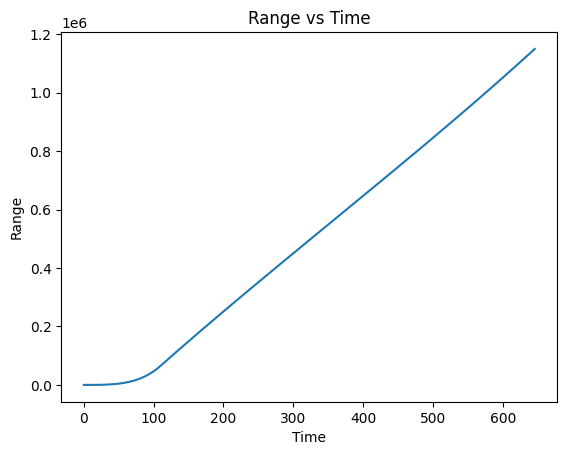

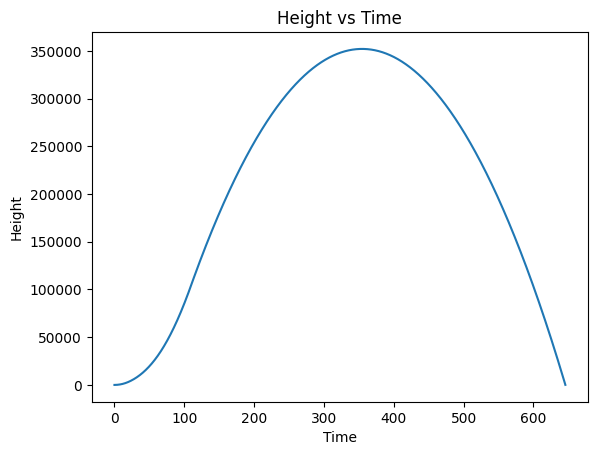

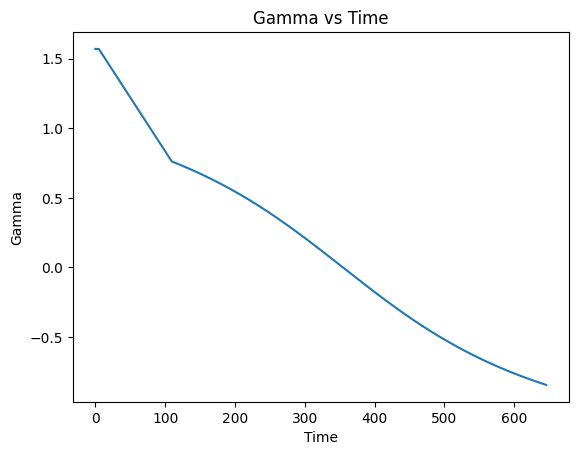

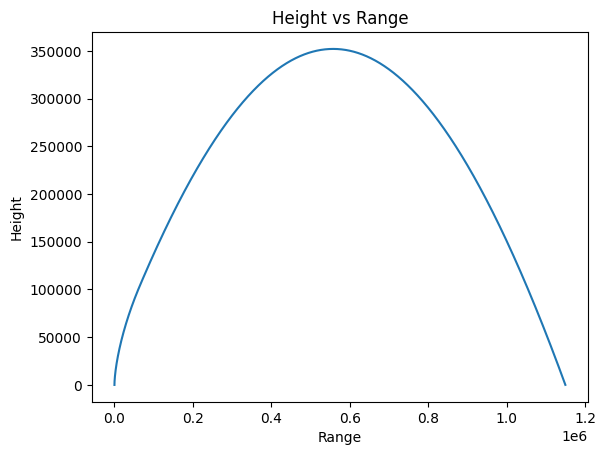

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 574.7450615933641
Isp0: 666.6310034111528


Stage 1 burnout
Velocity (km/s):  1.315353530320039
Angle (deg h):  43.68210789323982
Range (km):  12.269679138663765
Time (sec):  41.800000000000324
Final results: 
Range (km):  212.53579225138887
Apogee (km):  65.39341655074116
Time to target (sec):  254.6999999999898




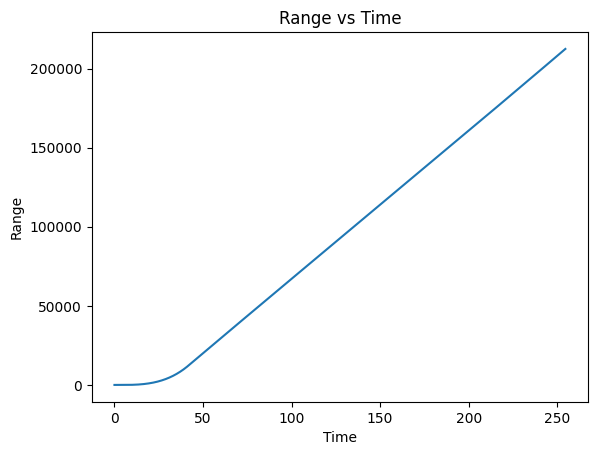

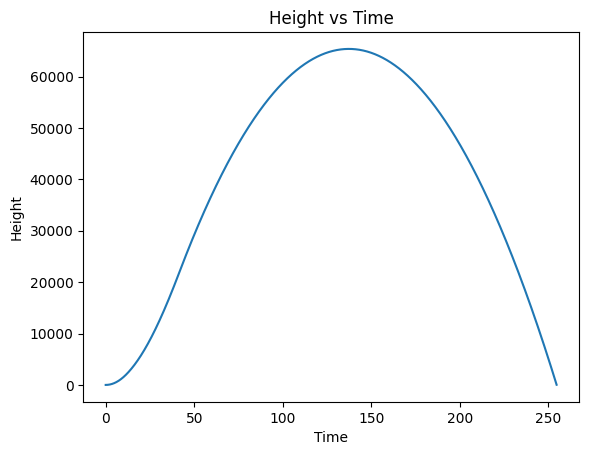

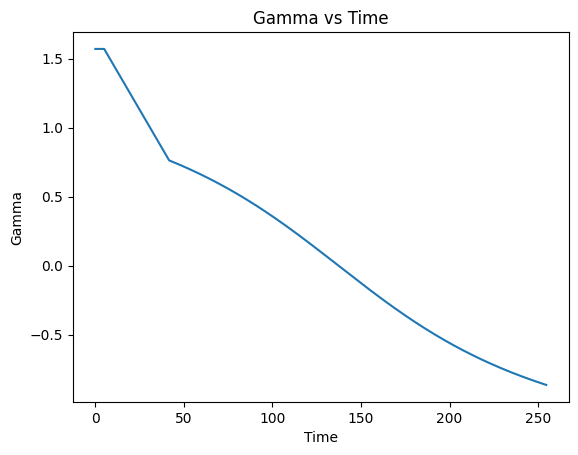

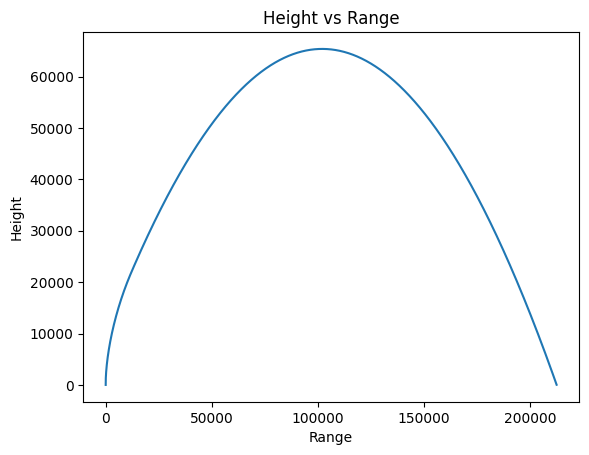

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 1858.2091313812318
Isp0: 499.2674320261289


Stage 1 burnout
Velocity (km/s):  2.7356429563659637
Angle (deg h):  43.68150438591866
Range (km):  55.21498631770176
Time (sec):  101.09999999999853
Final results: 
Range (km):  964.4095499197628
Apogee (km):  295.30177886064985
Time to target (sec):  584.6000000000644




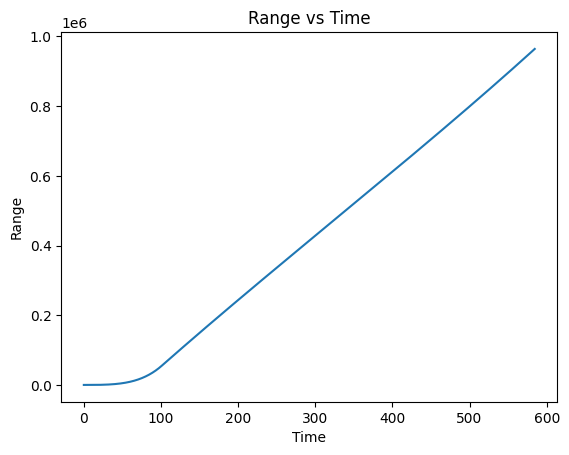

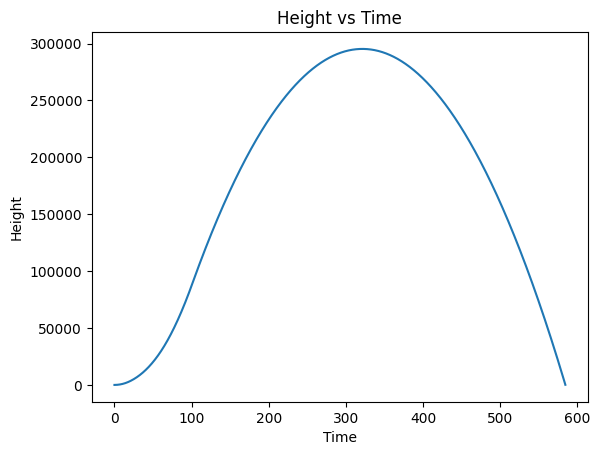

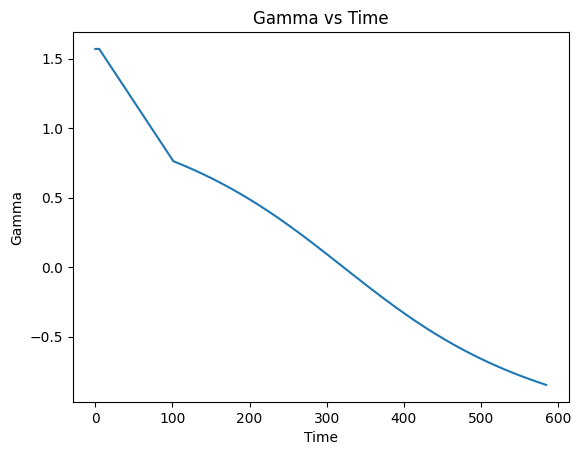

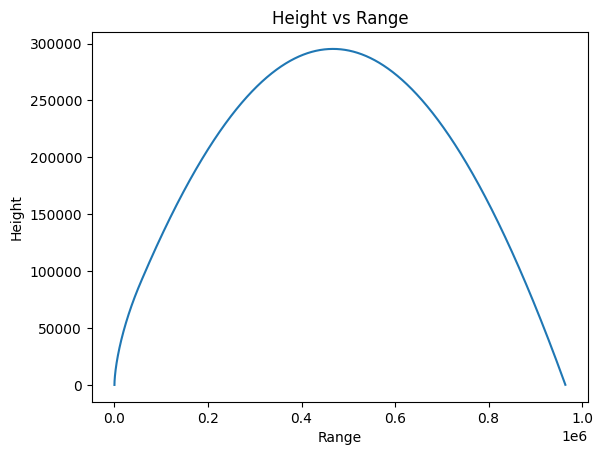

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 2878.4732375990375
Isp0: 691.1453837780005


Stage 1 burnout
Velocity (km/s):  5.561165367923626
Angle (deg h):  43.664370391304345
Range (km):  220.2879808475049
Time (sec):  216.79999999999197
Final results: 
Range (km):  4944.0956077612
Apogee (km):  1681.3718934778271
Time to target (sec):  1766.299999999489




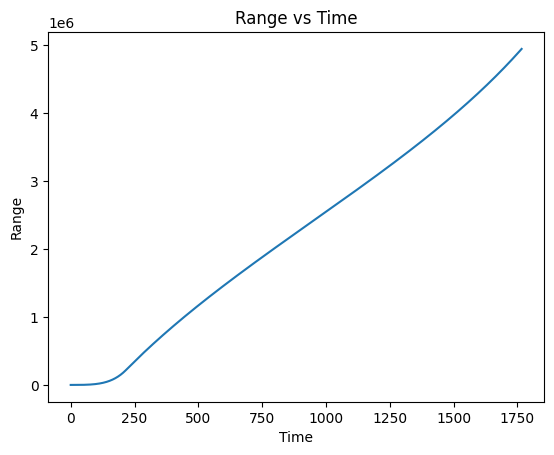

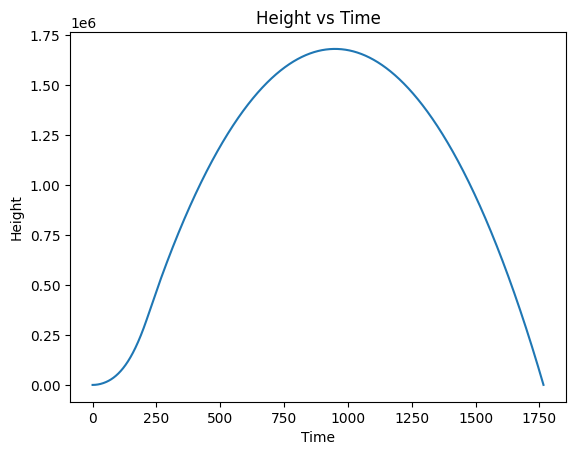

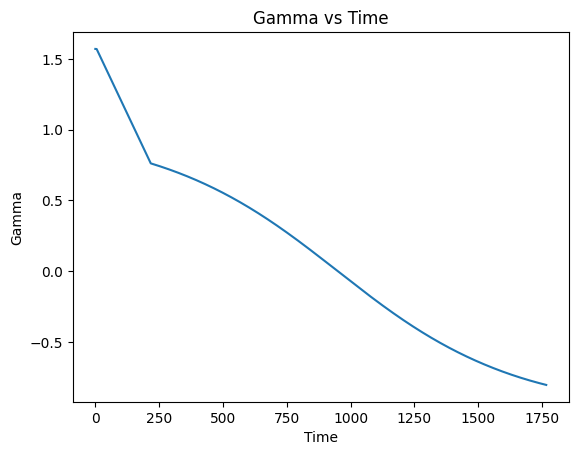

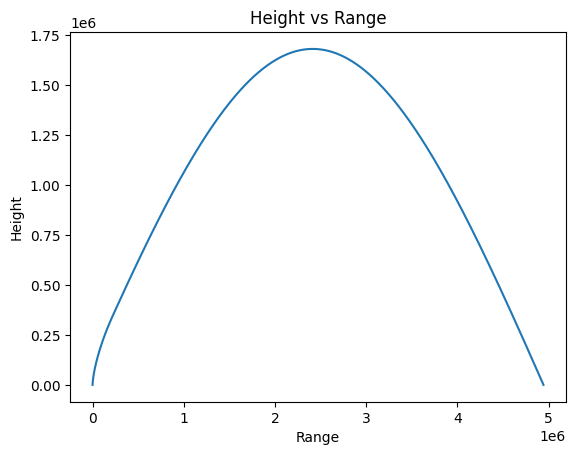

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 2604.4942751039184
Isp0: 271.68053276508255


Stage 1 burnout
Velocity (km/s):  1.7015402976015521
Angle (deg h):  43.651706058861876
Range (km):  25.37448097310091
Time (sec):  77.0999999999999
Final results: 
Range (km):  367.84642192411803
Apogee (km):  114.90194219202826
Time to target (sec):  360.7000000000135




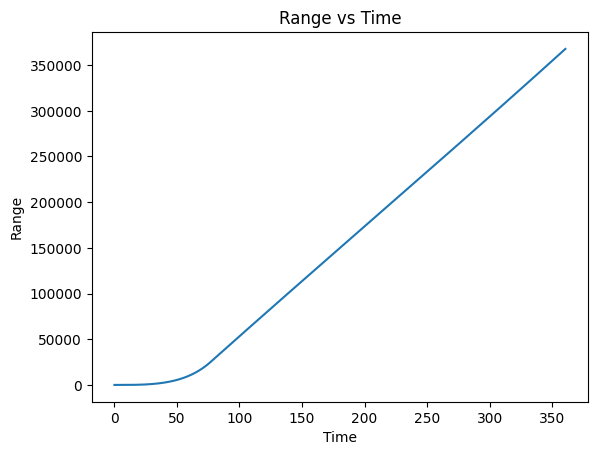

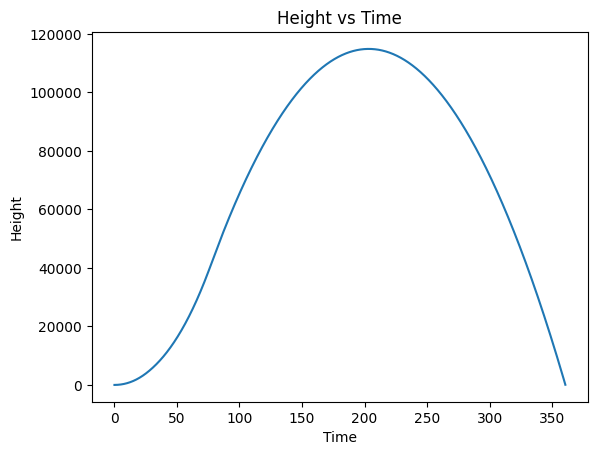

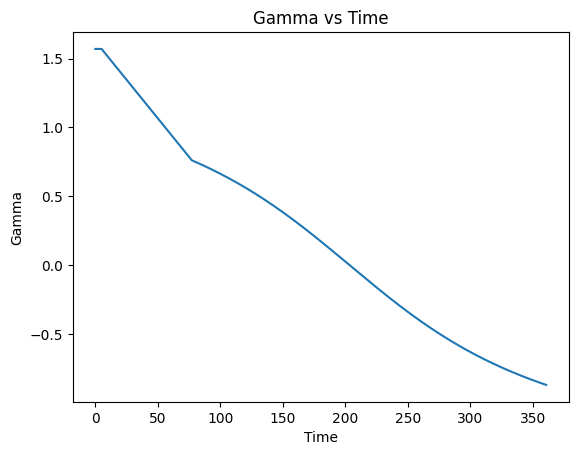

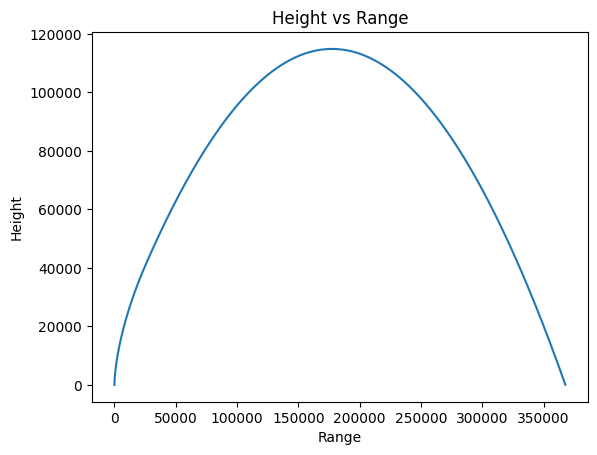

Data written to 'results/results_4.txt'


In [24]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m2_design = RandomDesign(m2_space)
m2_x = m2_design.get_samples(5)
m2_y = run_missile_sim(m2_x)

In [25]:
# Build model
m2_var_kernel = (100)**2 
m2_lengthscale = 1 # 1
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m2_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=2, lengthscale=lengthscale, variance =var_kernel)  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
m2_kern = GPy.kern.RBF(input_dim=2, lengthscale=m2_lengthscale ) + \
    GPy.kern.Linear(input_dim=2)

m2_model_gpy = GPRegression(m2_x,m2_y, kernel=m2_kern)
m2_model_gpy.kern.variance =  m2_var_kernel 
m2_model_gpy.likelihood.variance.fix(m2_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m2_model_gpy)




In [26]:
m2_model_emukit = GPyModelWrapper(m2_model_gpy)
m2_model_emukit.optimize()

In [27]:
display(m2_model_gpy)

In [33]:
# Create data for plot
wirte_output_txt = False
nr_points_plot = 101
m2_param_1_x_plot = np.linspace(m2_space.parameters[0].min, m2_space.parameters[0].max, nr_points_plot)[:, None]
m2_param_2_x_plot = np.linspace(m2_space.parameters[1].min, m2_space.parameters[1].max, nr_points_plot)[:, None]
m2_x_plot_mesh, m2_y_plot_mesh = np.meshgrid(m2_param_1_x_plot, m2_param_2_x_plot)
m2_x_plot = np.array([m2_x_plot_mesh, m2_y_plot_mesh]).T.reshape(-1,2)
m2_y_plot = run_missile_sim(m2_x_plot) # TAKES LONG TIME
m2_Z = m2_y_plot.reshape(m2_x_plot_mesh.shape)



In [51]:
# Compute current prediction
m2_mu_plot_grid_pred1, var_plot_grid_pred1 = m2_model_emukit.predict(m2_x_plot)
m2_mu_plot_pred1 = m2_mu_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)
m2_var_plot_pred1 = var_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)




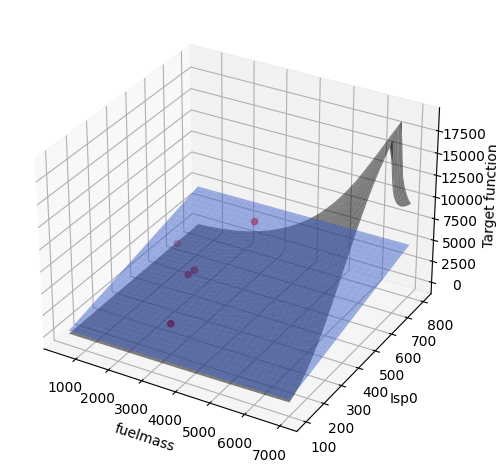

In [52]:
# 3D Plot
add_bands = False


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# True surface
surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                       alpha = .5, 
                       label='target function',
                       color='black'
                      )
# Mean predicted
surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1, 
                       alpha = .5, 
                       label='model', # Mean
                       color='royalblue'
                      )
# True points observed
ax.scatter(m2_x[:,0], m2_x[:,1], m2_y, marker='o', color='red')

if add_bands:
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1-2*m2_var_plot_pred1, 
                           alpha = .5, 
                           label='model_ci_lb', # Confidence band lower bound
                           color='lightskyblue'
                          )
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1+2*m2_var_plot_pred1, 
                           alpha = .5, 
                           label='model_ci_ub', # Confidence band upper bound
                           color='lightskyblue' 
                          )
ax.set_xlabel(m2_param_1)
ax.set_ylabel(m2_param_2)
ax.set_zlabel('Target function')
plt.tight_layout()



 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_85648/4024247045.py:12: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_85648/4024247045.py:21: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_85648/4024247045.py:32: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


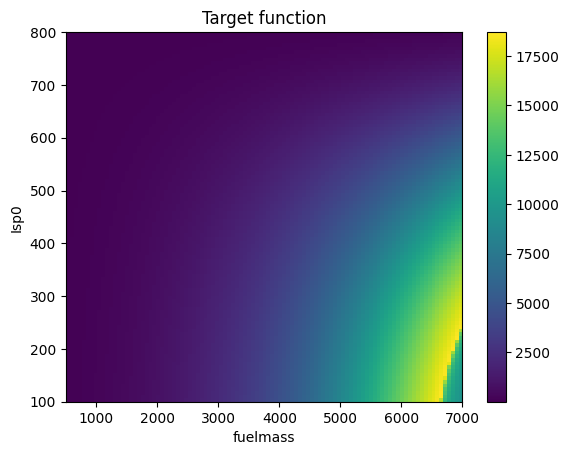

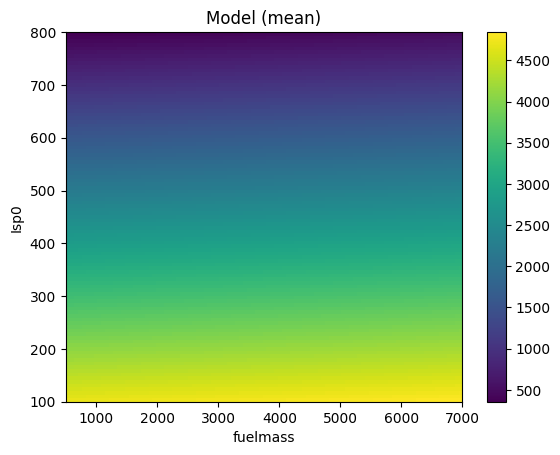

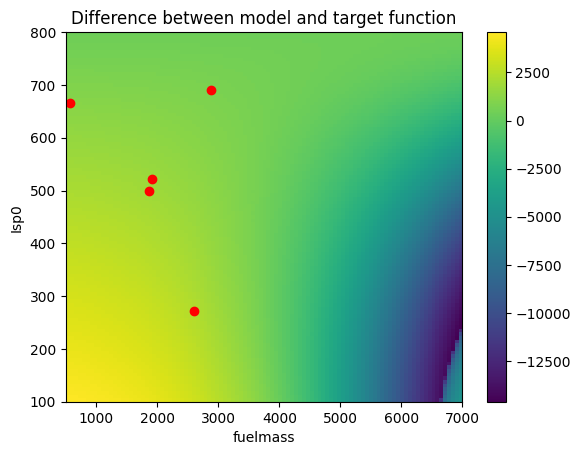

In [78]:
## Heatmaps
extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
           m2_space.parameters[1].min, m2_space.parameters[1].max]

# True values
fig, ax = plt.subplots()
im = ax.imshow(m2_Z, extent=extents, aspect='auto')
ax.set_title('Target function')
ax.set_xlabel(m2_param_1)
ax.set_ylabel(m2_param_2)
fig.colorbar(im, ax=ax)
fig.show()

# Model
fig, ax = plt.subplots()
im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto')
ax.set_title('Model (mean)')
ax.set_xlabel(m2_param_1)
ax.set_ylabel(m2_param_2)
fig.colorbar(im, ax=ax)
fig.show()


# Difference
fig, ax = plt.subplots()
im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto')
ax.set_title('Difference between model and target function')
ax.set_xlabel(m2_param_1)
ax.set_ylabel(m2_param_2)
ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
fig.colorbar(im, ax=ax)
fig.show()




In [38]:
m2_mu_plot.shape

(101, 101)

### Use the model created for model-based experiment design
use the model to decide which are the best points to collect using some data collection criteria (that we call acquisition).

In [53]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [54]:
# help(ExperimentalDesignLoop)

 It is known that when using Gaussian processes, selecting points of maximum variance is equivalent to maximizing the mutual information between the model and the new set of points so using ModelVariance is a simple but mathematically grounded approach.
 
 Actually in this example we use IVR

In [55]:
m2_2_model_emukit = m2_model_emukit

In [56]:
integrated_variance = IntegratedVarianceReduction(space=m2_space,
                                                  model=m2_model_emukit)
m2_ed = ExperimentalDesignLoop(space=m2_space, 
                            model=m2_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m2_ed.run_loop(user_function=run_missile_sim, stopping_condition=10)


 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

fuelmass: 7000.0
Isp0: 292.44373944322695


Stage 1 burnout
Velocity (km/s):  2.9624736731051438
Angle (deg h):  43.65213353012823
Range (km):  91.52407858279231
Time (sec):  223.0999999999916
Final results: 
Range (km):  1193.8631659659354
Apogee (km):  375.29186606239614
Time to target (sec):  770.6000000001067



New simulation 

fuelmass: 7000.0
Isp0: 724.5417962162513


Stage 1 burnout
Velocity (km/s):  8.581067101387381
Angle (deg h):  43.655401372094126
Range (km):  636.650059283394
Time (sec):  552.7000000000571
Final results: 
Range (km):  16386.92561635293
Apogee (km):  13167.672325895352
Time to target (sec):  10986.800000022438



New simulation 

fuelmass: 6999.458463233193
Isp0: 131.95962324132637


Stage 1 burnout
Velocity (km/s):  1.1460966038129445
Angle (deg h):  43.63736238015998
Range (km):  17.028615133224346
Time (sec):  100.69999999999855
Final results: 
Range (km):  174.5898235072429
Apogee (km):  56.69936000968621
Time to target (sec):  292.39

array([1919.93800195,  574.74506159, 1858.20913138, 2878.4732376 ,
       2604.4942751 , 7000.        , 7000.        , 6999.45846323,
       7000.        ,  500.        , 6987.99541874, 7000.        ,
       6995.41010702, 6746.33565655, 6795.68246875])

In [64]:
m2_2_model_emukit.__dict__

{'model': <GPy.models.gp_regression.GPRegression at 0x7fd1f86122c0>,
 'n_restarts': 1}

In [57]:
m2_ed.__dict__

{'candidate_point_calculator': <emukit.core.loop.candidate_point_calculators.SequentialPointCalculator at 0x7fd2290b5870>,
 'model_updaters': [<emukit.core.loop.model_updaters.FixedIntervalUpdater at 0x7fd2290b5180>],
 'loop_state': <emukit.core.loop.loop_state.LoopState at 0x7fd2290b60b0>,
 'loop_start_event': Event([]),
 'iteration_end_event': Event([]),
 'model': <emukit.model_wrappers.gpy_model_wrappers.GPyModelWrapper at 0x7fd1f8610e50>}

In [61]:
# Compute new prediction
m2_mu_plot_grid_pred2, var_plot_grid_pred2 = m2_2_model_emukit.predict(m2_x_plot)
m2_mu_plot_pred2 = m2_mu_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
m2_var_plot_pred2 = var_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)




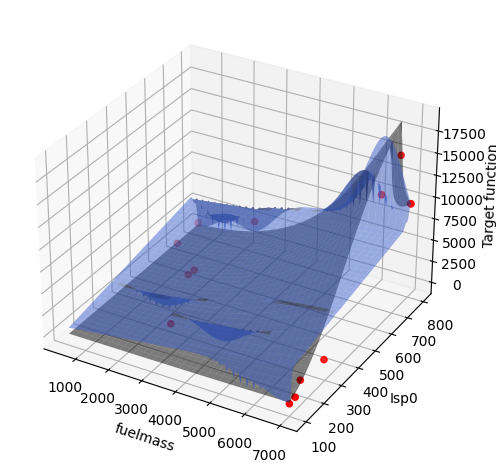

In [72]:
# 3D Plot
add_bands = False


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# True surface
surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                       alpha = .5, 
                       label='target function',
                       color='black'
                      )
# Mean predicted
surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2, 
                       alpha = .5, 
                       label='model', # Mean
                       color='royalblue'
                      )
# True points observed
ax.scatter(np.array(m2_2_model_emukit.X)[:,0], 
           np.array(m2_2_model_emukit.X)[:,1], m2_2_model_emukit.Y, marker='o', color='red')

if add_bands:
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2-2*m2_var_plot_pred2, 
                           alpha = .5, 
                           label='model_ci_lb', # Confidence band lower bound
                           color='lightskyblue'
                          )
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2+2*m2_var_plot_pred2, 
                           alpha = .5, 
                           label='model_ci_ub', # Confidence band upper bound
                           color='lightskyblue' 
                          )
ax.set_xlabel(m2_param_1)
ax.set_ylabel(m2_param_2)
ax.set_zlabel('Target function')
plt.tight_layout()




 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_85648/3875712094.py:12: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_85648/3875712094.py:21: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_85648/3875712094.py:32: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


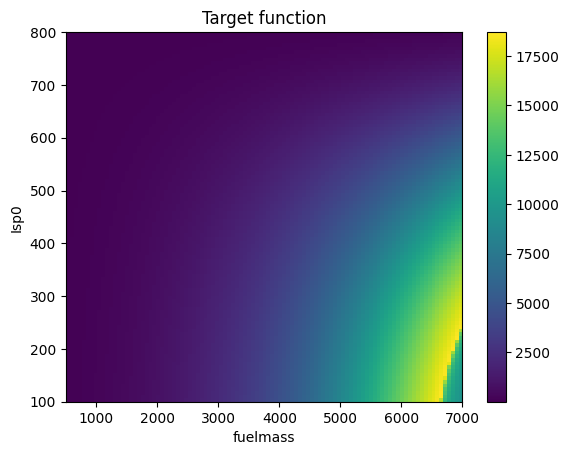

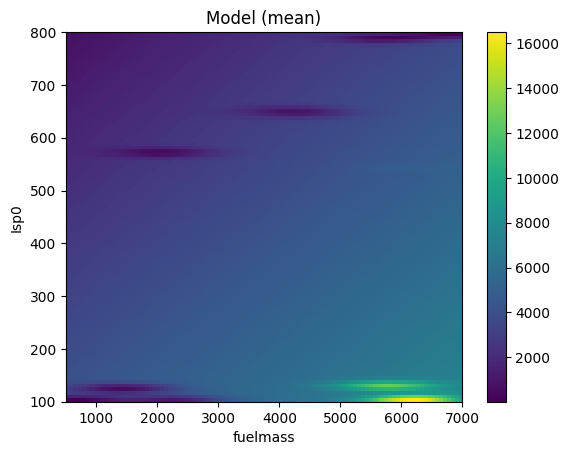

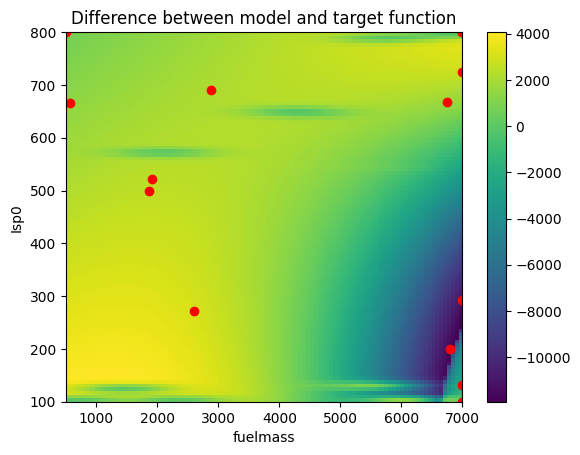

In [81]:
## Heatmaps
extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
           m2_space.parameters[1].min, m2_space.parameters[1].max]

# True values
fig, ax = plt.subplots()
im = ax.imshow(m2_Z, extent=extents, aspect='auto')
ax.set_title('Target function')
ax.set_xlabel(m2_param_1)
ax.set_ylabel(m2_param_2)
fig.colorbar(im, ax=ax)
fig.show()

# Model
fig, ax = plt.subplots()
im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto')
ax.set_title('Model (mean)')
ax.set_xlabel(m2_param_1)
ax.set_ylabel(m2_param_2)
fig.colorbar(im, ax=ax)
fig.show()


# Difference
fig, ax = plt.subplots()
im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto')
ax.set_title('Difference between model and target function')
ax.set_xlabel(m2_param_1)
ax.set_ylabel(m2_param_2)
ax.plot(np.array(m2_2_model_emukit.X)[:,0], np.array(m2_2_model_emukit.X)[:,1], 'ro')
fig.colorbar(im, ax=ax)
fig.show()


# ax.plot(m2_x, m2_y, marker='o', color='red')

## 2. Maximize range

The central idea of the acquisition function is to trade off the exploration of regions where the model is uncertain and the exploitation of the model’s confidence about good areas of the input space. There are a variety of acquisition functions in Emukit. In this example the expected improvement [3], that computes in expectation how much we can improve with respect to the current best observed location.

Bayesian optimization iterates the following three steps until it achieves a predefined stopping criterion (normally using a fixed number of evaluations).

1. Find the next point to evaluate the objective by using a numerical solver to optimize the acquisition/utility.
2. Evaluate the objective in that location and add the new observation to the data set.
3. Update the model using the currently available data.


In [96]:
m3_param_1 = 'fuelmass'
m3_param_2 = 'Isp0'
m3_param_3 = 'payload'
m3_param_4 = 'missilediam'
m3_param_5 = 'drymass'
m3_param_6 = 'thrust0'
# I am not sure 'estrange' and 'rvdiam' can be changed freely

m3_domain_param_1 = basic_param_spaces[m3_param_1] # [500, 6000] # [5000,15000]
m3_domain_param_2 = basic_param_spaces[m3_param_2] # [200, 300] # [224, 228]
m3_domain_param_3 = basic_param_spaces[m3_param_3] 
m3_domain_param_4 = basic_param_spaces[m3_param_4] 
m3_domain_param_5 = basic_param_spaces[m3_param_5] 
m3_domain_param_6 = basic_param_spaces[m3_param_6] 


m3_space = ParameterSpace(
          [ContinuousParameter(m3_param_1, *m3_domain_param_1), 
           ContinuousParameter(m3_param_2, *m3_domain_param_2),
           ContinuousParameter(m3_param_3, *m3_domain_param_3), 
           ContinuousParameter(m3_param_4, *m3_domain_param_4),
           ContinuousParameter(m3_param_5, *m3_domain_param_5), 
           ContinuousParameter(m3_param_6, *m3_domain_param_6),
          ])
custom_param_names = [m3_param_1, m3_param_2, m3_param_3, m3_param_4, m3_param_5, m3_param_6]


In [97]:
def neg_run_missile_sim(custom_params):
    return -run_missile_sim(custom_params)




New simulation 

fuelmass: 5470.011291828971
Isp0: 550.3712781995164
payload: 542.4330262799084
missilediam: 4.92893104609435
drymass: 1792.8590785826527
thrust0: 43659.12122974367


Stage 1 burnout
Velocity (km/s):  3.606661360843347
Angle (deg h):  43.6822523996802
Range (km):  36.17553427434572
Time (sec):  69.00000000000036
Final results: 
Range (km):  1587.8404443845582
Apogee (km):  438.08905113453557
Time to target (sec):  715.3000000000941




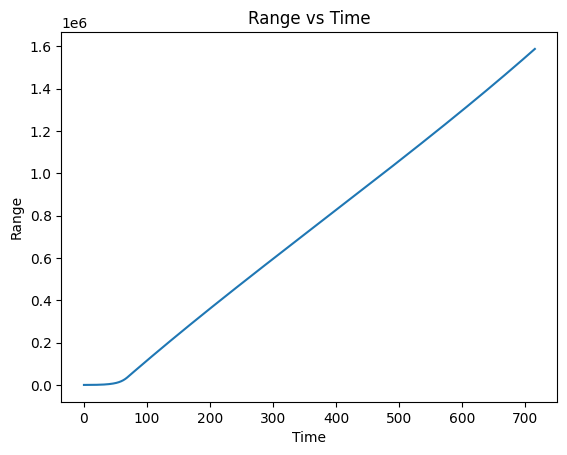

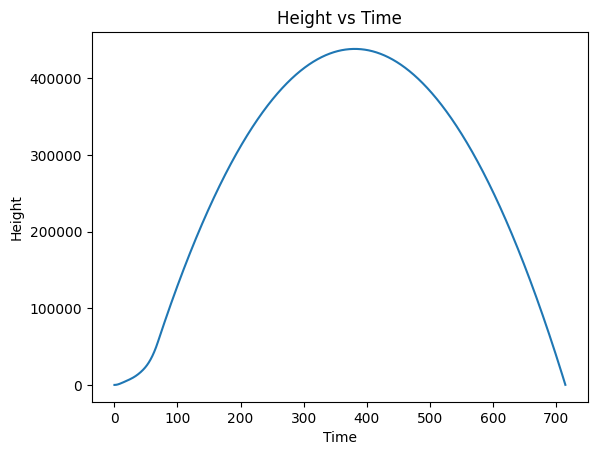

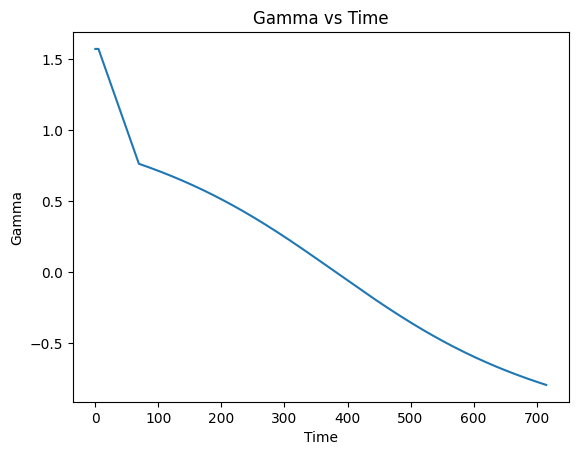

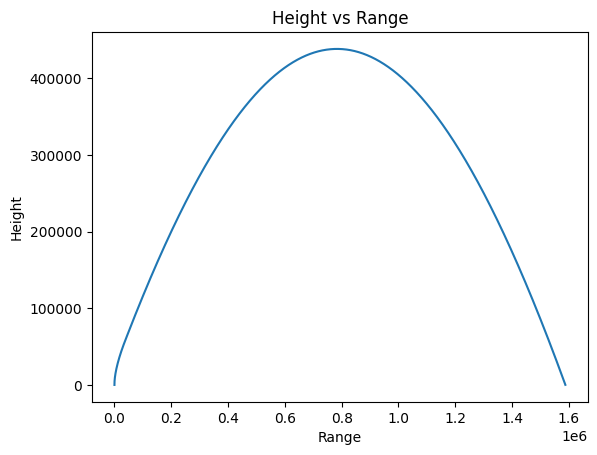

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5577.765253190949
Isp0: 751.1644249823843
payload: 1883.165205588652
missilediam: 7.186896860651185
drymass: 1616.7030596263396
thrust0: 26232.523789197527


Stage 1 burnout
Velocity (km/s):  4.147191549871767
Angle (deg h):  43.65634192833954
Range (km):  95.6634717743311
Time (sec):  159.6999999999952
Final results: 
Range (km):  2311.1633674949785
Apogee (km):  688.3575431998161
Time to target (sec):  994.3000000001575




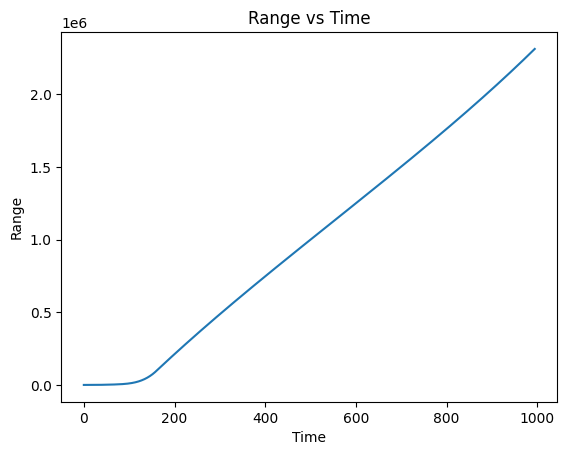

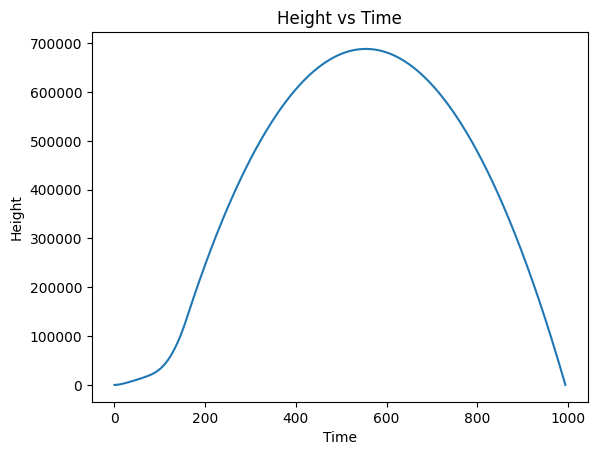

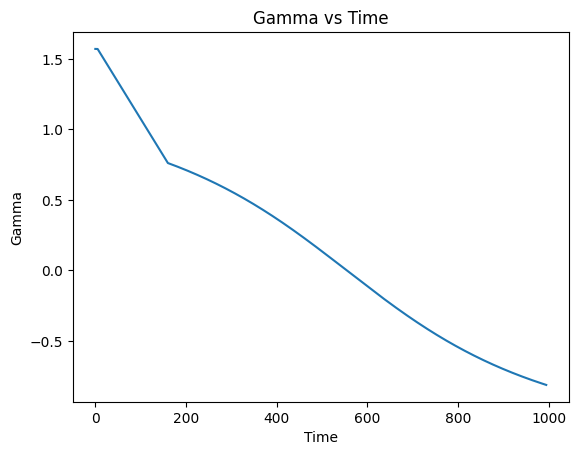

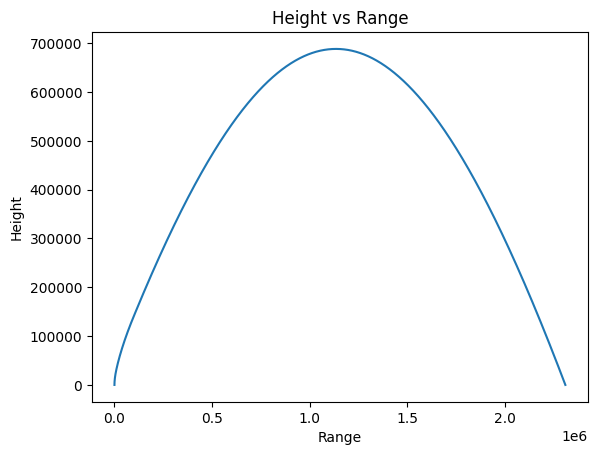

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 6016.487937762465
Isp0: 389.68340224759083
payload: 2200.477335365345
missilediam: 9.126145679263013
drymass: 2949.1052202200863
thrust0: 38613.68066714454


Stage 1 burnout
Velocity (km/s):  0.335798157750976
Angle (deg h):  43.66534902167537
Range (km):  6.2460591702902715
Time (sec):  60.70000000000059
Final results: 
Range (km):  25.961446587031094
Apogee (km):  16.140082488889142
Time to target (sec):  141.99999999999622




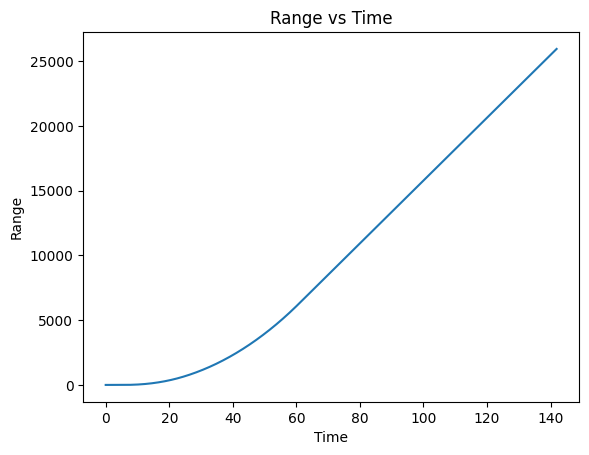

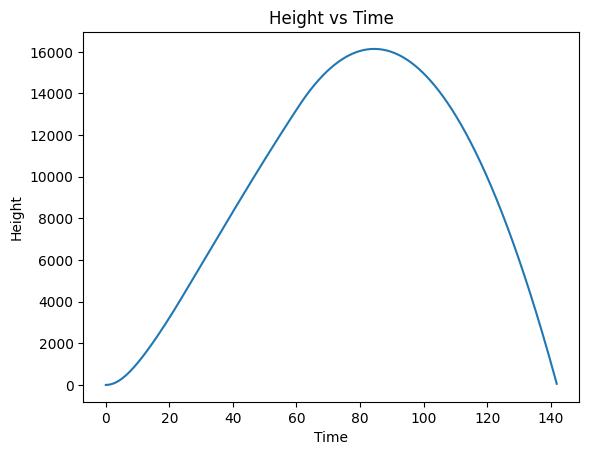

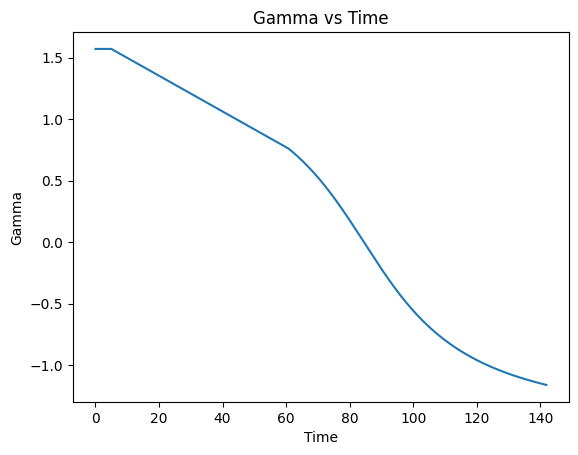

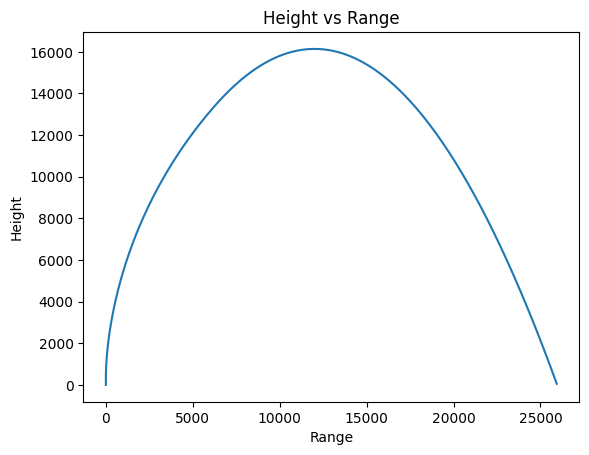

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 1967.6252028196045
Isp0: 136.9761786971173
payload: 2148.6720558279485
missilediam: 5.156988180427592
drymass: 1621.3442770017455
thrust0: 46967.68590449199


Stage 1 burnout
Velocity (km/s):  0.34397390901804176
Angle (deg h):  45.93951382521791
Range (km):  0.10970039512241167
Time (sec):  5.799999999999996
Final results: 
Range (km):  13.20809902747838
Apogee (km):  4.249295752262495
Time to target (sec):  60.60000000000059




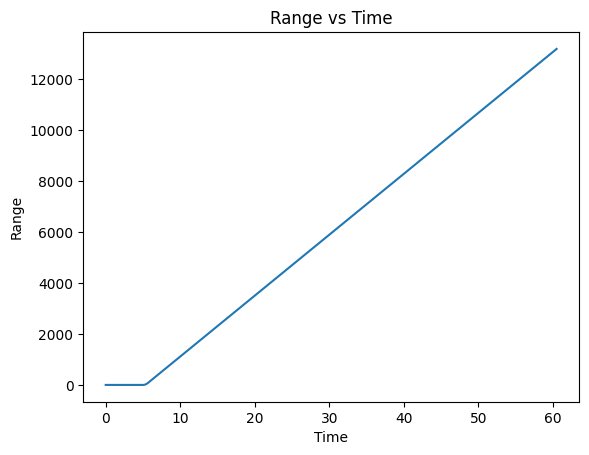

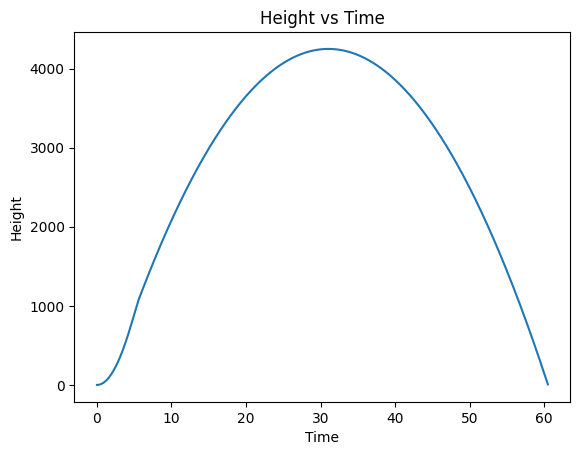

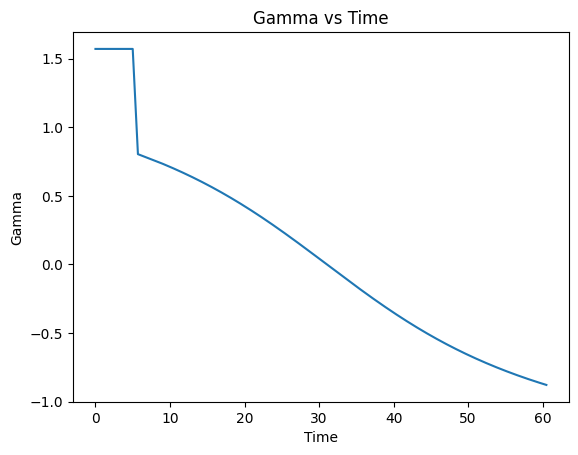

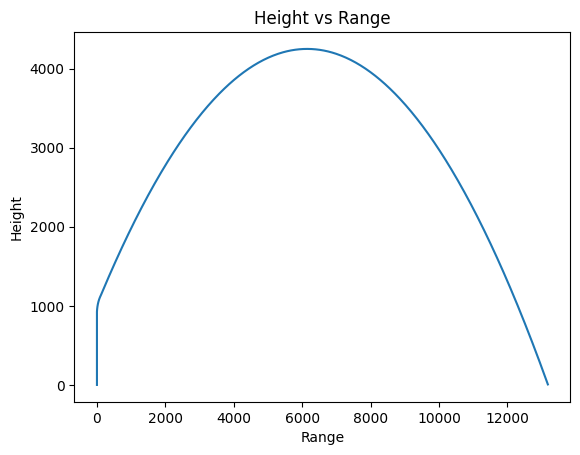

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 624.7314733883563
Isp0: 271.0049991083398
payload: 952.700571444189
missilediam: 2.78715063598483
drymass: 2242.2973514104283
thrust0: 56893.555861647066


Stage 1 burnout
Velocity (km/s):  0.4058314945400162
Angle (deg h):  90.0
Range (km):  3.855177166478838e-17
Time (sec):  3.000000000000002
Final results: 
Range (km):  -2.0115385079875324e-15
Apogee (km):  9.039701507328278
Time to target (sec):  87.4999999999993




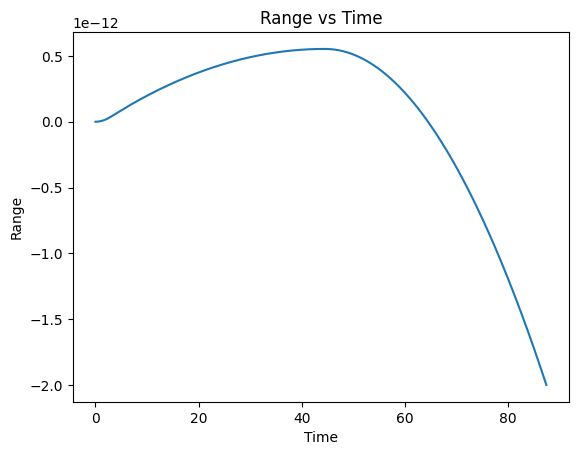

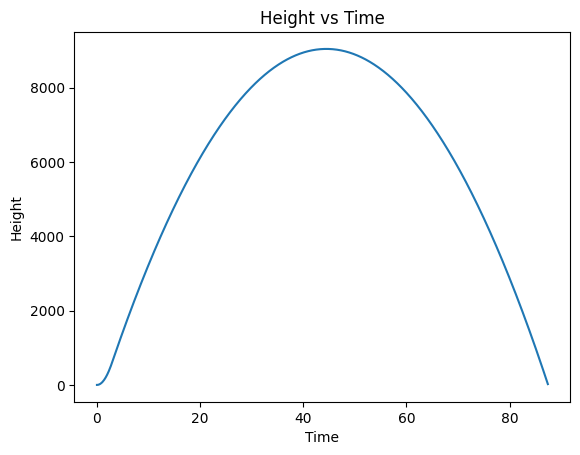

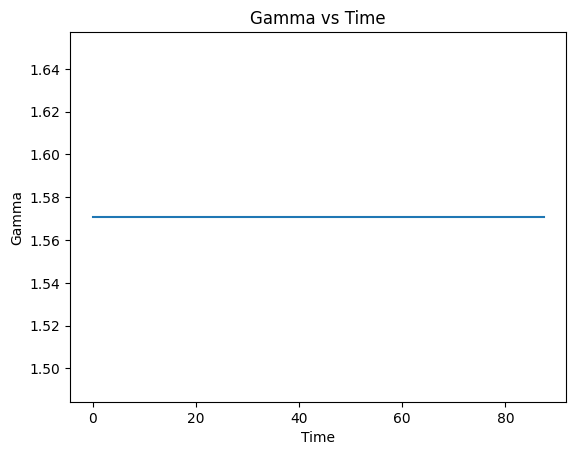

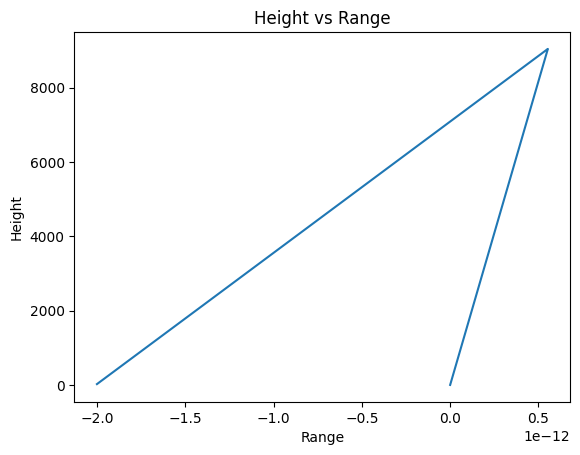

Data written to 'results/results_4.txt'


In [98]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m3_design = RandomDesign(m3_space)
m3_x = m3_design.get_samples(5)
m3_y = neg_run_missile_sim(m3_x)


In [99]:
# Build model
m3_var_kernel = (100)**2 
m3_lengthscale = 1 # 1
m3_var_noise = 1e-5 # small value

m3_kern = GPy.kern.RBF(input_dim=6, lengthscale=m3_lengthscale ) + \
    GPy.kern.Linear(input_dim=6)

m3_model_gpy = GPRegression(m3_x,m3_y, kernel=m3_kern)
m3_model_gpy.kern.variance =  m3_var_kernel 
m3_model_gpy.likelihood.variance.fix(m3_var_noise)  

display(m3_model_gpy)





In [100]:
m3_model_emukit = GPyModelWrapper(m3_model_gpy)
m3_model_emukit.optimize()

In [101]:
display(m3_model_gpy)



In [121]:
aa = np.array([1,2,3])
print(aa)
bb= np.reshape(aa,(1,3))
print(bb)
bb.shape

[1 2 3]
[[1 2 3]]


(1, 3)

In [124]:
# # Exact optimization: 
# # - opt1: Greedy: compute simulation on a grid and find maximum
# # - opt2: Minimize package

wirte_output_txt = False
from scipy.optimize import minimize
# # opt2
# func_to_minimize = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2  
def func_to_minimize(x):
    print(x)
    return neg_run_missile_sim(np.array(x).reshape(1,6))

# Function taking 6 inputs and returning the -range of the simulation run with those 6 params and 
# the others set as defaut
bnds = [(m3_domain_param_1),
        (m3_domain_param_2),
        (m3_domain_param_3),
        (m3_domain_param_4),
        (m3_domain_param_5),
        (m3_domain_param_6)]


initial_guess = [np.mean(m3_domain_param_1),
                 np.mean(m3_domain_param_2),
                 np.mean(m3_domain_param_3),
                 np.mean(m3_domain_param_4),
                 np.mean(m3_domain_param_5),
                 np.mean(m3_domain_param_6)]
true_minim = minimize(func_to_minimize, initial_guess, bounds=bnds) # , method='SLSQP'constraints=cons



[3.75e+03 4.50e+02 1.21e+03 5.00e+00 2.00e+03 3.95e+04]

New simulation 

fuelmass: 3750.0
Isp0: 450.0
payload: 1210.0
missilediam: 5.0
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  0.7844777879528466
Angle (deg h):  43.626046925903424
Range (km):  7.4653066774545564
Time (sec):  42.80000000000034
Final results: 
Range (km):  83.83005336768467
Apogee (km):  30.270040435656938
Time to target (sec):  177.89999999999418


[3.75e+03 4.50e+02 1.21e+03 5.00e+00 2.00e+03 3.95e+04]

New simulation 

fuelmass: 3750.00000001
Isp0: 450.0
payload: 1210.0
missilediam: 5.0
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  0.7844777879523125
Angle (deg h):  43.6260469260433
Range (km):  7.465306677430044
Time (sec):  42.80000000000034
Final results: 
Range (km):  83.83005336742852
Apogee (km):  30.270040435717217
Time to target (sec):  177.89999999999418


[3.75e+03 4.50e+02 1.21e+03 5.00e+00 2.00e+03 3.95e+04]

New simulation 

fuelmass: 3750.0
Isp0: 450.000

Final results: 
Range (km):  1135.6712027950307
Apogee (km):  312.8012764714271
Time to target (sec):  569.2000000000609


[3.74986473e+03 4.49043560e+02 1.20994511e+03 1.00000000e-01
 1.99994511e+03 3.95000201e+04]

New simulation 

fuelmass: 3749.8647296152526
Isp0: 449.04355973211904
payload: 1209.9451117492022
missilediam: 0.1
drymass: 1999.9451117392023
thrust0: 39500.02010929775


Stage 1 burnout
Velocity (km/s):  3.0875455432358803
Angle (deg h):  43.67570547358599
Range (km):  27.310877241008498
Time (sec):  42.70000000000034
Final results: 
Range (km):  1135.6712028309219
Apogee (km):  312.8012764669485
Time to target (sec):  569.2000000000609


[3.74986473e+03 4.49043560e+02 1.20994511e+03 1.00000010e-01
 1.99994511e+03 3.95000201e+04]

New simulation 

fuelmass: 3749.8647296152526
Isp0: 449.04355973211904
payload: 1209.9451117392023
missilediam: 0.10000001
drymass: 1999.9451117392023
thrust0: 39500.02010929775


Stage 1 burnout
Velocity (km/s):  3.0875455429631713
Angle (deg

Final results: 
Range (km):  1127.1084761021164
Apogee (km):  310.2991236972159
Time to target (sec):  566.6000000000603


[3.74983267e+03 4.48817978e+02 1.20993185e+03 1.00000000e-01
 1.99993185e+03 3.95000245e+04]

New simulation 

fuelmass: 3749.832669125069
Isp0: 448.81797811461195
payload: 1209.9318479567519
missilediam: 0.1
drymass: 1999.9318479567519
thrust0: 39500.024451184254


Stage 1 burnout
Velocity (km/s):  3.0765933116343436
Angle (deg h):  43.65989396665839
Range (km):  27.10896454917188
Time (sec):  42.600000000000335
Final results: 
Range (km):  1127.1084761050201
Apogee (km):  310.29912369893776
Time to target (sec):  566.6000000000603


[3.74986422e+03 4.49039985e+02 1.20994490e+03 1.00000000e-01
 1.99994490e+03 3.95000202e+04]

New simulation 

fuelmass: 3749.864221522746
Isp0: 449.0399847297134
payload: 1209.944901535664
missilediam: 0.1
drymass: 1999.944901535664
thrust0: 39500.02017810752


Stage 1 burnout
Velocity (km/s):  3.0875611578637367
Angle (deg h):  43.6

Final results: 
Range (km):  1126.683329718643
Apogee (km):  310.3282314525928
Time to target (sec):  566.6000000000603


[3.74984820e+03 4.48927245e+02 1.20993827e+03 1.00000000e-01
 1.99993827e+03 3.95000223e+04]

New simulation 

fuelmass: 3749.8481985805674
Isp0: 448.9272453051721
payload: 1209.9382726657357
missilediam: 0.1
drymass: 1999.9382726657357
thrust0: 39500.022348066756


Stage 1 burnout
Velocity (km/s):  3.0761193040355024
Angle (deg h):  43.67289228642236
Range (km):  27.099502873541358
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.6833297215285
Apogee (km):  310.32823145437334
Time to target (sec):  566.6000000000603


[3.74986361e+03 4.49035678e+02 1.20994465e+03 1.00000000e-01
 1.99994465e+03 3.95000203e+04]

New simulation 

fuelmass: 3749.8636094755884
Isp0: 449.0356782893888
payload: 1209.9446483249271
missilediam: 0.1
drymass: 1999.9446483249271
thrust0: 39500.020260995625


Stage 1 burnout
Velocity (km/s):  3.0875799677635394
Angle (deg h):  

Final results: 
Range (km):  1129.1577041595338
Apogee (km):  311.17173185042475
Time to target (sec):  567.5000000000605


[3.74974398e+03 4.48188299e+02 1.20989508e+03 1.00000000e-01
 1.99989508e+03 3.95000363e+04]

New simulation 

fuelmass: 3749.7439782777888
Isp0: 448.18829875533356
payload: 1209.895082919031
missilediam: 0.1
drymass: 1999.895082919031
thrust0: 39500.03628597667


Stage 1 burnout
Velocity (km/s):  3.079331490472148
Angle (deg h):  43.697251307992424
Range (km):  27.16359798265517
Time (sec):  42.600000000000335
Final results: 
Range (km):  1129.1577041268538
Apogee (km):  311.1717318535377
Time to target (sec):  567.5000000000605


[3.74974398e+03 4.48188299e+02 1.20989508e+03 1.00000000e-01
 1.99989508e+03 3.95000363e+04]

New simulation 

fuelmass: 3749.7439782777888
Isp0: 448.18829874533355
payload: 1209.8950829290309
missilediam: 0.1
drymass: 1999.895082919031
thrust0: 39500.03628597667


Stage 1 burnout
Velocity (km/s):  3.0793314905061937
Angle (deg h):  43.

Final results: 
Range (km):  1135.983490602646
Apogee (km):  312.7802859259451
Time to target (sec):  569.2000000000609


[3.74985342e+03 4.48963989e+02 1.20994043e+03 1.00000000e-01
 1.99994043e+03 3.95000216e+04]

New simulation 

fuelmass: 3749.8534208580677
Isp0: 448.963989004767
payload: 1209.9404331686305
missilediam: 0.1
drymass: 1999.9404331786304
thrust0: 39500.021640787956


Stage 1 burnout
Velocity (km/s):  3.087893186036963
Angle (deg h):  43.66624604520125
Range (km):  27.317821743022673
Time (sec):  42.70000000000034
Final results: 
Range (km):  1135.9834906827218
Apogee (km):  312.7802859846925
Time to target (sec):  569.2000000000609


[3.74985342e+03 4.48963989e+02 1.20994043e+03 1.00000000e-01
 1.99994043e+03 3.95000216e+04]

New simulation 

fuelmass: 3749.8534208580677
Isp0: 448.963989004767
payload: 1209.9404331686305
missilediam: 0.1
drymass: 1999.9404331686305
thrust0: 39500.02164079795


Stage 1 burnout
Velocity (km/s):  3.0878931860460965
Angle (deg h):  43.666

Final results: 
Range (km):  1135.9895829205475
Apogee (km):  312.7798760297286
Time to target (sec):  569.2000000000609


[3.74985320e+03 4.48962437e+02 1.20994034e+03 1.00000000e-01
 1.99994034e+03 3.95000217e+04]

New simulation 

fuelmass: 3749.853201873373
Isp0: 448.96243684791176
payload: 1209.9403424227435
missilediam: 0.1
drymass: 1999.9403424227435
thrust0: 39500.02167009299


Stage 1 burnout
Velocity (km/s):  3.0878999673285707
Angle (deg h):  43.66606150906411
Range (km):  27.317957211493663
Time (sec):  42.70000000000034
Final results: 
Range (km):  1135.989582915157
Apogee (km):  312.77987602943864
Time to target (sec):  569.2000000000609


[3.74985320e+03 4.48962437e+02 1.20994034e+03 1.00000000e-01
 1.99994034e+03 3.95000217e+04]

New simulation 

fuelmass: 3749.853201863373
Isp0: 448.96243685791177
payload: 1209.9403424227435
missilediam: 0.1
drymass: 1999.9403424227435
thrust0: 39500.02167009299


Stage 1 burnout
Velocity (km/s):  3.0878999672946614
Angle (deg h):  43.

Final results: 
Range (km):  1136.0277820729464
Apogee (km):  312.77730539621814
Time to target (sec):  569.2000000000609


[3.74985183e+03 4.48952705e+02 1.20993977e+03 1.00000010e-01
 1.99993977e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8518287895376
Isp0: 448.9527049867183
payload: 1209.9397734555187
missilediam: 0.10000001
drymass: 1999.9397734555187
thrust0: 39500.0218538325


Stage 1 burnout
Velocity (km/s):  3.087942486864374
Angle (deg h):  43.664904452750974
Range (km):  27.318806611140644
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0277819928706
Apogee (km):  312.7773053374736
Time to target (sec):  569.2000000000609


[3.74985183e+03 4.48952705e+02 1.20993977e+03 1.00000000e-01
 1.99993977e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8518287895376
Isp0: 448.9527049867183
payload: 1209.9397734555187
missilediam: 0.1
drymass: 1999.9397734655186
thrust0: 39500.0218538325


Stage 1 burnout
Velocity (km/s):  3.0879424871371173
Angle (deg h)

Final results: 
Range (km):  1126.60474488378
Apogee (km):  310.33360511034823
Time to target (sec):  566.6000000000603


[3.74985183e+03 4.48952695e+02 1.20993977e+03 1.00000000e-01
 1.99993977e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8518274407757
Isp0: 448.95269542717205
payload: 1209.9397728966258
missilediam: 0.1
drymass: 1999.9397728966258
thrust0: 39500.02185401298


Stage 1 burnout
Velocity (km/s):  3.0879425289132842
Angle (deg h):  43.66490331615458
Range (km):  27.318807448687682
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.027819599242
Apogee (km):  312.77730287249017
Time to target (sec):  569.2000000000609


[3.74985183e+03 4.48952695e+02 1.20993977e+03 1.00000000e-01
 1.99993977e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8518274507755
Isp0: 448.95269542717205
payload: 1209.9397728966258
missilediam: 0.1
drymass: 1999.9397728966258
thrust0: 39500.02185401298


Stage 1 burnout
Velocity (km/s):  3.0879425289054203
Angle (deg h):  43

Final results: 
Range (km):  1136.0381217677643
Apogee (km):  312.77660953837443
Time to target (sec):  569.2000000000609


[3.74985146e+03 4.48950071e+02 1.20993962e+03 1.00000000e-01
 1.99993962e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8514571434
Isp0: 448.95007090048097
payload: 1209.9396194547169
missilediam: 0.1
drymass: 1999.9396194547169
thrust0: 39500.02190356477


Stage 1 burnout
Velocity (km/s):  3.087953996362666
Angle (deg h):  43.664591266901965
Range (km):  27.319036527573388
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.038121734979
Apogee (km):  312.7766095415384
Time to target (sec):  569.2000000000609


[3.74985146e+03 4.48950071e+02 1.20993962e+03 1.00000000e-01
 1.99993962e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8514571434
Isp0: 448.95007089048096
payload: 1209.9396194647168
missilediam: 0.1
drymass: 1999.9396194547169
thrust0: 39500.02190356477


Stage 1 burnout
Velocity (km/s):  3.087953996396587
Angle (deg h):  43.66459

Final results: 
Range (km):  1136.0393577482957
Apogee (km):  312.7765262907171
Time to target (sec):  569.2000000000609


[3.74985141e+03 4.48949756e+02 1.20993960e+03 1.00000000e-01
 1.99993960e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851412715475
Isp0: 448.9497560010787
payload: 1209.9396010449034
missilediam: 0.1
drymass: 1999.9396010549033
thrust0: 39500.02190950994


Stage 1 burnout
Velocity (km/s):  3.087955372270628
Angle (deg h):  43.6645538259435
Range (km):  27.319064013371758
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0393578283854
Apogee (km):  312.77652634946725
Time to target (sec):  569.2000000000609


[3.74985141e+03 4.48949756e+02 1.20993960e+03 1.00000000e-01
 1.99993960e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851412715475
Isp0: 448.9497560010787
payload: 1209.9396010449034
missilediam: 0.1
drymass: 1999.9396010449034
thrust0: 39500.021909519935


Stage 1 burnout
Velocity (km/s):  3.0879553722795934
Angle (deg h):  43.66

Final results: 
Range (km):  1136.0393578312996
Apogee (km):  312.77652635120205
Time to target (sec):  569.2000000000609


[3.74974152e+03 4.48173222e+02 1.20989413e+03 1.00000000e-01
 1.99989413e+03 3.95000356e+04]

New simulation 

fuelmass: 3749.741520205612
Isp0: 448.17322243638296
payload: 1209.8941264207415
missilediam: 0.1
drymass: 1999.8941264207415
thrust0: 39500.03561067608


Stage 1 burnout
Velocity (km/s):  3.0793974587568327
Angle (deg h):  43.69545319634635
Range (km):  27.164912305099012
Time (sec):  42.600000000000335
Final results: 
Range (km):  1129.2167632523106
Apogee (km):  311.1677797543552
Time to target (sec):  567.5000000000605


[3.74974152e+03 4.48173222e+02 1.20989413e+03 1.00000000e-01
 1.99989413e+03 3.95000356e+04]

New simulation 

fuelmass: 3749.7415202156117
Isp0: 448.17322243638296
payload: 1209.8941264207415
missilediam: 0.1
drymass: 1999.8941264207415
thrust0: 39500.03561067608


Stage 1 burnout
Velocity (km/s):  3.0793974587489923
Angle (deg h):  

Final results: 
Range (km):  1136.0398459351857
Apogee (km):  312.7764935050292
Time to target (sec):  569.2000000000609


[3.74985140e+03 4.48949632e+02 1.20993959e+03 1.00000000e-01
 1.99993959e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8513951190894
Isp0: 448.94963166972104
payload: 1209.9395937633424
missilediam: 0.1
drymass: 1999.9395937633424
thrust0: 39500.02191170382


Stage 1 burnout
Velocity (km/s):  3.0879559155721252
Angle (deg h):  43.66453904259116
Range (km):  27.319074866274814
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0398459023656
Apogee (km):  312.77649350815415
Time to target (sec):  569.2000000000609


[3.74985140e+03 4.48949632e+02 1.20993959e+03 1.00000000e-01
 1.99993959e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8513951190894
Isp0: 448.94963165972104
payload: 1209.9395937733423
missilediam: 0.1
drymass: 1999.9395937633424
thrust0: 39500.02191170382


Stage 1 burnout
Velocity (km/s):  3.0879559156062135
Angle (deg h):  

Final results: 
Range (km):  1136.0400569682733
Apogee (km):  312.7764792389796
Time to target (sec):  569.2000000000609


[3.74985139e+03 4.48949578e+02 1.20993959e+03 1.00000000e-01
 1.99993959e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851387508568
Isp0: 448.94957788148474
payload: 1209.939590614032
missilediam: 0.1
drymass: 1999.939590624032
thrust0: 39500.02191265268


Stage 1 burnout
Velocity (km/s):  3.0879561506015407
Angle (deg h):  43.664532647044204
Range (km):  27.31907956133534
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0400570483532
Apogee (km):  312.776479297728
Time to target (sec):  569.2000000000609


[3.74985139e+03 4.48949578e+02 1.20993959e+03 1.00000000e-01
 1.99993959e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851387508568
Isp0: 448.94957788148474
payload: 1209.939590614032
missilediam: 0.1
drymass: 1999.939590614032
thrust0: 39500.021912662676


Stage 1 burnout
Velocity (km/s):  3.0879561506106747
Angle (deg h):  43.6645

Final results: 
Range (km):  1136.043332801542
Apogee (km):  312.77625886730374
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948743e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512694280353
Isp0: 448.9487434182238
payload: 1209.9395417469839
missilediam: 0.1
drymass: 1999.9395417469839
thrust0: 39500.02192737596


Stage 1 burnout
Velocity (km/s):  3.087959796978088
Angle (deg h):  43.66443342700206
Range (km):  27.31915240133977
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0433327961375
Apogee (km):  312.7762588670194
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948743e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512694180354
Isp0: 448.9487434282238
payload: 1209.9395417469839
missilediam: 0.1
drymass: 1999.9395417469839
thrust0: 39500.02192737596


Stage 1 burnout
Velocity (km/s):  3.0879597969443404
Angle (deg h):  43.66

Final results: 
Range (km):  1136.0433328089296
Apogee (km):  312.7762588650515
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948743e+02 1.20993954e+03 1.00000010e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512694176875
Isp0: 448.9487434157643
payload: 1209.93954174684
missilediam: 0.10000001
drymass: 1999.93954174684
thrust0: 39500.021927376


Stage 1 burnout
Velocity (km/s):  3.087959796716239
Angle (deg h):  43.66443342656945
Range (km):  27.319152398527628
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0433327288385
Apogee (km):  312.77625880630524
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948743e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512694176875
Isp0: 448.9487434157643
payload: 1209.93954174684
missilediam: 0.1
drymass: 1999.9395417568398
thrust0: 39500.021927376


Stage 1 burnout
Velocity (km/s):  3.0879597969889883
Angle (deg h):  43.664

Final results: 
Range (km):  1126.6000862377427
Apogee (km):  310.3339240888103
Time to target (sec):  566.6000000000603


[3.74985126e+03 4.48948646e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851255699615
Isp0: 448.9486464797354
payload: 1209.939536070164
missilediam: 0.1
drymass: 1999.939536070164
thrust0: 39500.02192909634


Stage 1 burnout
Velocity (km/s):  3.076026489514012
Angle (deg h):  43.67543753453498
Range (km):  27.097650156744756
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.600086240699
Apogee (km):  310.3339240905798
Time to target (sec):  566.6000000000603


[3.74985127e+03 4.48948738e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851268658727
Isp0: 448.9487380527201
payload: 1209.9395414327744
missilediam: 0.1
drymass: 1999.9395414327744
thrust0: 39500.02192747063


Stage 1 burnout
Velocity (km/s):  3.087959820431964
Angle (deg h):  43.664432

Final results: 
Range (km):  1126.764994016513
Apogee (km):  310.3226302250607
Time to target (sec):  566.6000000000603


[3.74984527e+03 4.48906239e+02 1.20993706e+03 1.00000000e-01
 1.99993706e+03 3.95000227e+04]

New simulation 

fuelmass: 3749.845271932803
Isp0: 448.90623858811864
payload: 1209.9370586948924
missilediam: 0.1
drymass: 1999.9370586948924
thrust0: 39500.022683462


Stage 1 burnout
Velocity (km/s):  3.076210314100686
Angle (deg h):  43.67039482158506
Range (km):  27.101320247926047
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.7649940111544
Apogee (km):  310.3226302247815
Time to target (sec):  566.6000000000603


[3.74984527e+03 4.48906239e+02 1.20993706e+03 1.00000000e-01
 1.99993706e+03 3.95000227e+04]

New simulation 

fuelmass: 3749.845271922803
Isp0: 448.90623859811865
payload: 1209.9370586948924
missilediam: 0.1
drymass: 1999.9370586948924
thrust0: 39500.022683462


Stage 1 burnout
Velocity (km/s):  3.0762103140672337
Angle (deg h):  43.67039

Final results: 
Range (km):  1136.0433538304462
Apogee (km):  312.7762574525482
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948738e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512686585723
Isp0: 448.948738051623
payload: 1209.9395414427102
missilediam: 0.1
drymass: 1999.9395414327103
thrust0: 39500.021927470654


Stage 1 burnout
Velocity (km/s):  3.0879598204289374
Angle (deg h):  43.66443278875693
Range (km):  27.319152869861966
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0433538663654
Apogee (km):  312.77625744805783
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948738e+02 1.20993954e+03 1.00000010e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512686585723
Isp0: 448.948738051623
payload: 1209.9395414327103
missilediam: 0.10000001
drymass: 1999.9395414327103
thrust0: 39500.021927470654


Stage 1 burnout
Velocity (km/s):  3.0879598201561933
Angle (deg 

Final results: 
Range (km):  1126.5999751811896
Apogee (km):  310.3339316862797
Time to target (sec):  566.6000000000603


[3.74985126e+03 4.48948675e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512597670874
Isp0: 448.94867503678654
payload: 1209.9395377515034
missilediam: 0.1
drymass: 1999.9395377515034
thrust0: 39500.02192860157


Stage 1 burnout
Velocity (km/s):  3.0760263657001867
Angle (deg h):  43.675440930398565
Range (km):  27.097647685021162
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.5999751841655
Apogee (km):  310.3339316880247
Time to target (sec):  566.6000000000603


[3.74985127e+03 4.48948738e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512686150257
Isp0: 448.9487377430041
payload: 1209.9395414146813
missilediam: 0.1
drymass: 1999.9395414146813
thrust0: 39500.02192747614


Stage 1 burnout
Velocity (km/s):  3.0879598217851276
Angle (deg h):  

Final results: 
Range (km):  1126.5998532771669
Apogee (km):  310.3339400343052
Time to target (sec):  566.6000000000603


[3.74985126e+03 4.48948706e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851264191003
Isp0: 448.9487063995159
payload: 1209.9395395830702
missilediam: 0.1
drymass: 1999.9395395830702
thrust0: 39500.021928033864


Stage 1 burnout
Velocity (km/s):  3.0760262297752896
Angle (deg h):  43.67544465932739
Range (km):  27.097644971164815
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.5998532447197
Apogee (km):  310.3339400374718
Time to target (sec):  566.6000000000603


[3.74985126e+03 4.48948706e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851264191003
Isp0: 448.9487063895159
payload: 1209.93953959307
missilediam: 0.1
drymass: 1999.9395395830702
thrust0: 39500.021928033864


Stage 1 burnout
Velocity (km/s):  3.076026229808916
Angle (deg h):  43.67

Final results: 
Range (km):  1136.0433552791678
Apogee (km):  312.7762572888371
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948738e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512686049094
Isp0: 448.9487376713111
payload: 1209.9395414104931
missilediam: 0.1
drymass: 1999.939541420493
thrust0: 39500.02192747741


Stage 1 burnout
Velocity (km/s):  3.087959822090698
Angle (deg h):  43.664432743537745
Range (km):  27.31915290305785
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0433553592575
Apogee (km):  312.7762573475821
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948738e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512686049094
Isp0: 448.9487376713111
payload: 1209.9395414104931
missilediam: 0.1
drymass: 1999.9395414104931
thrust0: 39500.02192748741


Stage 1 burnout
Velocity (km/s):  3.087959822099674
Angle (deg h):  43.664

Final results: 
Range (km):  1136.043355362237
Apogee (km):  312.77625734934884
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948738e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512686041367
Isp0: 448.9487376658335
payload: 1209.9395414101732
missilediam: 0.1
drymass: 1999.9395414101732
thrust0: 39500.021927477515


Stage 1 burnout
Velocity (km/s):  3.087959822122323
Angle (deg h):  43.66443274288722
Range (km):  27.3191529035964
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.043355382988
Apogee (km):  312.776257347748
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948738e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512686141366
Isp0: 448.9487376658335
payload: 1209.9395414101732
missilediam: 0.1
drymass: 1999.9395414101732
thrust0: 39500.021927477515


Stage 1 burnout
Velocity (km/s):  3.087959822114463
Angle (deg h):  43.6644

Final results: 
Range (km):  1136.0434062851207
Apogee (km):  312.77625392174843
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948725e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851266773007
Isp0: 448.9487246884349
payload: 1209.939540662058
missilediam: 0.1
drymass: 1999.9395406520582
thrust0: 39500.02192770836


Stage 1 burnout
Velocity (km/s):  3.0879598788156017
Angle (deg h):  43.66443119990511
Range (km):  27.319154036240754
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0434063210428
Apogee (km):  312.7762539172737
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948725e+02 1.20993954e+03 1.00000010e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851266773007
Isp0: 448.9487246884349
payload: 1209.9395406520582
missilediam: 0.10000001
drymass: 1999.9395406520582
thrust0: 39500.02192770836


Stage 1 burnout
Velocity (km/s):  3.0879598785428546
Angle (deg h):

Final results: 
Range (km):  1126.7235662857636
Apogee (km):  310.32623825633385
Time to target (sec):  566.6000000000603


[3.74985124e+03 4.48948655e+02 1.20993953e+03 1.00000000e-01
 1.99993953e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512412615455
Isp0: 448.9486548651384
payload: 1209.9395344166041
missilediam: 0.1
drymass: 1999.9395344166041
thrust0: 39500.021926359244


Stage 1 burnout
Velocity (km/s):  3.076026468319535
Angle (deg h):  43.675438316344035
Range (km):  27.09764965903744
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.6000628069046
Apogee (km):  310.33392739275735
Time to target (sec):  566.6000000000603


[3.74985124e+03 4.48948655e+02 1.20993953e+03 1.00000000e-01
 1.99993953e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512412715454
Isp0: 448.9486548651384
payload: 1209.9395344166041
missilediam: 0.1
drymass: 1999.9395344166041
thrust0: 39500.021926359244


Stage 1 burnout
Velocity (km/s):  3.0760264683117122
Angle (deg h): 

Final results: 
Range (km):  1136.0434136216409
Apogee (km):  312.7762534307261
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664843156
Isp0: 448.9487228232483
payload: 1209.9395405495843
missilediam: 0.1
drymass: 1999.9395405395844
thrust0: 39500.02192773732


Stage 1 burnout
Velocity (km/s):  3.08795988698993
Angle (deg h):  43.66443097778849
Range (km):  27.319154199414626
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.043413657573
Apogee (km):  312.77625342625333
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000010e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664843156
Isp0: 448.9487228232483
payload: 1209.9395405395844
missilediam: 0.10000001
drymass: 1999.9395405395844
thrust0: 39500.02192773732


Stage 1 burnout
Velocity (km/s):  3.0879598867171842
Angle (deg h):

Final results: 
Range (km):  1136.0434135778237
Apogee (km):  312.77625336749594
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664842847
Isp0: 448.94872282316567
payload: 1209.939540539577
missilediam: 0.1
drymass: 1999.9395405495768
thrust0: 39500.02192773732


Stage 1 burnout
Velocity (km/s):  3.0879598869903386
Angle (deg h):  43.66443097777893
Range (km):  27.319154199422016
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0434136579063
Apogee (km):  312.77625342624344
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664842847
Isp0: 448.94872282316567
payload: 1209.939540539577
missilediam: 0.1
drymass: 1999.939540539577
thrust0: 39500.021927747315


Stage 1 burnout
Velocity (km/s):  3.087959886999305
Angle (deg h):  43

Final results: 
Range (km):  1126.5998577545954
Apogee (km):  310.3339401568131
Time to target (sec):  566.6000000000603


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664842465
Isp0: 448.9487228230621
payload: 1209.9395405395676
missilediam: 0.1
drymass: 1999.9395405395676
thrust0: 39500.02192773731


Stage 1 burnout
Velocity (km/s):  3.087959886998447
Angle (deg h):  43.66443097776532
Range (km):  27.31915419949254
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0434136605754
Apogee (km):  312.7762534277989
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664942464
Isp0: 448.9487228230621
payload: 1209.9395405395676
missilediam: 0.1
drymass: 1999.9395405395676
thrust0: 39500.02192773731


Stage 1 burnout
Velocity (km/s):  3.0879598869905798
Angle (deg h):  43.66

Final results: 
Range (km):  1126.599823584551
Apogee (km):  310.33394228298715
Time to target (sec):  566.6000000000603


[3.74985126e+03 4.48948714e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512633303676
Isp0: 448.948714335516
payload: 1209.9395397739443
missilediam: 0.1
drymass: 1999.9395397739443
thrust0: 39500.021927565


Stage 1 burnout
Velocity (km/s):  3.0760261973027467
Angle (deg h):  43.675445575612414
Range (km):  27.09764431335518
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.599823552074
Apogee (km):  310.33394228613696
Time to target (sec):  566.6000000000603


[3.74985126e+03 4.48948714e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512633303676
Isp0: 448.948714325516
payload: 1209.9395397839442
missilediam: 0.1
drymass: 1999.9395397739443
thrust0: 39500.021927565


Stage 1 burnout
Velocity (km/s):  3.076026197336463
Angle (deg h):  43.675445

Final results: 
Range (km):  1136.0434137165066
Apogee (km):  312.7762533589758
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851266471613
Isp0: 448.94872278902415
payload: 1209.9395405365008
missilediam: 0.1
drymass: 1999.9395405465007
thrust0: 39500.02192773663


Stage 1 burnout
Velocity (km/s):  3.0879598871470577
Angle (deg h):  43.66443097360907
Range (km):  27.319154202518405
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.043413796594
Apogee (km):  312.7762534177224
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851266471613
Isp0: 448.94872278902415
payload: 1209.9395405365008
missilediam: 0.1
drymass: 1999.9395405365008
thrust0: 39500.021927746624


Stage 1 burnout
Velocity (km/s):  3.087959887156257
Angle (deg h):  43.6

Final results: 
Range (km):  1136.0434137165075
Apogee (km):  312.77625335897613
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664716122
Isp0: 448.9487227890216
payload: 1209.9395405365005
missilediam: 0.1
drymass: 1999.9395405465004
thrust0: 39500.02192773663


Stage 1 burnout
Velocity (km/s):  3.0879598871470586
Angle (deg h):  43.66443097360907
Range (km):  27.319154202518412
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.043413796594
Apogee (km):  312.7762534177228
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664716122
Isp0: 448.9487227890216
payload: 1209.9395405365005
missilediam: 0.1
drymass: 1999.9395405365005
thrust0: 39500.021927746624


Stage 1 burnout
Velocity (km/s):  3.0879598871562615
Angle (deg h):  43

Final results: 
Range (km):  1136.0434137995976
Apogee (km):  312.77625341950375
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851266461539
Isp0: 448.94872276188164
payload: 1209.9395405340551
missilediam: 0.1
drymass: 1999.9395405340551
thrust0: 39500.021927736074


Stage 1 burnout
Velocity (km/s):  3.0879598872794998
Angle (deg h):  43.66443097029747
Range (km):  27.319154205039407
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.043413909062
Apogee (km):  312.7762534126207
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851266471539
Isp0: 448.94872276188164
payload: 1209.9395405340551
missilediam: 0.1
drymass: 1999.9395405340551
thrust0: 39500.021927736074


Stage 1 burnout
Velocity (km/s):  3.087959887271634
Angle (deg h):  43

Final results: 
Range (km):  1111.4236485347315
Apogee (km):  306.1912889168702
Time to target (sec):  562.3000000000593


[3.74930506e+03 4.45124119e+02 1.20971512e+03 1.00000000e-01
 1.99971512e+03 3.95000889e+04]

New simulation 

fuelmass: 3749.30506370601
Isp0: 445.1241188482391
payload: 1209.7151203685796
missilediam: 0.1
drymass: 1999.7151203585797
thrust0: 39500.088931014674


Stage 1 burnout
Velocity (km/s):  3.056883618951482
Angle (deg h):  43.70271563966544
Range (km):  26.767212061948793
Time (sec):  42.30000000000033
Final results: 
Range (km):  1111.4236485702145
Apogee (km):  306.19128891244594
Time to target (sec):  562.3000000000593


[3.74930506e+03 4.45124119e+02 1.20971512e+03 1.00000010e-01
 1.99971512e+03 3.95000889e+04]

New simulation 

fuelmass: 3749.30506370601
Isp0: 445.1241188482391
payload: 1209.7151203585797
missilediam: 0.10000001
drymass: 1999.7151203585797
thrust0: 39500.088931014674


Stage 1 burnout
Velocity (km/s):  3.0568836186777
Angle (deg h):  4

Final results: 
Range (km):  1126.6175395742785
Apogee (km):  310.33272989273064
Time to target (sec):  566.6000000000603


[3.74985061e+03 4.48944159e+02 1.20993927e+03 1.00000000e-01
 1.99993927e+03 3.95000220e+04]

New simulation 

fuelmass: 3749.850614703096
Isp0: 448.9441587641329
payload: 1209.9392727331215
missilediam: 0.1
drymass: 1999.9392727331215
thrust0: 39500.0220077093


Stage 1 burnout
Velocity (km/s):  3.076045947246338
Angle (deg h):  43.674903845203
Range (km):  27.098038605780655
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.6175395771668
Apogee (km):  310.3327298944527
Time to target (sec):  566.6000000000603


[3.74985127e+03 4.48948721e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512663190395
Isp0: 448.94872148865534
payload: 1209.9395404647576
missilediam: 0.1
drymass: 1999.9395404647576
thrust0: 39500.02192776489


Stage 1 burnout
Velocity (km/s):  3.076026164379564
Angle (deg h):  43.675

Final results: 
Range (km):  1136.0434132040075
Apogee (km):  312.7762534550939
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512665254734
Isp0: 448.9487229441405
payload: 1209.9395405495757
missilediam: 0.1
drymass: 1999.9395405495757
thrust0: 39500.021927739566


Stage 1 burnout
Velocity (km/s):  3.087959886446584
Angle (deg h):  43.66443099249391
Range (km):  27.319154188574615
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.0434131712168
Apogee (km):  312.77625345825874
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512665254734
Isp0: 448.9487229341405
payload: 1209.9395405595756
missilediam: 0.1
drymass: 1999.9395405495757
thrust0: 39500.021927739566


Stage 1 burnout
Velocity (km/s):  3.0879598864805153
Angle (deg h):  4

Final results: 
Range (km):  1136.043414059633
Apogee (km):  312.7762533323112
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664915575
Isp0: 448.94872269665444
payload: 1209.9395405356404
missilediam: 0.1
drymass: 1999.9395405456403
thrust0: 39500.02192774373


Stage 1 burnout
Velocity (km/s):  3.087959887518667
Angle (deg h):  43.66443096308033
Range (km):  27.31915421009702
Time (sec):  42.70000000000034
Final results: 
Range (km):  1136.04341413972
Apogee (km):  312.7762533910569
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948723e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664915575
Isp0: 448.94872269665444
payload: 1209.9395405356404
missilediam: 0.1
drymass: 1999.9395405356404
thrust0: 39500.021927753725


Stage 1 burnout
Velocity (km/s):  3.0879598875276373
Angle (deg h):  43.66

Final results: 
Range (km):  1126.6023424076325
Apogee (km):  310.3337577333232
Time to target (sec):  566.6000000000603


[3.74985136e+03 4.48948041e+02 1.20993950e+03 1.00000000e-01
 1.99993950e+03 3.95000220e+04]

New simulation 

fuelmass: 3749.8513604549753
Isp0: 448.94804080846245
payload: 1209.9395037528018
missilediam: 0.1
drymass: 1999.9395037528018
thrust0: 39500.02201012275


Stage 1 burnout
Velocity (km/s):  3.076028970554173
Angle (deg h):  43.675368090763705
Range (km):  27.097700136429133
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.6023424022876
Apogee (km):  310.3337577330356
Time to target (sec):  566.6000000000603


[3.74985136e+03 4.48948041e+02 1.20993950e+03 1.00000000e-01
 1.99993950e+03 3.95000220e+04]

New simulation 

fuelmass: 3749.8513604449754
Isp0: 448.94804081846246
payload: 1209.9395037528018
missilediam: 0.1
drymass: 1999.9395037528018
thrust0: 39500.02201012275


Stage 1 burnout
Velocity (km/s):  3.0760289705205675
Angle (deg h):  

Final results: 
Range (km):  1126.5997917738114
Apogee (km):  310.33394424348063
Time to target (sec):  566.6000000000603


[3.74985127e+03 4.48948722e+02 1.20993954e+03 1.00000010e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851266439
Isp0: 448.94872220676825
payload: 1209.9395405071884
missilediam: 0.10000001
drymass: 1999.9395405071884
thrust0: 39500.02192775872


Stage 1 burnout
Velocity (km/s):  3.0760261609726585
Angle (deg h):  43.67544653900111
Range (km):  27.097643599969736
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.5997916938945
Apogee (km):  310.33394418507976
Time to target (sec):  566.6000000000603


[3.74985127e+03 4.48948722e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.851266439
Isp0: 448.94872220676825
payload: 1209.9395405071884
missilediam: 0.1
drymass: 1999.9395405171883
thrust0: 39500.02192775872


Stage 1 burnout
Velocity (km/s):  3.076026161245292
Angle (deg h):  

Final results: 
Range (km):  1126.59979176307
Apogee (km):  310.3339442459897
Time to target (sec):  566.6000000000603


[3.74985127e+03 4.48948722e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664485206
Isp0: 448.94872221024355
payload: 1209.939540507376
missilediam: 0.1
drymass: 1999.939540507376
thrust0: 39500.021927758295


Stage 1 burnout
Velocity (km/s):  3.076026161230751
Angle (deg h):  43.67544653954094
Range (km):  27.09764360268789
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.5997917576503
Apogee (km):  310.33394424573345
Time to target (sec):  566.6000000000603


[3.74985127e+03 4.48948722e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664385207
Isp0: 448.94872222024355
payload: 1209.939540507376
missilediam: 0.1
drymass: 1999.939540507376
thrust0: 39500.021927758295


Stage 1 burnout
Velocity (km/s):  3.0879598895981393
Angle (deg h):  43.66

Final results: 
Range (km):  1136.0434159921406
Apogee (km):  312.7762532675272
Time to target (sec):  569.2000000000609


[3.74985127e+03 4.48948722e+02 1.20993954e+03 1.00000000e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664380555
Isp0: 448.9487222136167
payload: 1209.9395405175578
missilediam: 0.1
drymass: 1999.939540507558
thrust0: 39500.02192775789


Stage 1 burnout
Velocity (km/s):  3.076026161217011
Angle (deg h):  43.67544653978969
Range (km):  27.097643602479838
Time (sec):  42.600000000000335
Final results: 
Range (km):  1126.5997917481625
Apogee (km):  310.3339442453477
Time to target (sec):  566.6000000000603


[3.74985127e+03 4.48948722e+02 1.20993954e+03 1.00000010e-01
 1.99993954e+03 3.95000219e+04]

New simulation 

fuelmass: 3749.8512664380555
Isp0: 448.9487222136167
payload: 1209.939540507558
missilediam: 0.10000001
drymass: 1999.939540507558
thrust0: 39500.02192775789


Stage 1 burnout
Velocity (km/s):  3.076026160944373
Angle (deg h):  

In [125]:
true_minim

      fun: -1135.8183920182623
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.5391769 ,  3.81760098,  0.22473852,  8.23126812,  0.22473852,
       -0.07141557])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 672
      nit: 7
     njev: 96
   status: 0
  success: True
        x: array([3.74985127e+03, 4.48948722e+02, 1.20993954e+03, 1.00000000e-01,
       1.99993954e+03, 3.95000219e+04])


New simulation 

fuelmass: 7000.0
Isp0: 800.0
payload: 2410.0
missilediam: 0.1
drymass: 1000.0
thrust0: 69000.0


Stage 1 burnout
Velocity (km/s):  8.965767317149968
Angle (deg h):  43.68836203605276
Range (km):  140.03779009747925
Time (sec):  81.19999999999966
Final results: 
Range (km):  14950.613562816408
Apogee (km):  10763.529995757672
Time to target (sec):  8527.900000013493




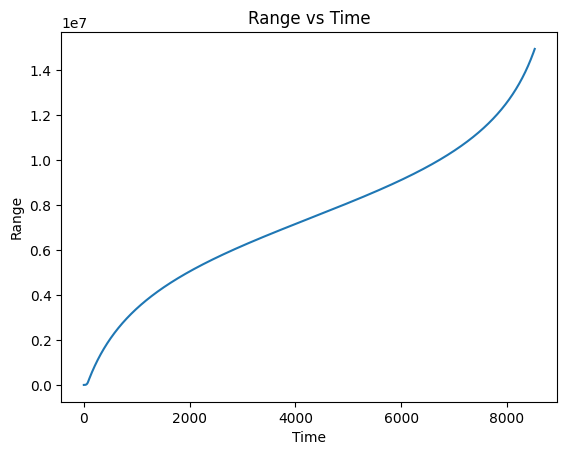

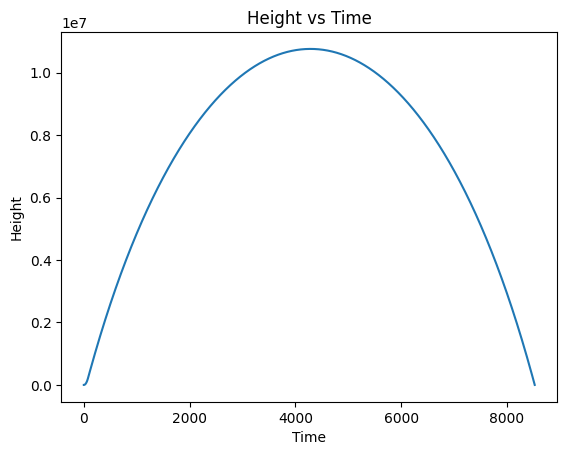

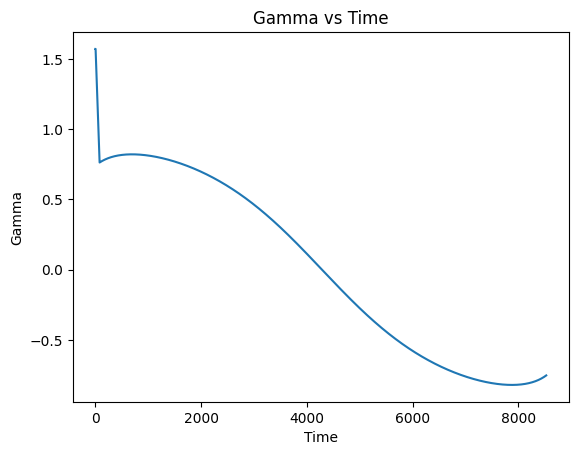

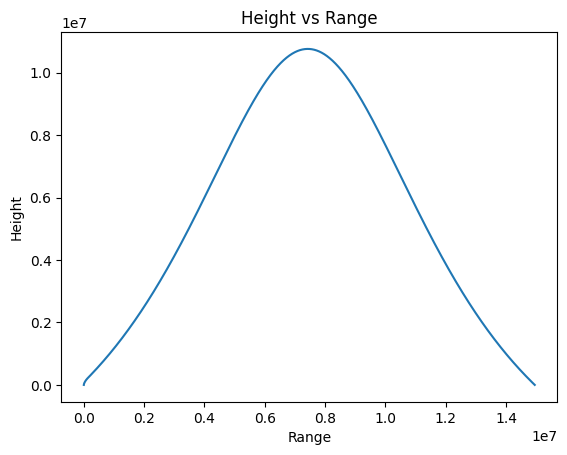

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 500.0
Isp0: 800.0
payload: 10.0
missilediam: 9.9
drymass: 1000.0
thrust0: 69000.0


Stage 1 burnout
Velocity (km/s):  0.29341684758141606
Angle (deg h):  49.165090411402424
Range (km):  0.08853961476038598
Time (sec):  5.799999999999996
Final results: 
Range (km):  9.96260139591253
Apogee (km):  4.053272887993077
Time to target (sec):  57.300000000000544




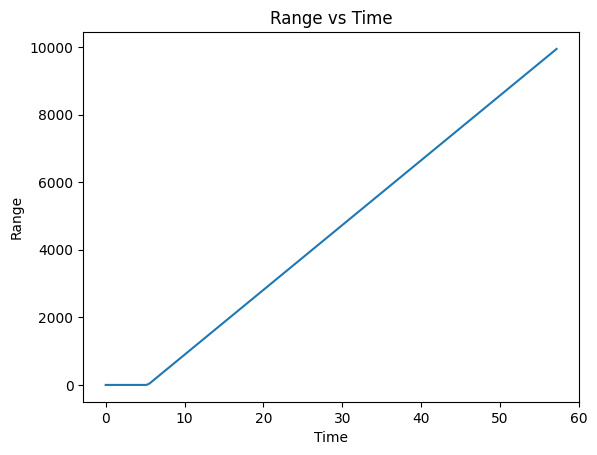

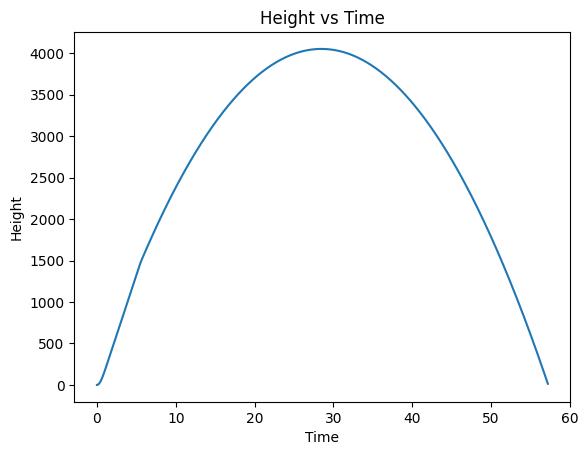

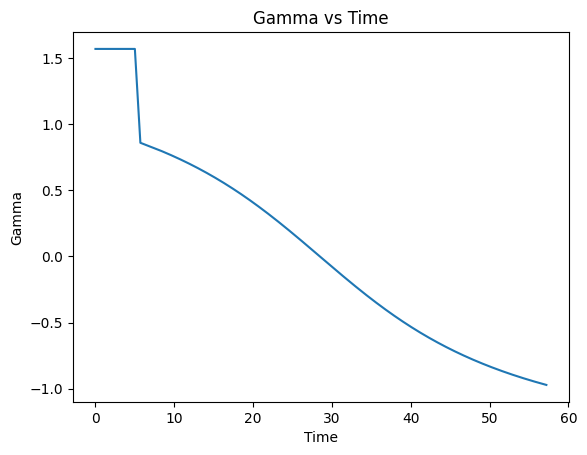

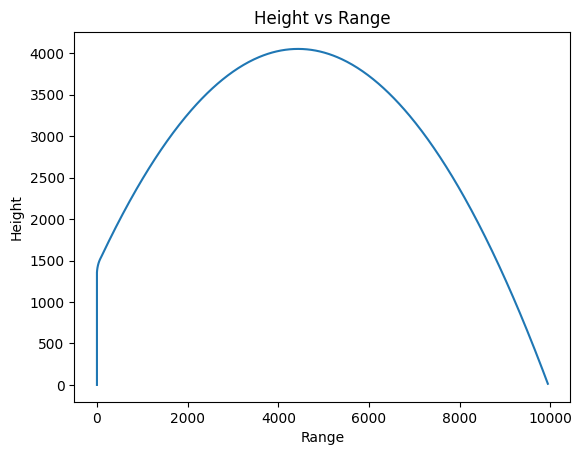

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4955.276827203593
Isp0: 229.30418552044856
payload: 148.5714272373912
missilediam: 2.4438418511479374
drymass: 2815.837920666122
thrust0: 12061.224012022114


Stage 1 burnout
Velocity (km/s):  0.9584338444264298
Angle (deg h):  43.65504524863587
Range (km):  16.715706309266235
Time (sec):  94.19999999999892
Final results: 
Range (km):  134.429973444057
Apogee (km):  50.0299509541895
Time to target (sec):  265.1999999999918




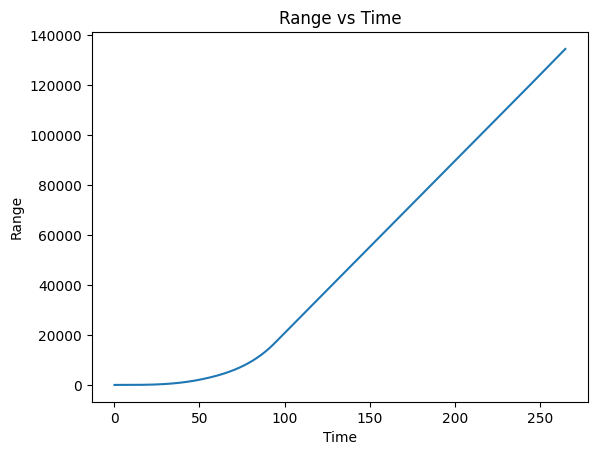

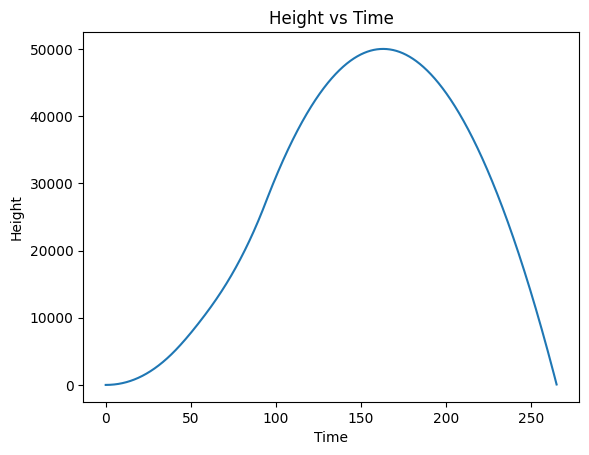

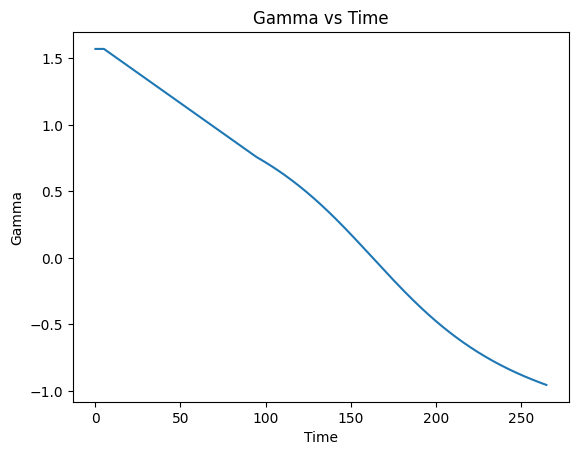

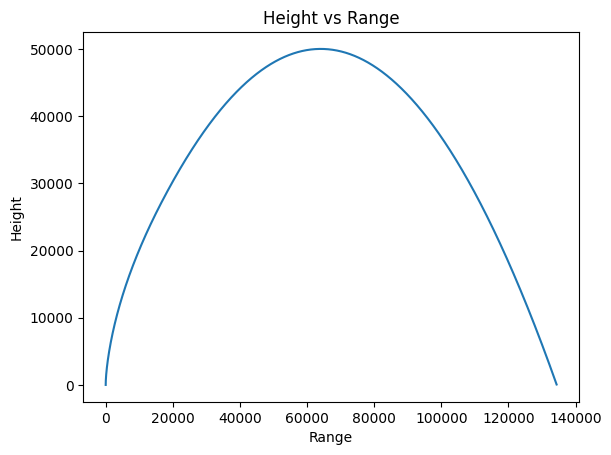

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5508.671156559125
Isp0: 748.4742493590624
payload: 1248.6703792094022
missilediam: 3.845060818975933
drymass: 2491.965428574311
thrust0: 40651.9916413075


Stage 1 burnout
Velocity (km/s):  5.192447713338649
Angle (deg h):  43.658272610993684
Range (km):  92.8446847274228
Time (sec):  101.49999999999851
Final results: 
Range (km):  3793.165848799651
Apogee (km):  1151.1566844450363
Time to target (sec):  1313.299999999901




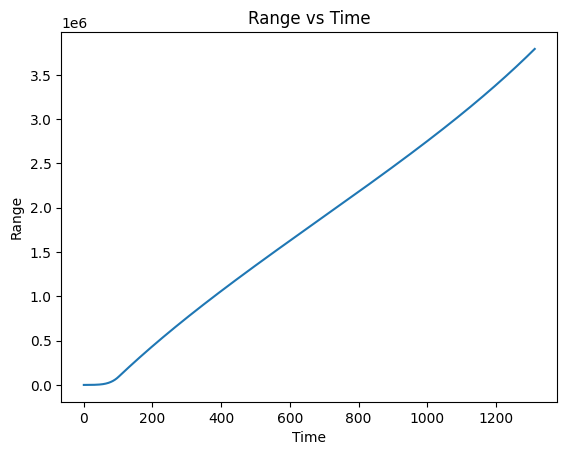

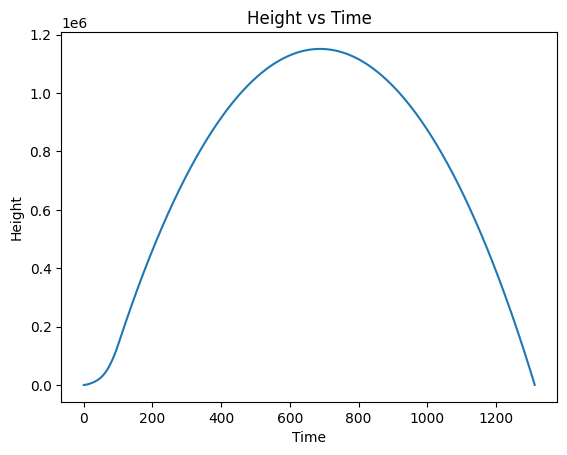

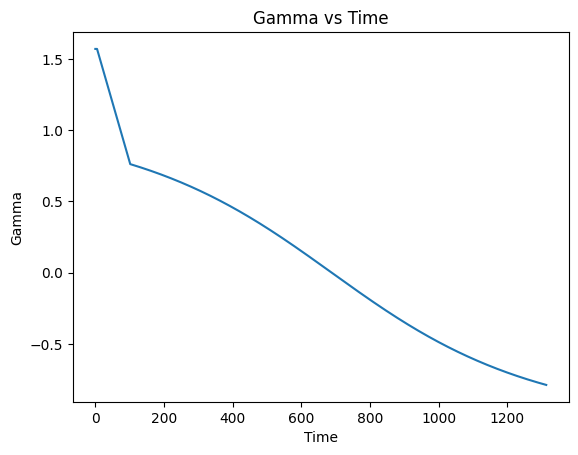

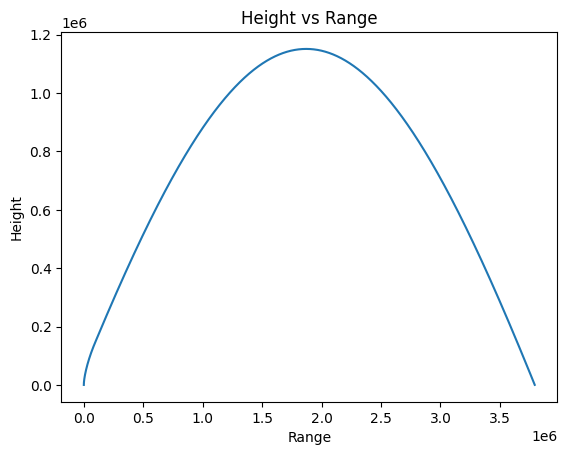

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4810.151285282977
Isp0: 253.12448518163802
payload: 2039.5022648679608
missilediam: 1.2806185249398185
drymass: 1695.021825273066
thrust0: 35267.761876158125


Stage 1 burnout
Velocity (km/s):  1.5780241479002688
Angle (deg h):  43.66305344192381
Range (km):  11.127485854714212
Time (sec):  34.60000000000022
Final results: 
Range (km):  290.12701857216365
Apogee (km):  82.38275519937366
Time to target (sec):  282.6999999999958




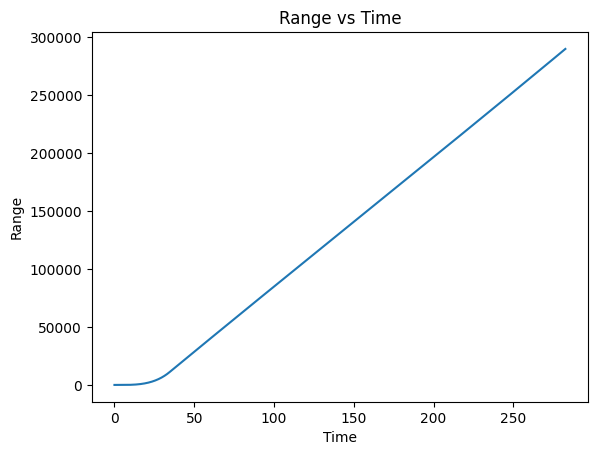

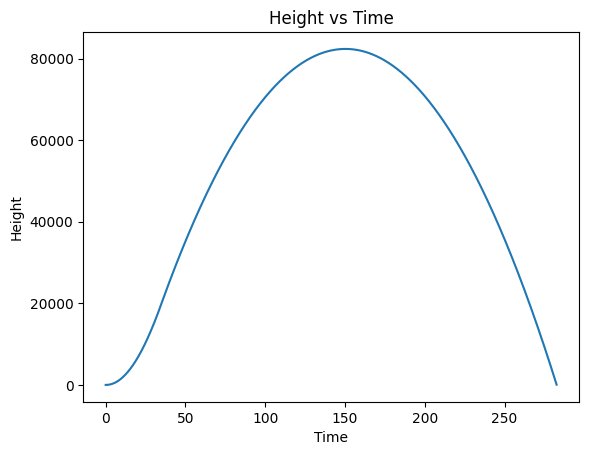

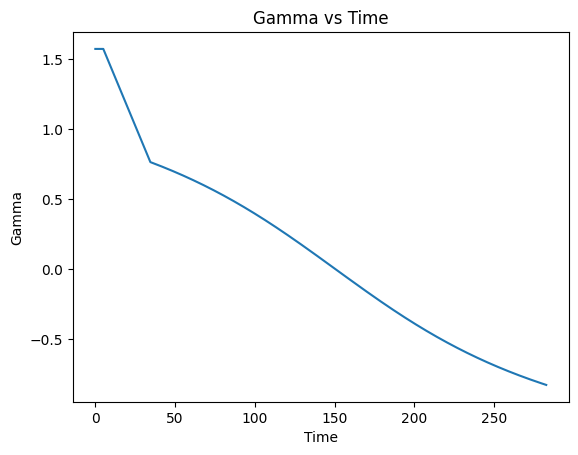

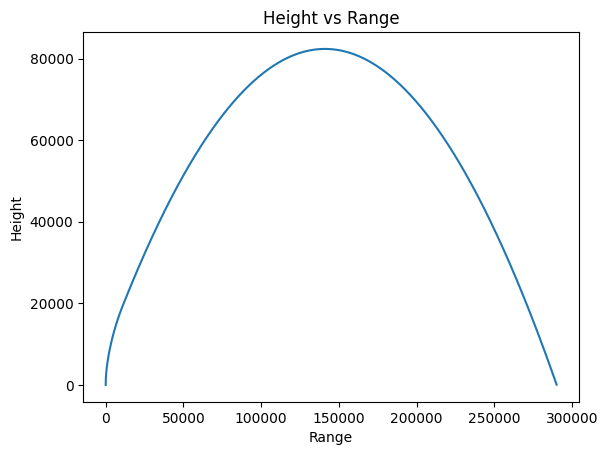

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5184.670587093673
Isp0: 486.0599118904613
payload: 933.7712833425313
missilediam: 1.7882826473784124
drymass: 2172.5897600595104
thrust0: 34939.02673230805


Stage 1 burnout
Velocity (km/s):  3.9383823739287878
Angle (deg h):  43.66217673965059
Range (km):  54.51618247498853
Time (sec):  72.20000000000017
Final results: 
Range (km):  1975.348831126812
Apogee (km):  565.1382953956401
Time to target (sec):  820.400000000118




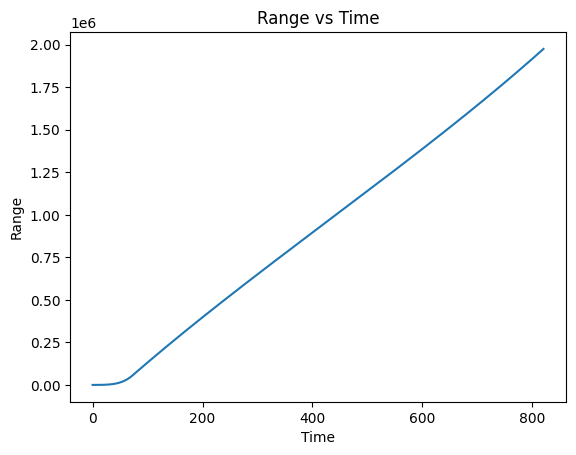

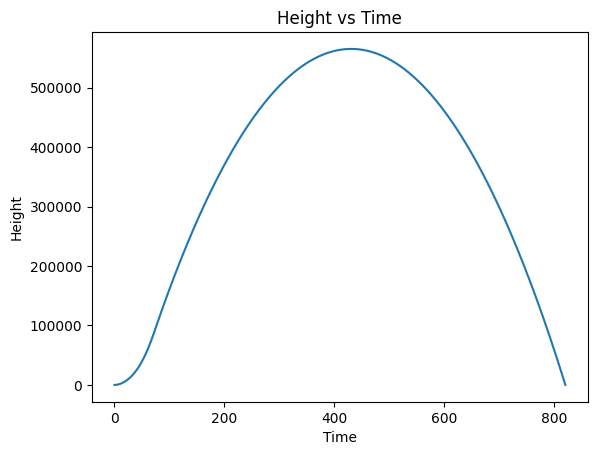

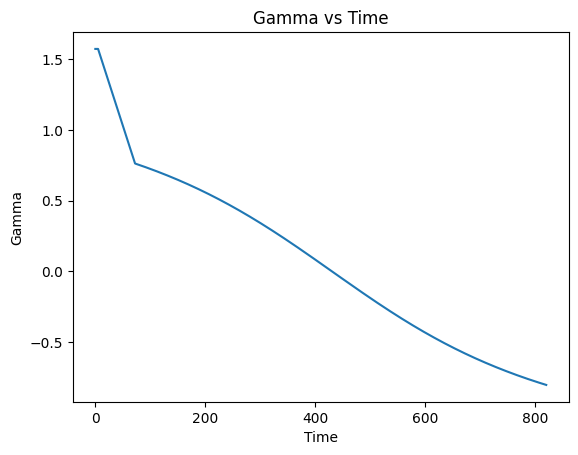

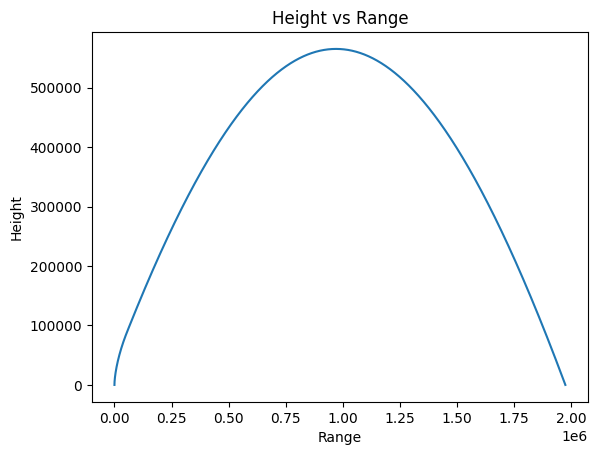

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 2964.267533735038
Isp0: 561.1258344179851
payload: 1916.977991007741
missilediam: 6.768241495093946
drymass: 2108.1633548755044
thrust0: 11914.482475687984


Stage 1 burnout
Velocity (km/s):  0.4728662317204335
Angle (deg h):  43.652694165109644
Range (km):  14.371147727963022
Time (sec):  139.59999999999636
Final results: 
Range (km):  53.38226631587605
Apogee (km):  31.594320388614506
Time to target (sec):  253.99999999998985




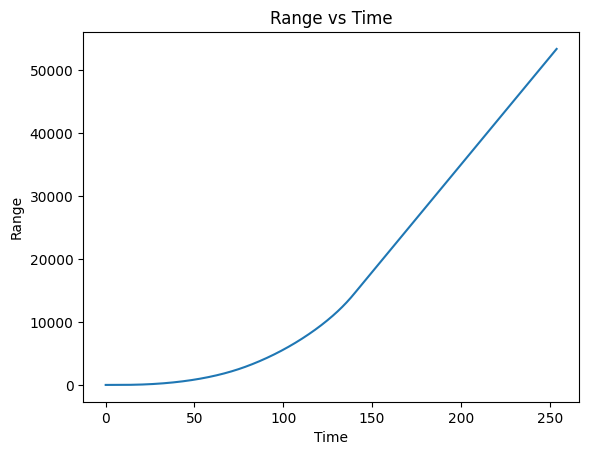

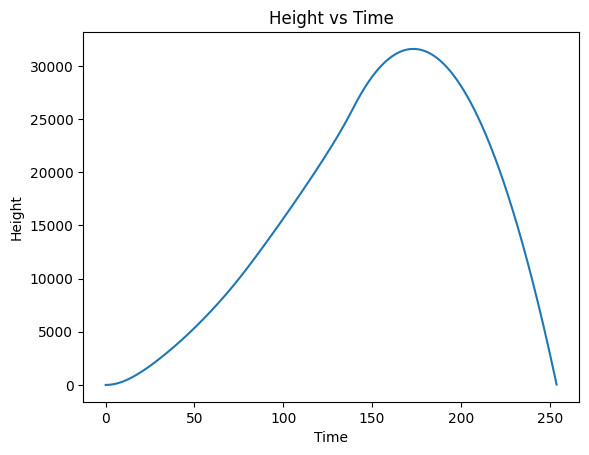

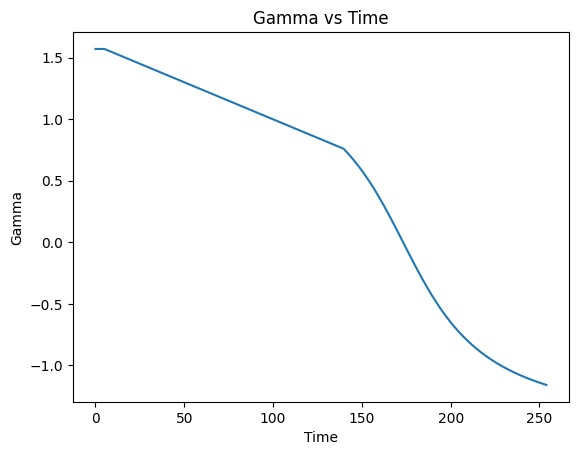

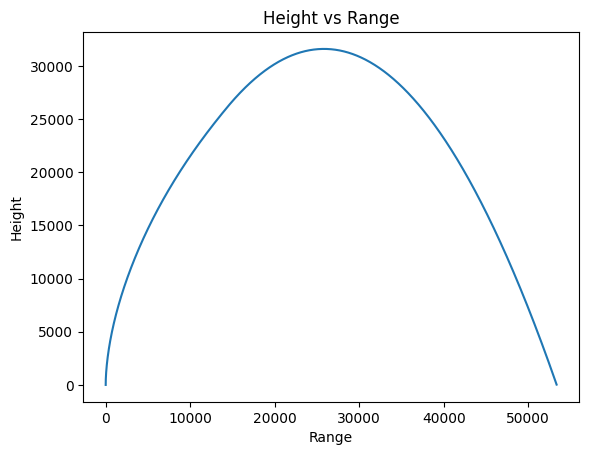

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5703.170101518729
Isp0: 262.315460364106
payload: 1035.8526583239875
missilediam: 6.318594691605842
drymass: 1779.7720789956347
thrust0: 39163.65335772717


Stage 1 burnout
Velocity (km/s):  0.38676338651187725
Angle (deg h):  43.6850746177878
Range (km):  4.340824322477332
Time (sec):  38.20000000000027
Final results: 
Range (km):  26.679404045897726
Apogee (km):  13.468432000250015
Time to target (sec):  118.19999999999756




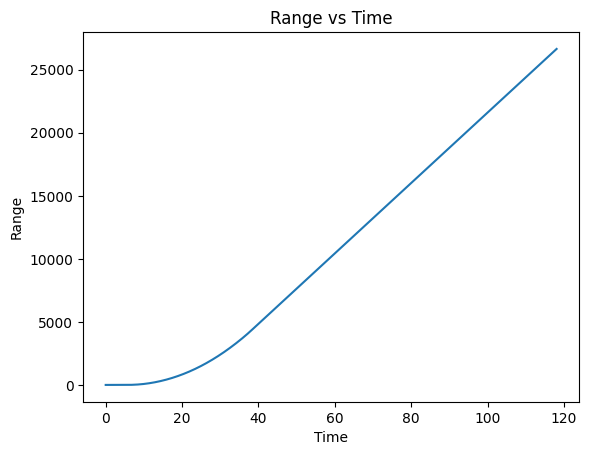

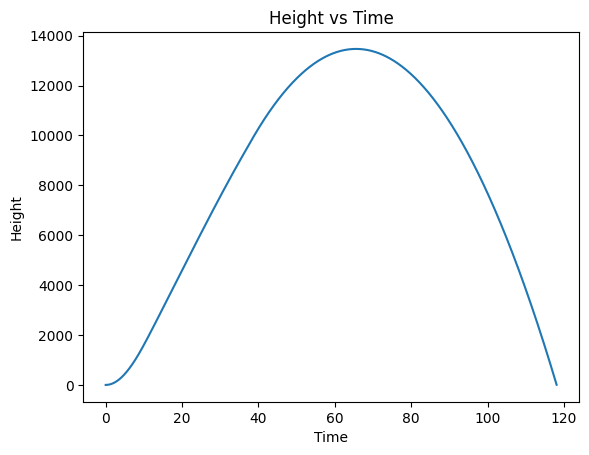

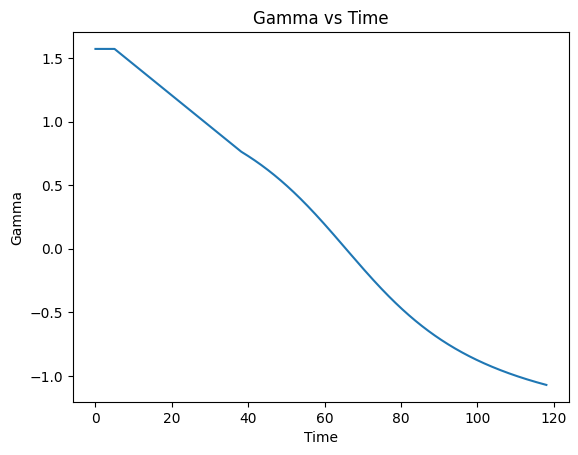

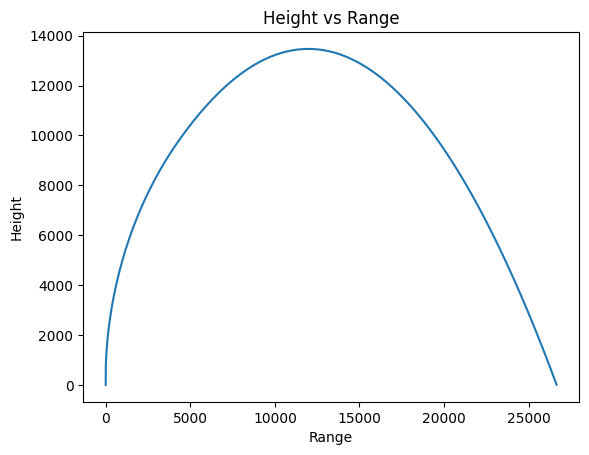

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 986.5945333131797
Isp0: 419.1717676014385
payload: 2145.1433667783526
missilediam: 6.23316339973297
drymass: 1614.3006745523057
thrust0: 11649.71922435202


Stage 1 burnout
Velocity (km/s):  0.21719226874917538
Angle (deg h):  43.614464340735964
Range (km):  2.1384623645289818
Time (sec):  35.500000000000234
Final results: 
Range (km):  9.88587298974888
Apogee (km):  5.65403198994717
Time to target (sec):  84.79999999999946




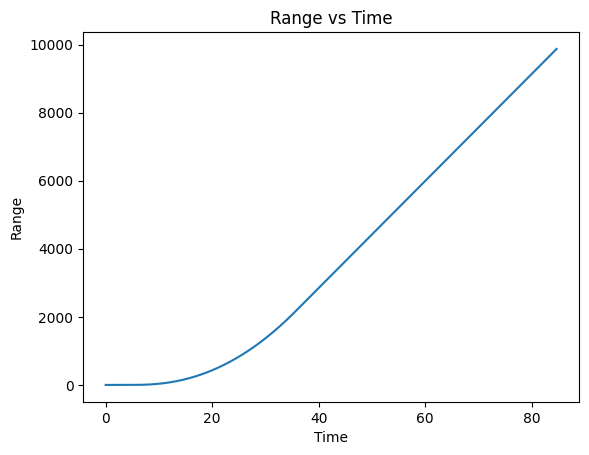

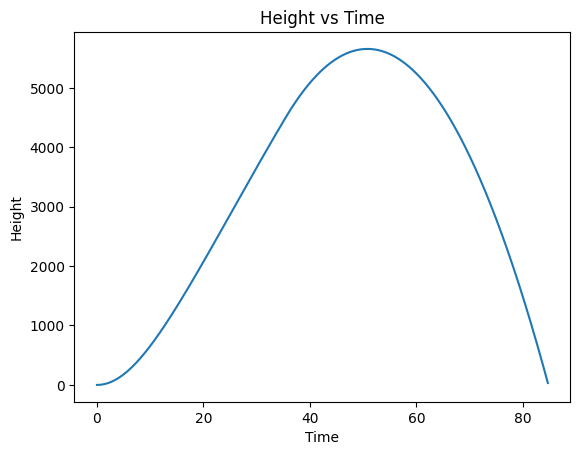

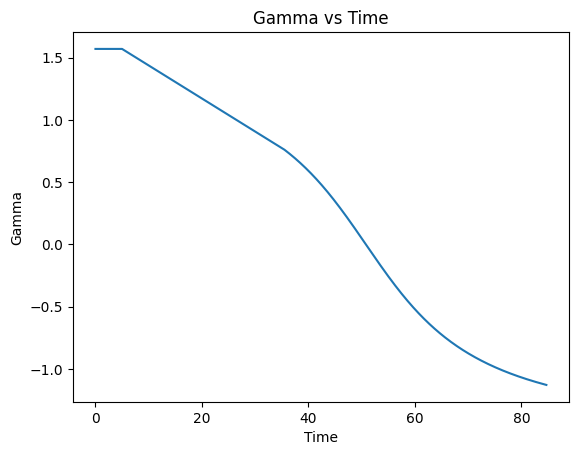

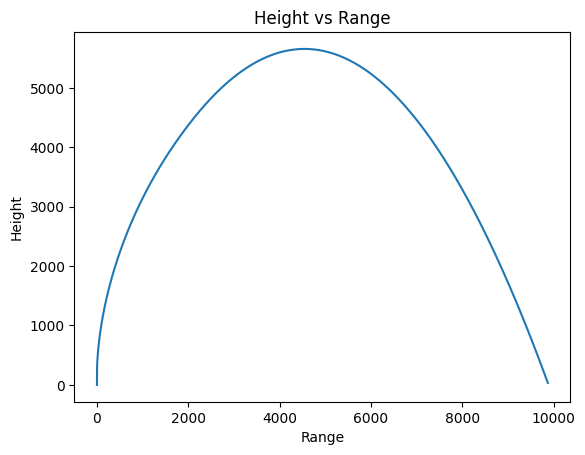

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 6857.584309000766
Isp0: 164.86083508214705
payload: 1155.7354209161388
missilediam: 0.1983792978015051
drymass: 1533.0579300568068
thrust0: 66141.77921729762


Stage 1 burnout
Velocity (km/s):  1.8998010468312103
Angle (deg h):  43.986245284835576
Range (km):  5.606574844159375
Time (sec):  17.099999999999977
Final results: 
Range (km):  396.26853380040933
Apogee (km):  103.95431198540712
Time to target (sec):  308.8000000000017




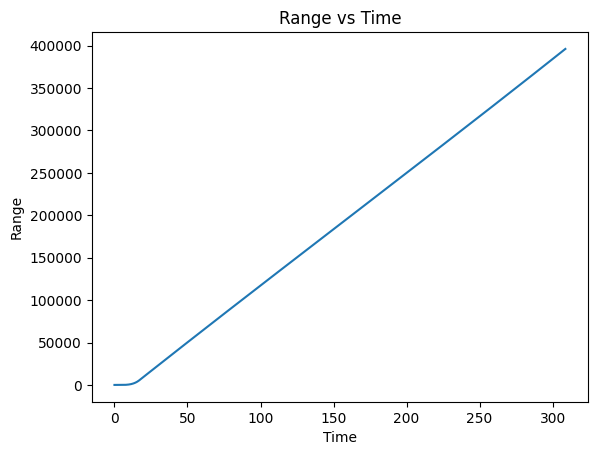

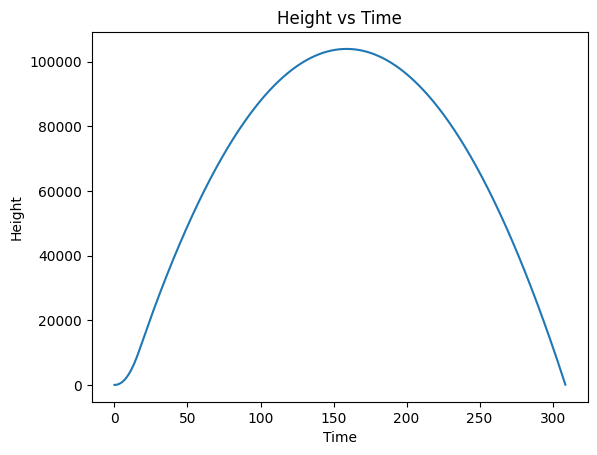

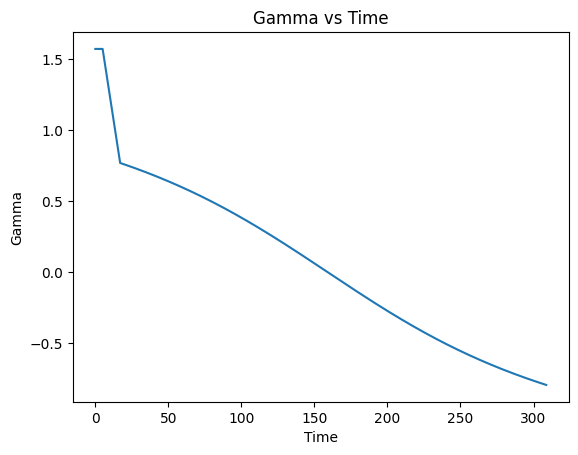

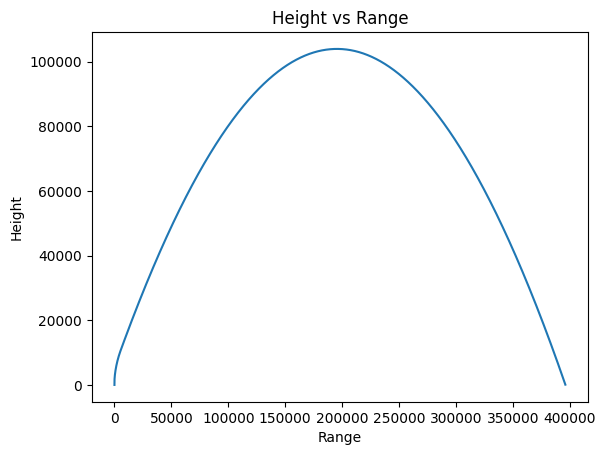

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4290.639292727881
Isp0: 347.0872473005788
payload: 508.89981015376907
missilediam: 6.53478167740838
drymass: 2751.589287091968
thrust0: 43082.34985812392


Stage 1 burnout
Velocity (km/s):  0.37346453238250354
Angle (deg h):  43.647427970899884
Range (km):  3.882947176972122
Time (sec):  34.60000000000022
Final results: 
Range (km):  24.686874694432557
Apogee (km):  12.515588564760657
Time to target (sec):  111.69999999999793




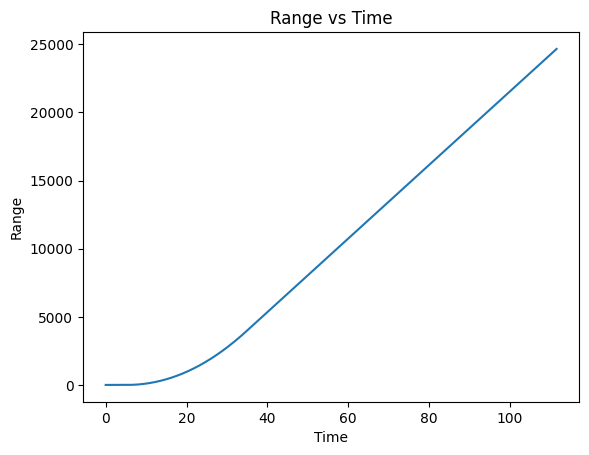

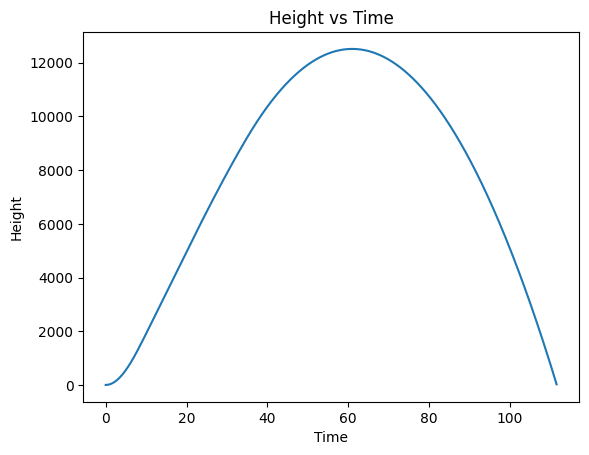

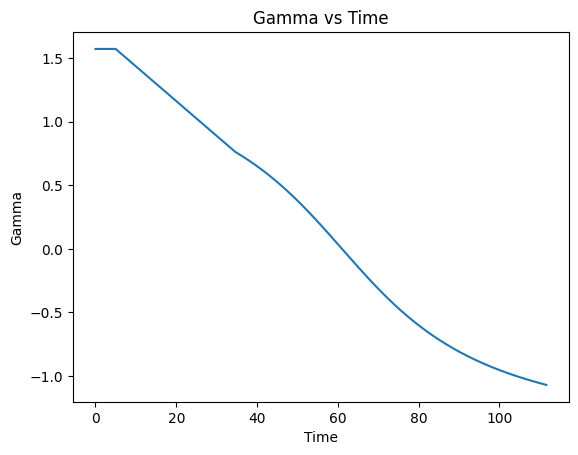

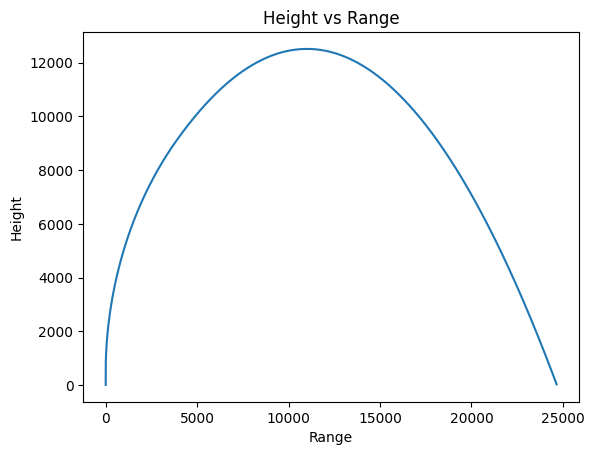

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5649.727693860298
Isp0: 497.0807753358445
payload: 964.4751081730423
missilediam: 9.072267135781313
drymass: 2476.4730258958134
thrust0: 14011.926141258298


Stage 1 burnout
Velocity (km/s):  1.2293734768115407
Angle (deg h):  43.62542578388565
Range (km):  31.441489170222948
Time (sec):  200.4999999999929
Final results: 
Range (km):  229.02479486655656
Apogee (km):  86.44797460718415
Time to target (sec):  425.3000000000282




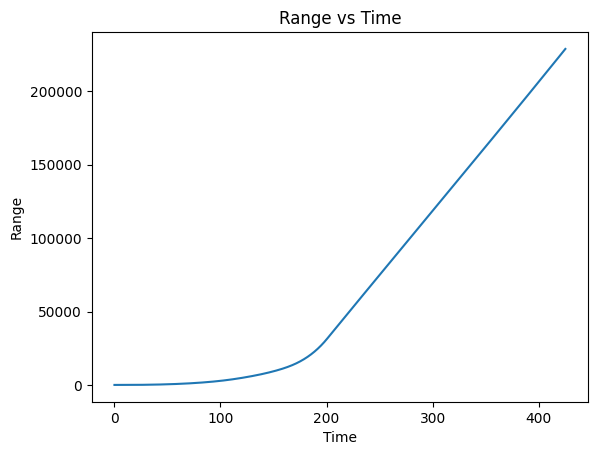

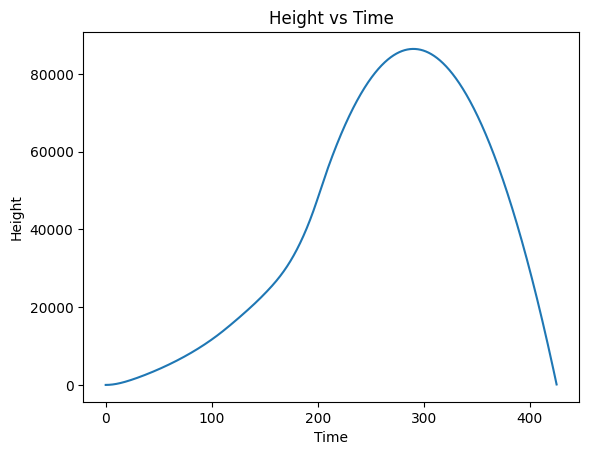

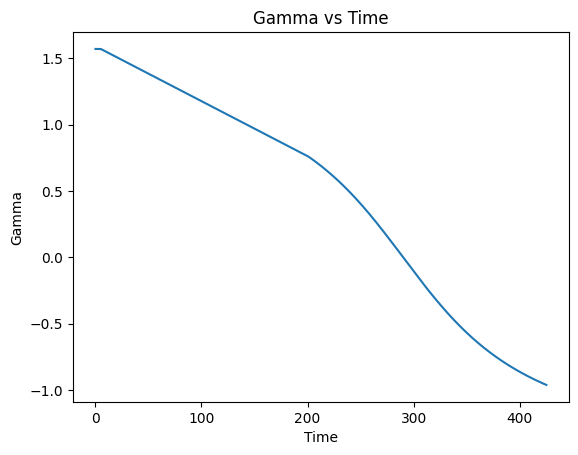

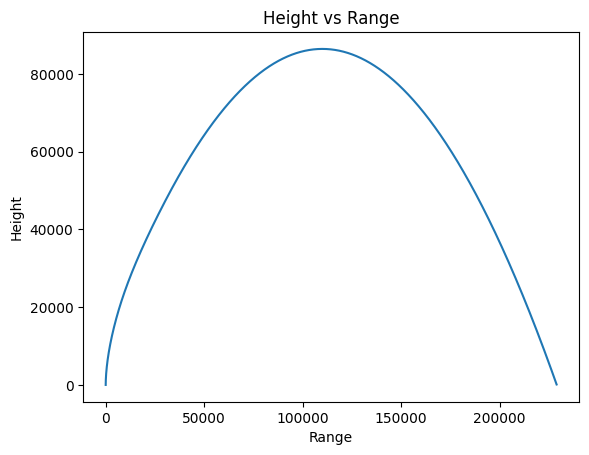

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5189.6508735191
Isp0: 180.97684820069344
payload: 1150.1368468150908
missilediam: 3.318830744912615
drymass: 2755.382493764537
thrust0: 33628.487629244366


Stage 1 burnout
Velocity (km/s):  0.6231830261822652
Angle (deg h):  43.64435503098925
Range (km):  4.026533862655635
Time (sec):  28.00000000000013
Final results: 
Range (km):  50.97656900896488
Apogee (km):  17.602983357630425
Time to target (sec):  132.39999999999677




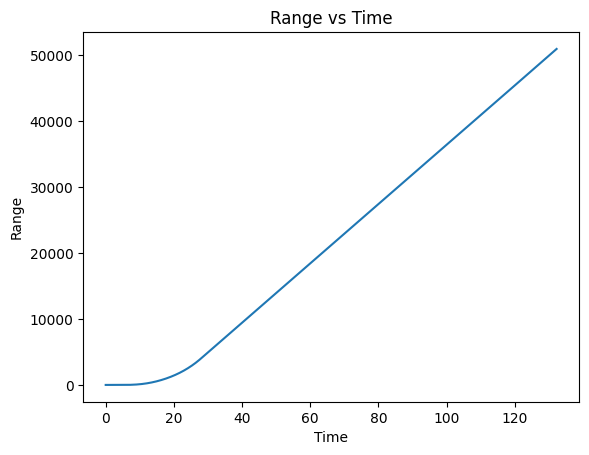

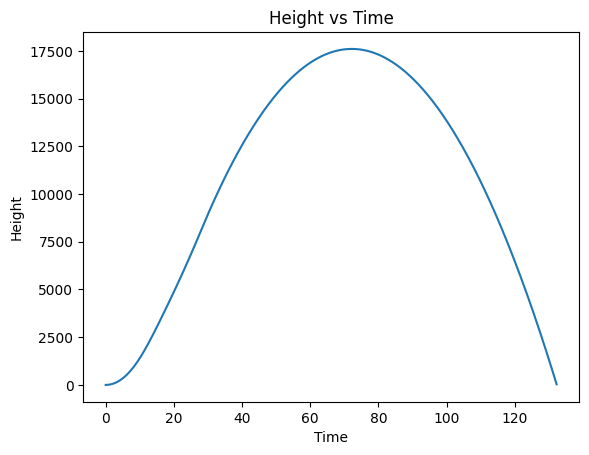

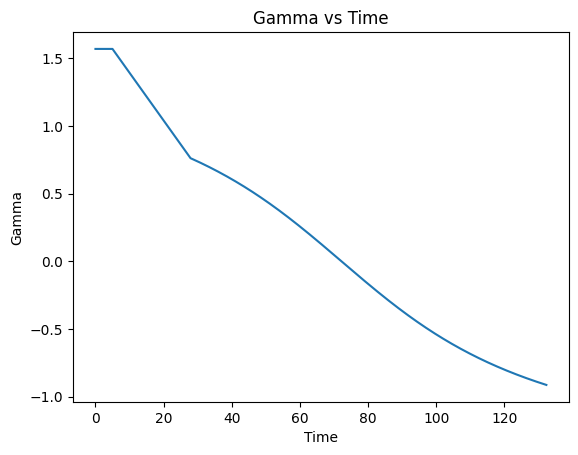

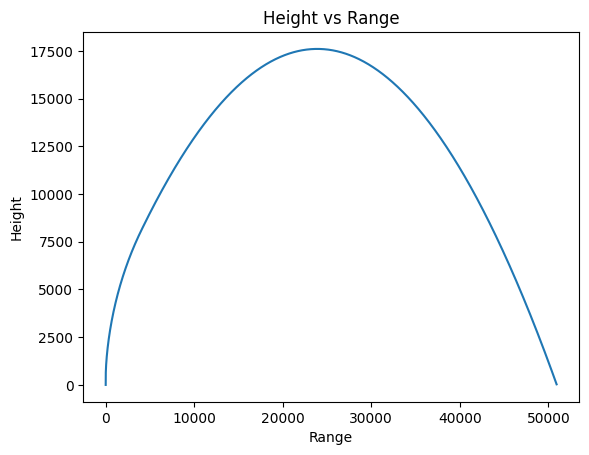

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4535.066246251214
Isp0: 317.9649935194956
payload: 1738.120258701008
missilediam: 9.109907854333542
drymass: 2092.2943061658484
thrust0: 10205.328788095076


Stage 1 burnout
Velocity (km/s):  0.22466815392421183
Angle (deg h):  43.50398864206369
Range (km):  7.3560152638343475
Time (sec):  141.29999999999626
Final results: 
Range (km):  18.71636952822657
Apogee (km):  14.179733545117935
Time to target (sec):  211.0999999999923




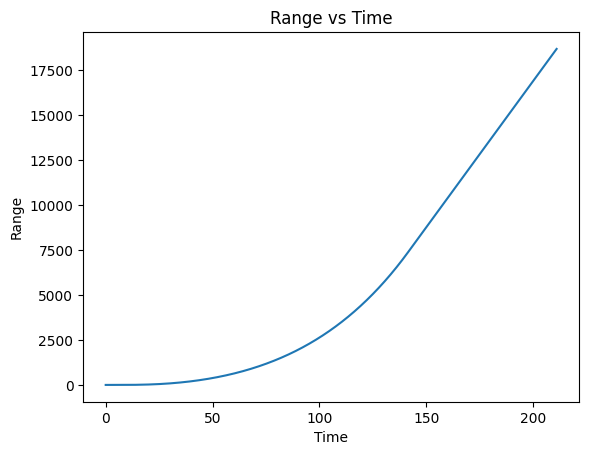

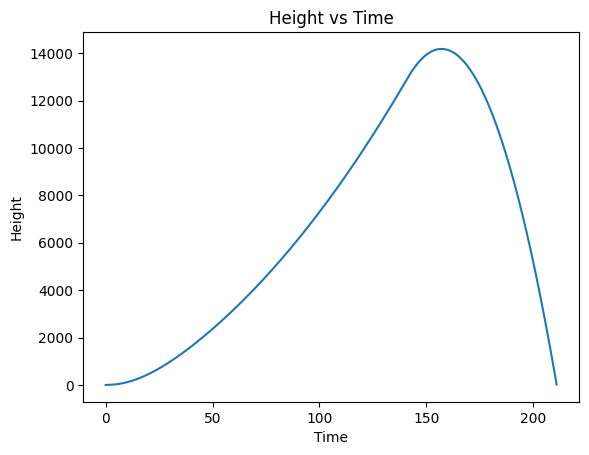

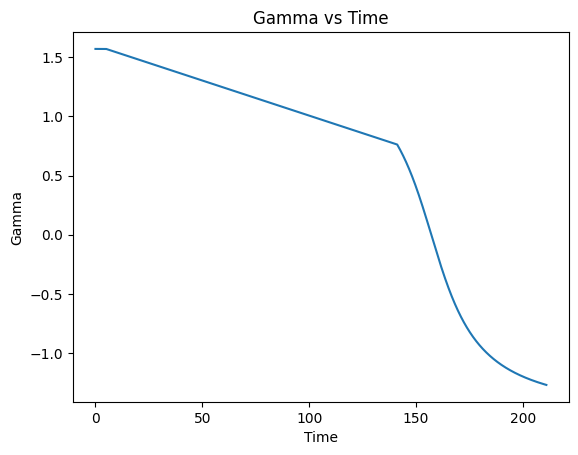

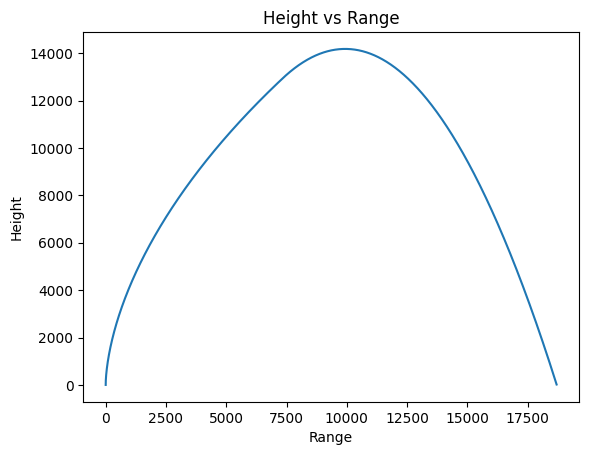

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 653.6410853029569
Isp0: 101.65458512556202
payload: 1325.9605558802616
missilediam: 5.11097900262506
drymass: 1618.225143475335
thrust0: 26778.7693007902


Stage 1 burnout
Velocity (km/s):  0.16495655624075428
Angle (deg h):  90.0
Range (km):  1.261497911192736e-17
Time (sec):  2.5000000000000018
Final results: 
Range (km):  7.10578280200927e-16
Apogee (km):  1.5937735330848048
Time to target (sec):  37.40000000000026




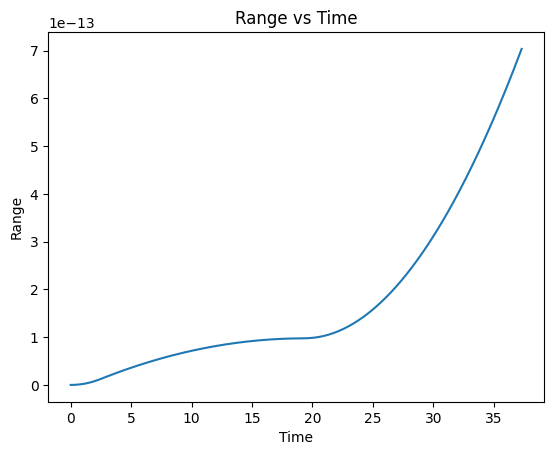

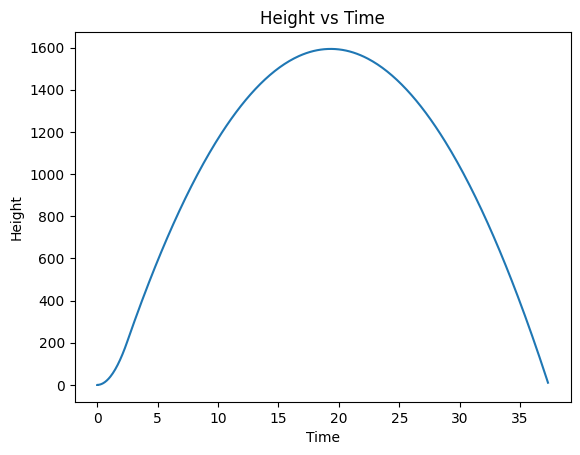

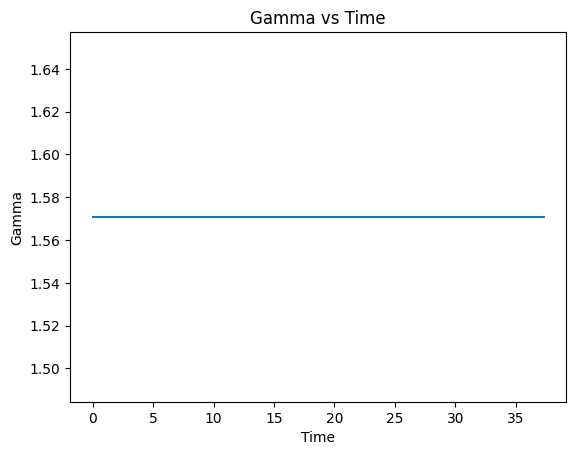

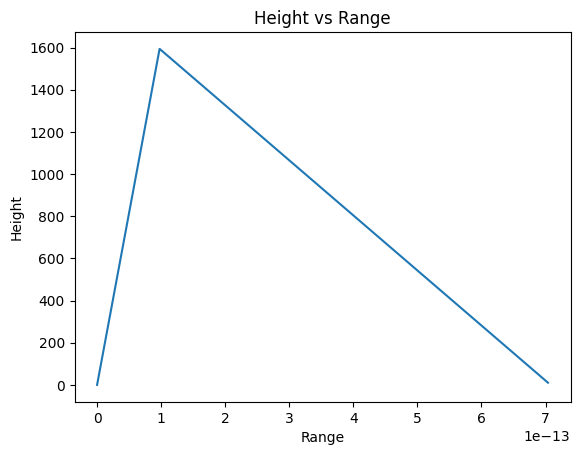

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 6578.890830054078
Isp0: 527.4255327838212
payload: 1641.7440983025042
missilediam: 1.451459301629299
drymass: 2585.1734761687585
thrust0: 68907.37122404741


Stage 1 burnout
Velocity (km/s):  4.379511362139401
Angle (deg h):  43.701389999653394
Range (km):  43.740469878200805
Time (sec):  50.400000000000446
Final results: 
Range (km):  2451.224197955736
Apogee (km):  693.1045075751275
Time to target (sec):  916.6000000001399




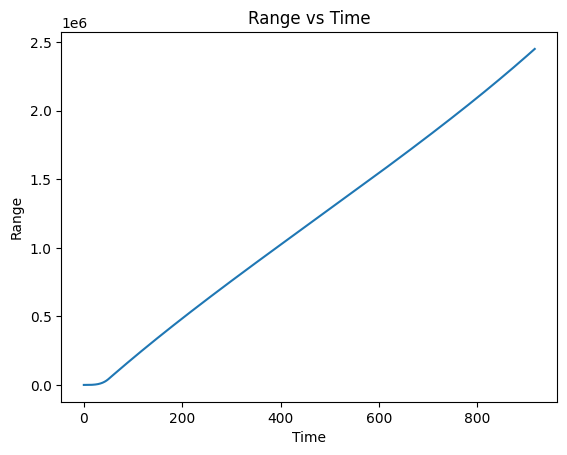

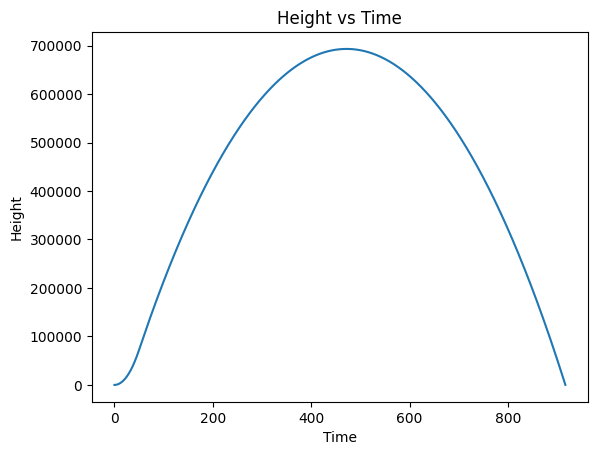

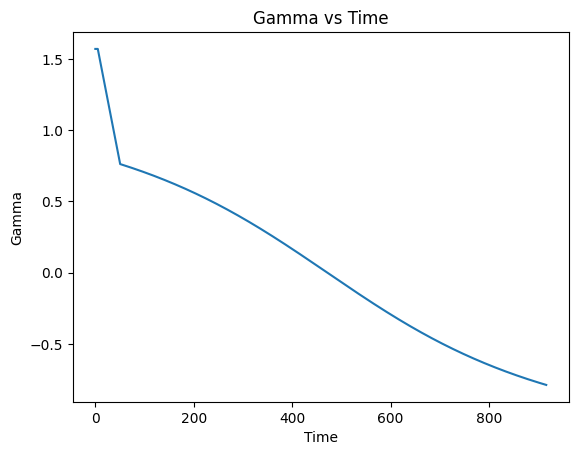

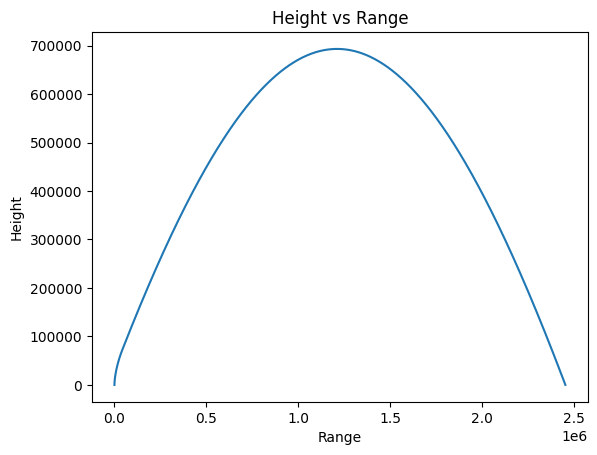

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4797.41400783953
Isp0: 545.1920294911938
payload: 713.676023617654
missilediam: 9.12618679430243
drymass: 2399.480909454178
thrust0: 58935.40196361371


Stage 1 burnout
Velocity (km/s):  0.3752672004610345
Angle (deg h):  43.63637702534247
Range (km):  5.000581237080566
Time (sec):  44.40000000000036
Final results: 
Range (km):  27.36837315652905
Apogee (km):  15.2141170227383
Time to target (sec):  126.89999999999706




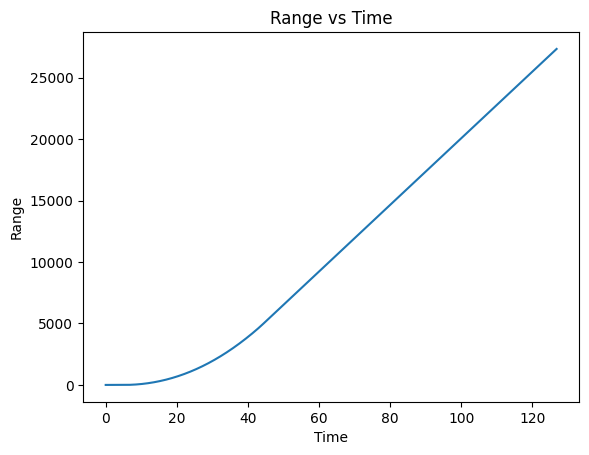

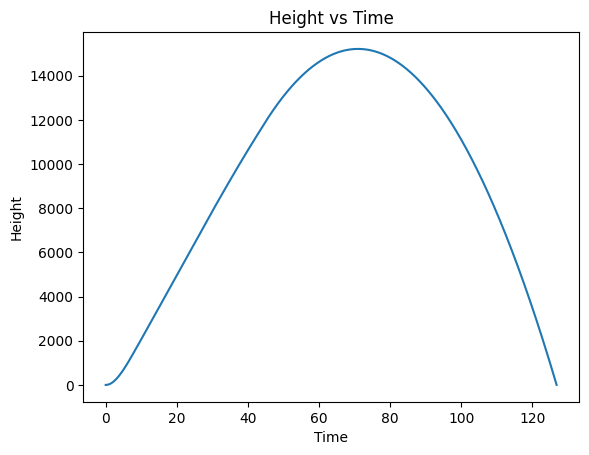

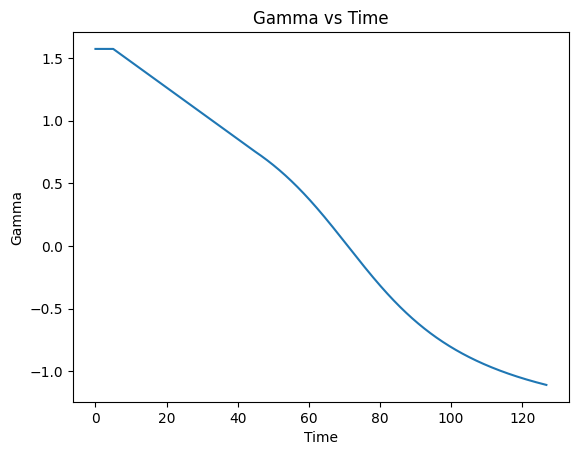

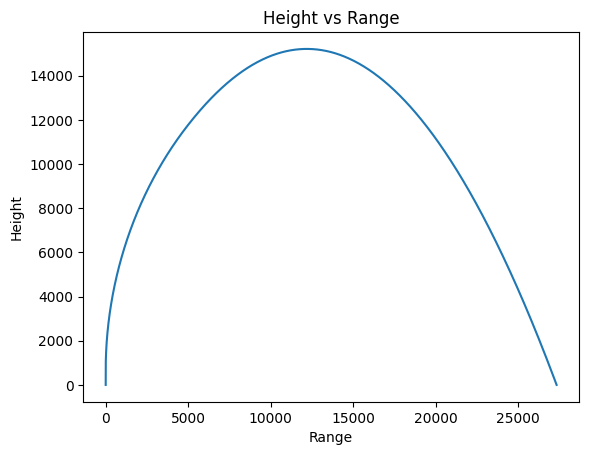

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5954.847581697014
Isp0: 660.8631016366433
payload: 517.5723245827248
missilediam: 4.672799246350527
drymass: 1647.9136278685442
thrust0: 33843.81608498117


Stage 1 burnout
Velocity (km/s):  6.669165229788616
Angle (deg h):  43.68231629745848
Range (km):  118.49695137280958
Time (sec):  116.29999999999767
Final results: 
Range (km):  7101.183327285413
Apogee (km):  2487.806719955589
Time to target (sec):  2328.199999998978




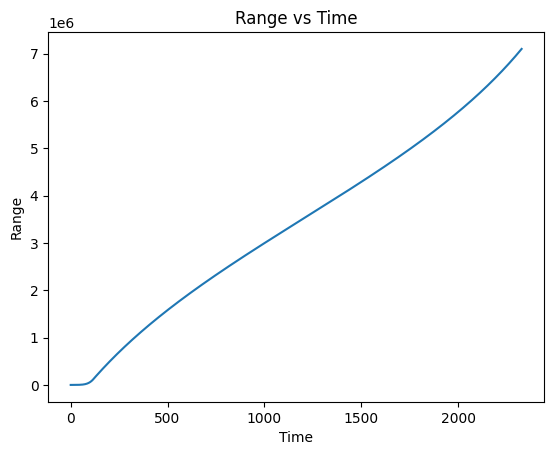

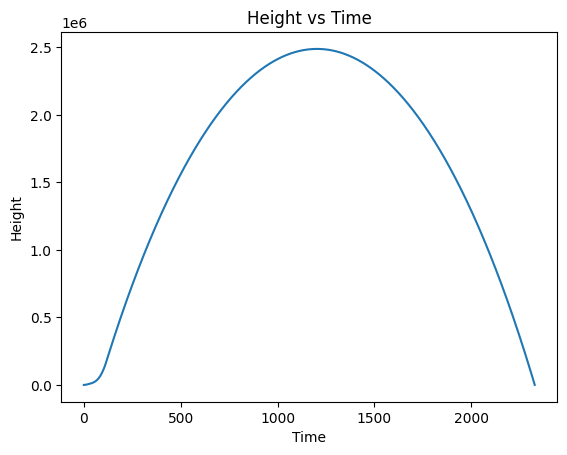

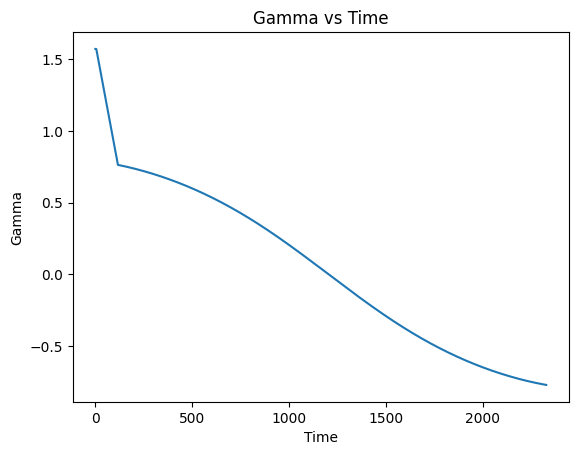

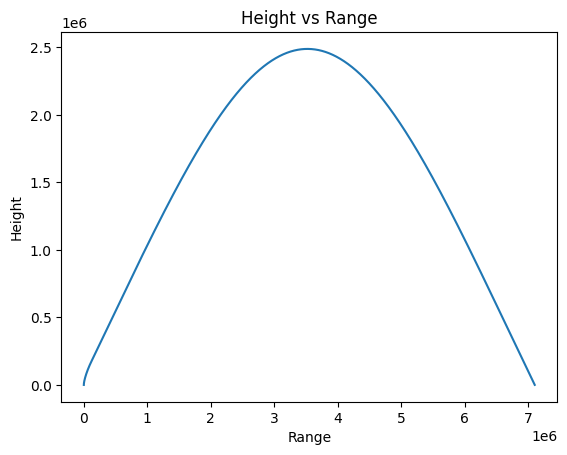

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 1285.193646853762
Isp0: 799.8201143593927
payload: 944.610938873404
missilediam: 9.805283855760136
drymass: 2671.016588870466
thrust0: 11442.983163813591


Stage 1 burnout
Velocity (km/s):  0.19794027811364856
Angle (deg h):  43.46247368859313
Range (km):  4.958502021200789
Time (sec):  89.89999999999917
Final results: 
Range (km):  13.799976796583254
Apogee (km):  11.10067962702926
Time to target (sec):  151.49999999999568




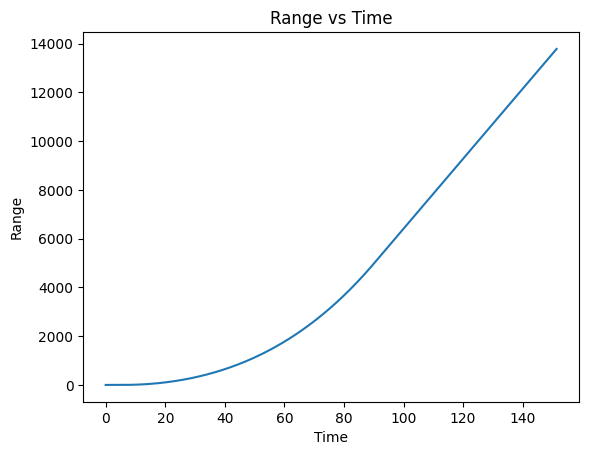

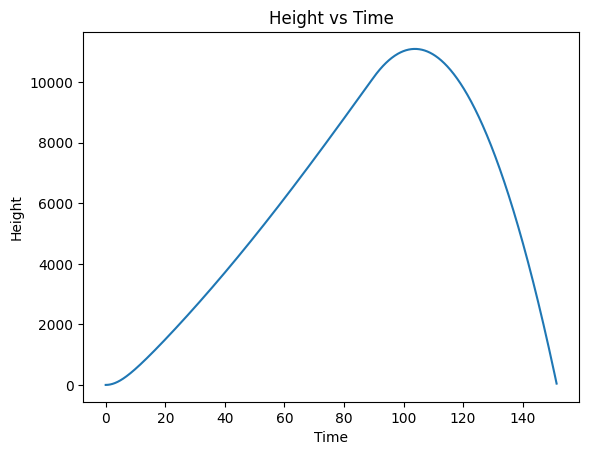

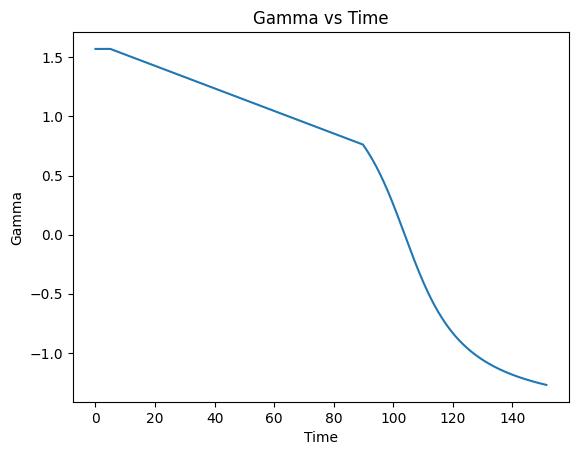

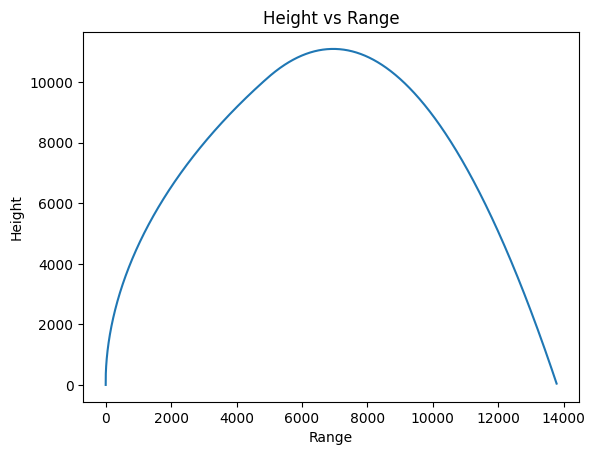

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 532.1006212932733
Isp0: 520.886889046709
payload: 2356.8782720978156
missilediam: 1.104738660303708
drymass: 1419.3777848753105
thrust0: 62207.49973082773


Stage 1 burnout
Velocity (km/s):  0.6173267760545383
Angle (deg h):  90.0
Range (km):  8.457323016065363e-17
Time (sec):  4.500000000000001
Final results: 
Range (km):  4.63189448814611e-15
Apogee (km):  20.879522309446887
Time to target (sec):  133.19999999999672




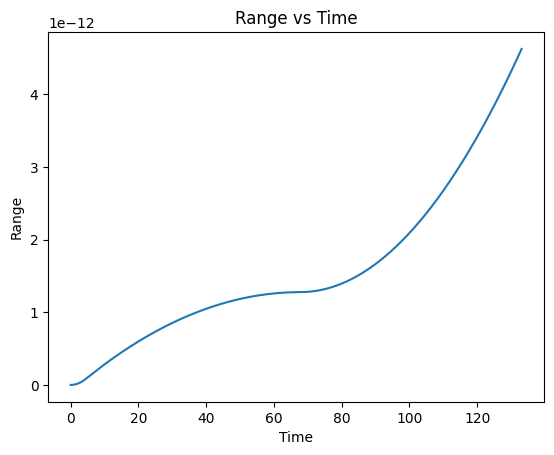

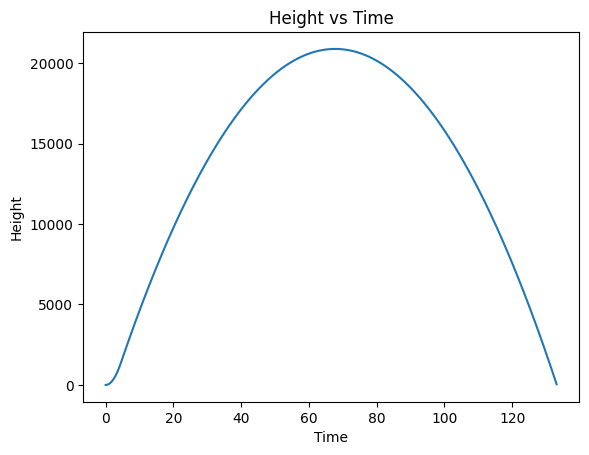

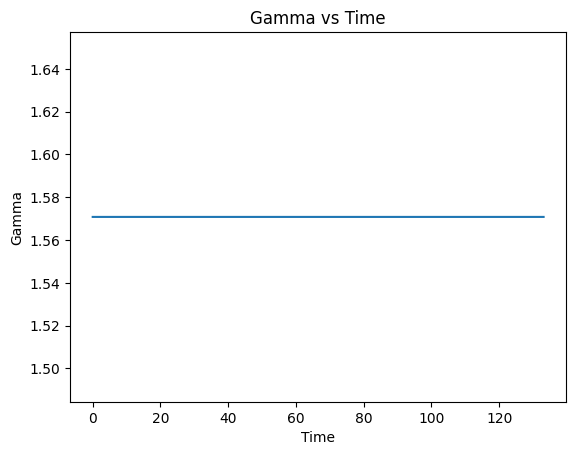

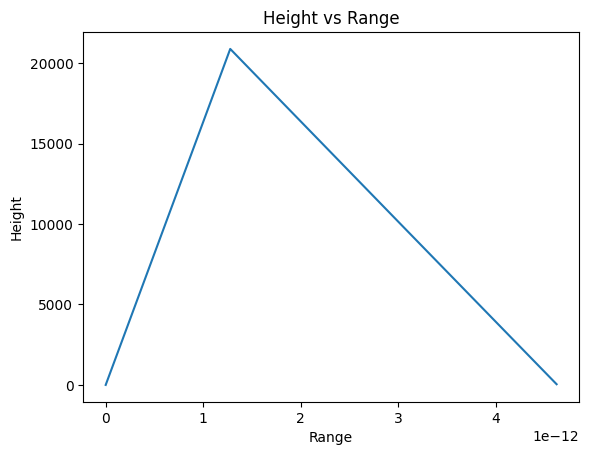

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 2497.7711021218965
Isp0: 371.96226416119816
payload: 1821.3793990469487
missilediam: 6.377991158628436
drymass: 2116.9573262758763
thrust0: 53992.76650693193


Stage 1 burnout
Velocity (km/s):  0.3563052655101711
Angle (deg h):  43.679005118191135
Range (km):  1.607439667240992
Time (sec):  17.199999999999978
Final results: 
Range (km):  18.262220764847534
Apogee (km):  7.608394591087749
Time to target (sec):  81.89999999999962




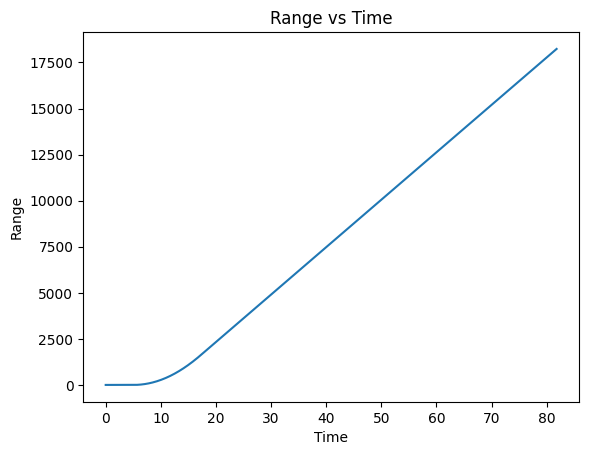

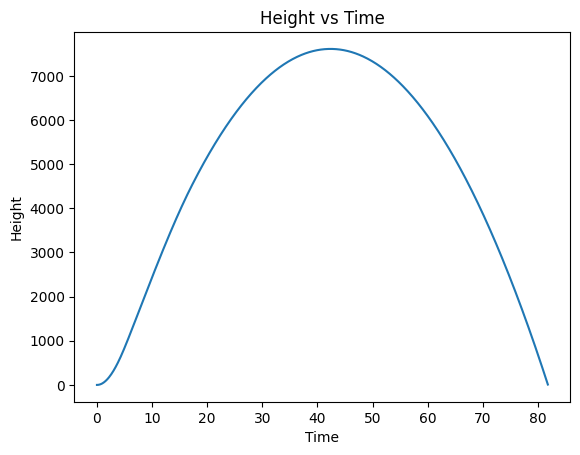

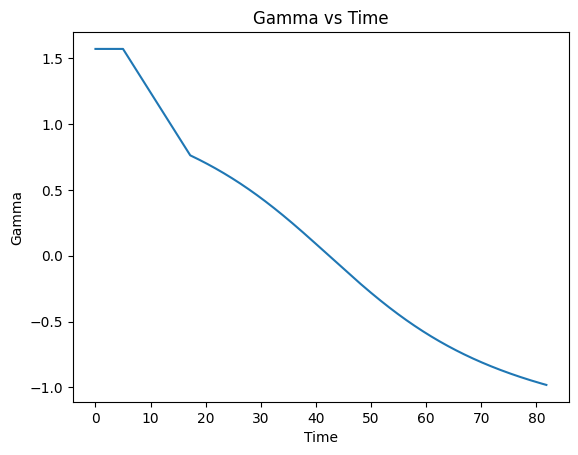

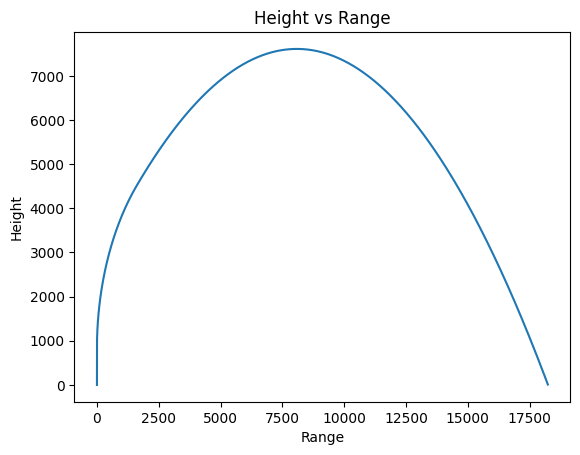

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4545.735249129839
Isp0: 712.9695962400446
payload: 2257.2544482738713
missilediam: 8.237646271148062
drymass: 1000.4019079034214
thrust0: 64517.79865574486


Stage 1 burnout
Velocity (km/s):  0.7161585917773756
Angle (deg h):  43.62926509135339
Range (km):  7.920208795253235
Time (sec):  50.300000000000445
Final results: 
Range (km):  74.3559530832063
Apogee (km):  29.21291754993322
Time to target (sec):  178.99999999999412




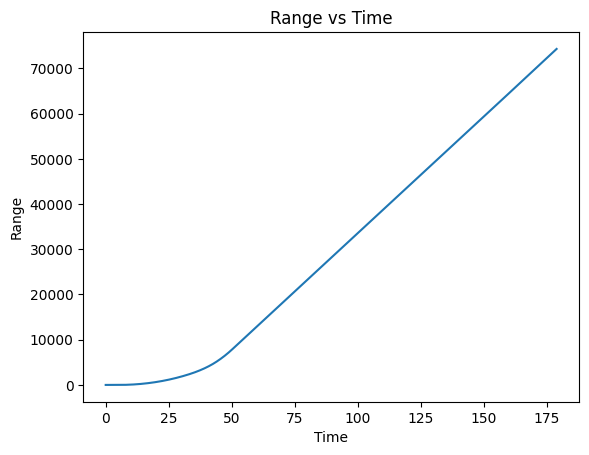

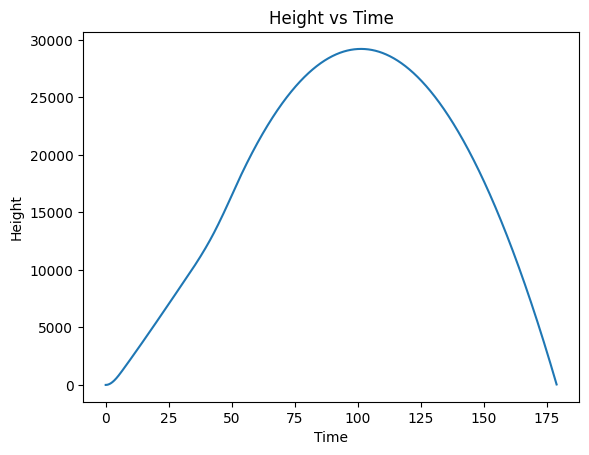

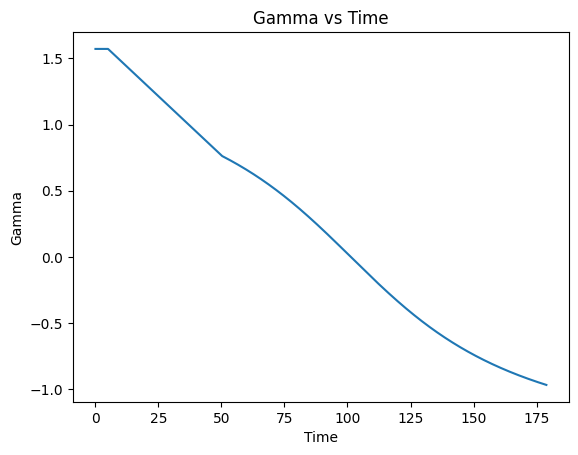

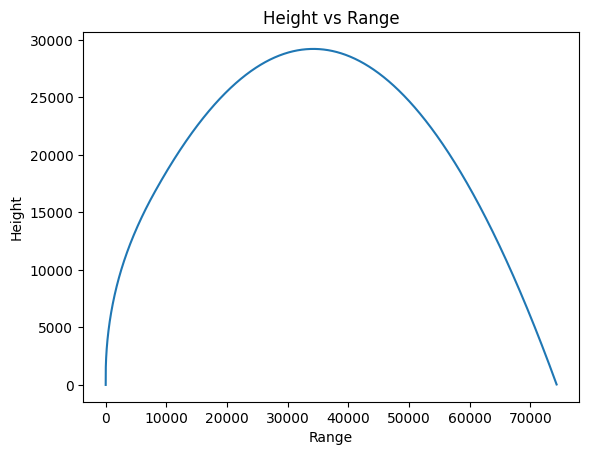

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 3524.342825685325
Isp0: 338.52535841619647
payload: 1604.4490428335837
missilediam: 8.289554962074163
drymass: 2277.8126202990074
thrust0: 38966.65596532312


Stage 1 burnout
Velocity (km/s):  0.3037552847312774
Angle (deg h):  43.683295451946876
Range (km):  2.8155445683230687
Time (sec):  30.60000000000017
Final results: 
Range (km):  16.925201284141977
Apogee (km):  8.955734721211222
Time to target (sec):  94.89999999999888




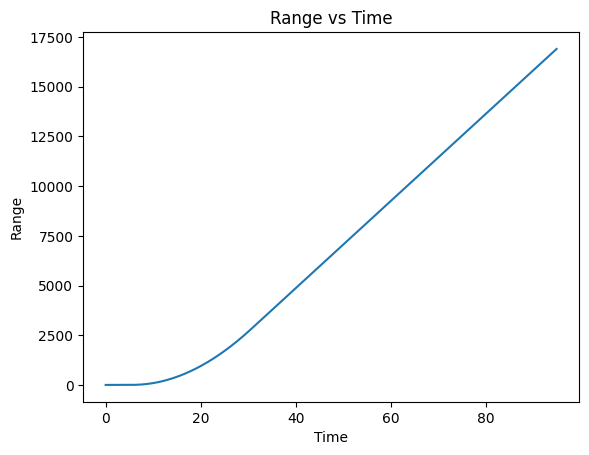

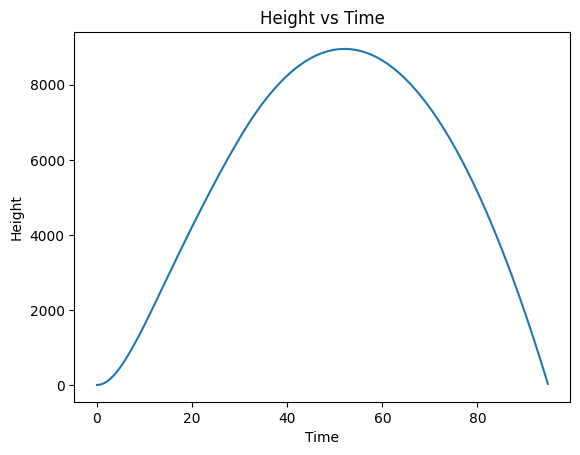

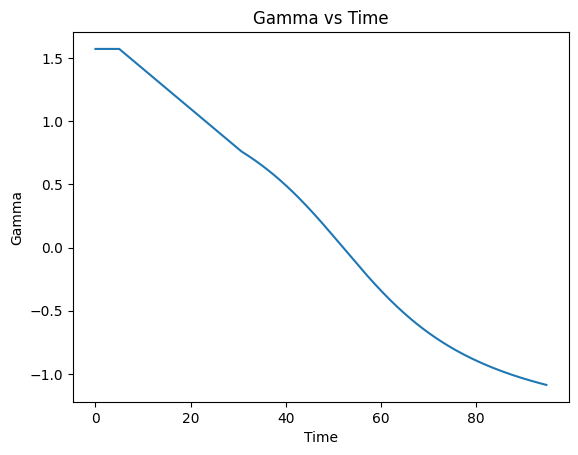

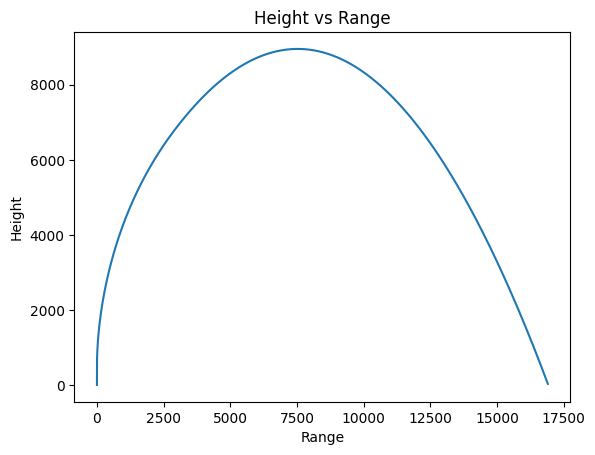

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5572.0775701536495
Isp0: 219.9229141911626
payload: 13.297785748512272
missilediam: 9.866235010326537
drymass: 1242.6023788855484
thrust0: 26031.339983588005


Stage 1 burnout
Velocity (km/s):  0.2685060786101169
Angle (deg h):  43.58271320710212
Range (km):  3.8464252071177345
Time (sec):  47.1000000000004
Final results: 
Range (km):  16.378403328653683
Apogee (km):  10.112265440497941
Time to target (sec):  111.59999999999793




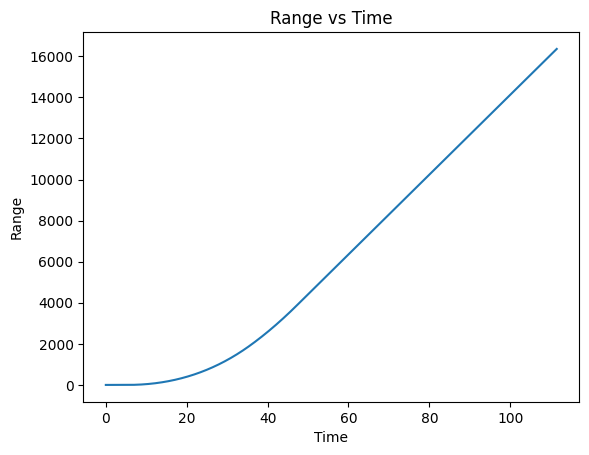

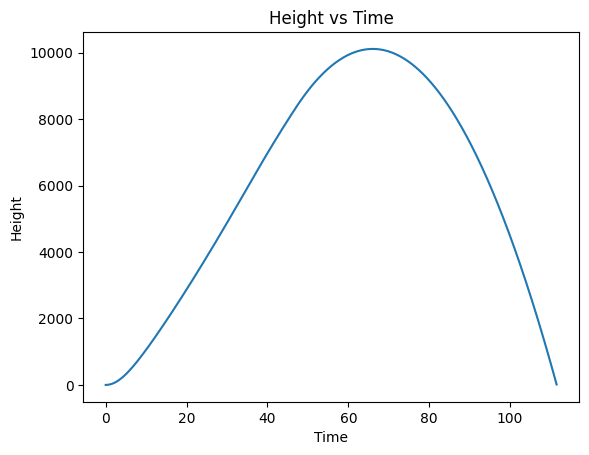

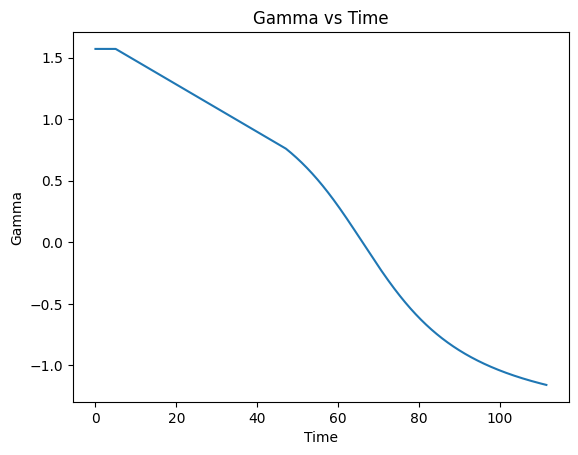

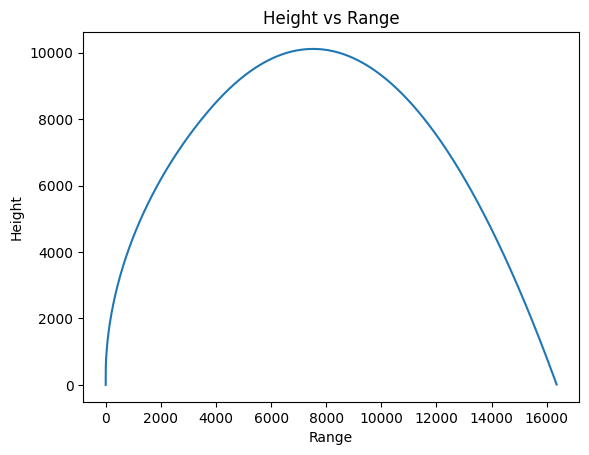

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 1753.3626868969052
Isp0: 654.0546234860467
payload: 943.6843773018301
missilediam: 4.009030575559029
drymass: 1433.659173769287
thrust0: 47775.27454514784


Stage 1 burnout
Velocity (km/s):  0.8897725269863743
Angle (deg h):  43.66042275804455
Range (km):  4.86198062148791
Time (sec):  24.000000000000075
Final results: 
Range (km):  96.31148950199682
Apogee (km):  30.354456356893117
Time to target (sec):  166.7999999999948




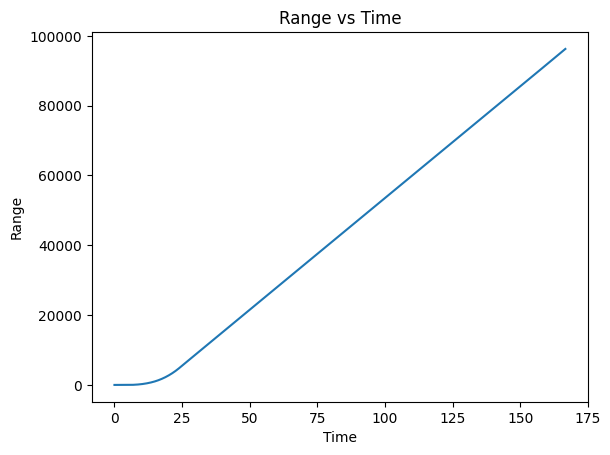

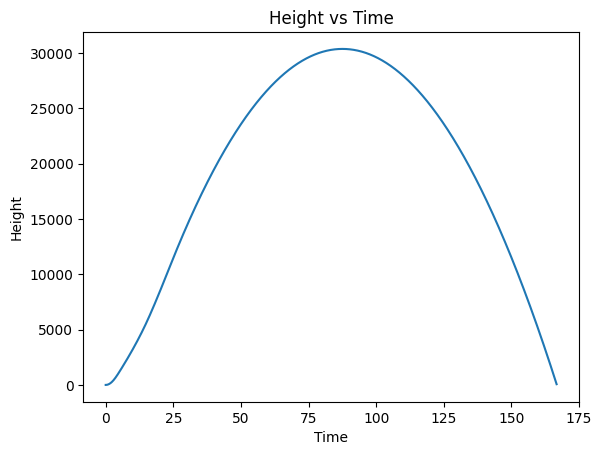

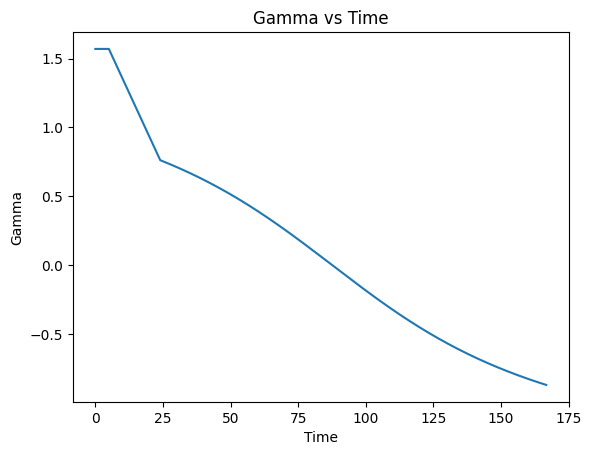

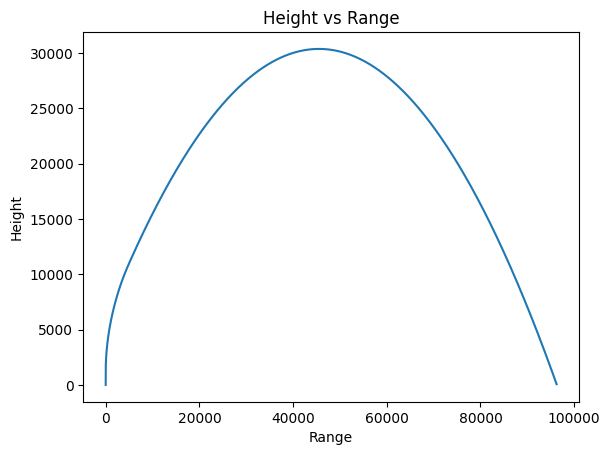

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 994.0703749280174
Isp0: 619.5897947673135
payload: 826.8543411163788
missilediam: 9.07188753213895
drymass: 1723.1738683375036
thrust0: 56754.153354389055


Stage 1 burnout
Velocity (km/s):  0.29641456751655876
Angle (deg h):  43.928547940679785
Range (km):  0.6665272769874891
Time (sec):  10.899999999999979
Final results: 
Range (km):  11.823667022713815
Apogee (km):  4.783501047894499
Time to target (sec):  63.20000000000063




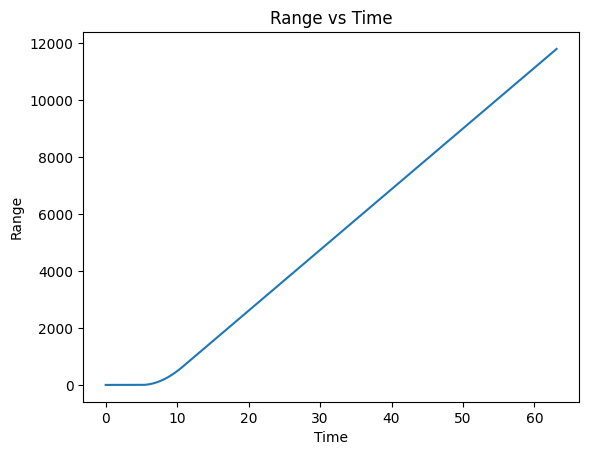

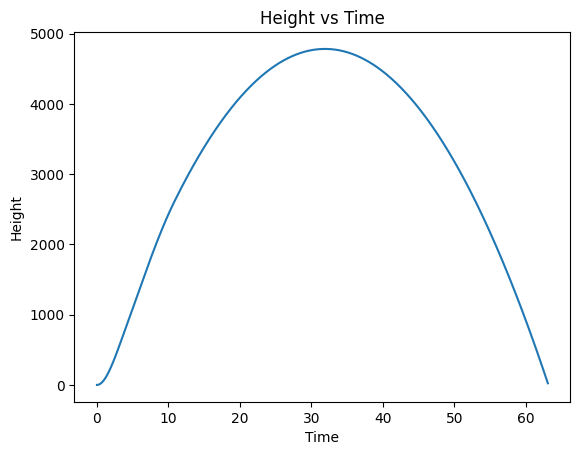

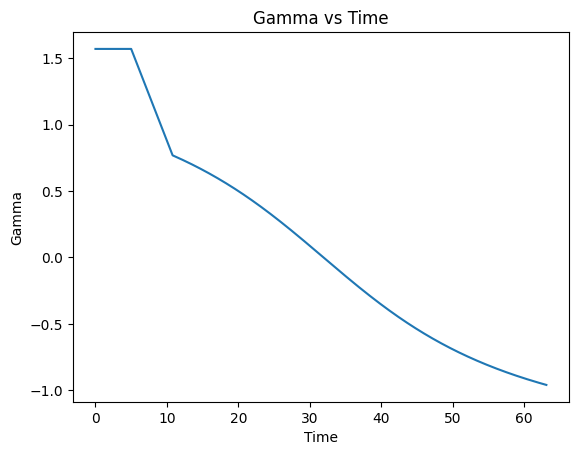

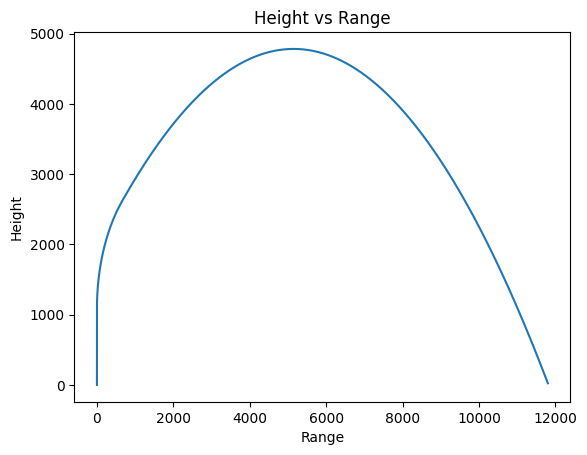

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 6613.181195181844
Isp0: 362.7727934463984
payload: 540.1827192977782
missilediam: 4.22685603763371
drymass: 1121.8410104323127
thrust0: 59116.14551449726


Stage 1 burnout
Velocity (km/s):  2.6201063451446034
Angle (deg h):  43.74454290441227
Range (km):  16.93479227166197
Time (sec):  40.60000000000031
Final results: 
Range (km):  791.1756611955136
Apogee (km):  213.4857803157192
Time to target (sec):  466.7000000000376




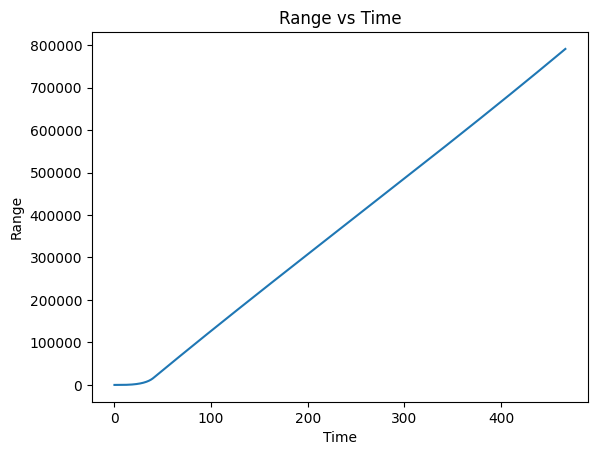

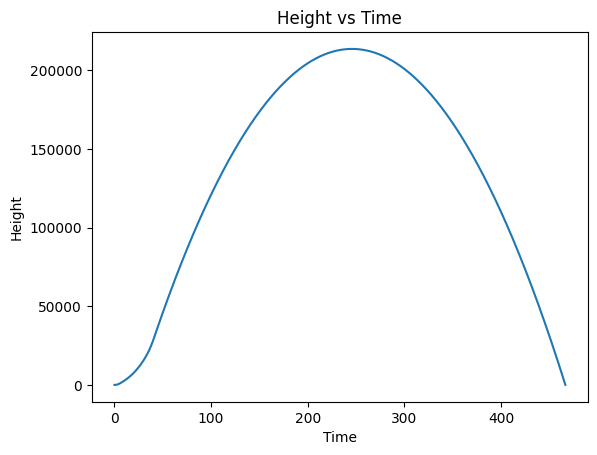

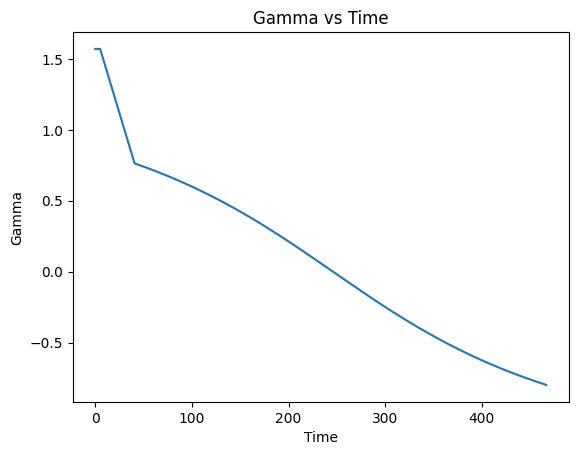

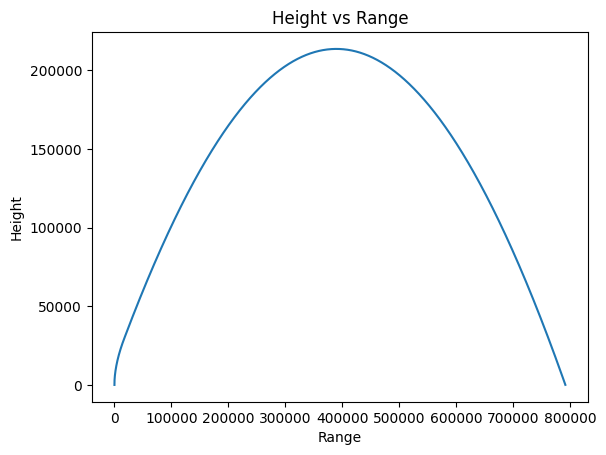

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5667.411321091586
Isp0: 177.4235131701825
payload: 2271.69325769168
missilediam: 6.3053319784819335
drymass: 1949.6457922887917
thrust0: 68224.23947784308


Stage 1 burnout
Velocity (km/s):  0.37421410041479336
Angle (deg h):  43.726254476596154
Range (km):  1.360828484612063
Time (sec):  14.799999999999965
Final results: 
Range (km):  18.89261616781961
Apogee (km):  7.203209751797697
Time to target (sec):  79.69999999999975




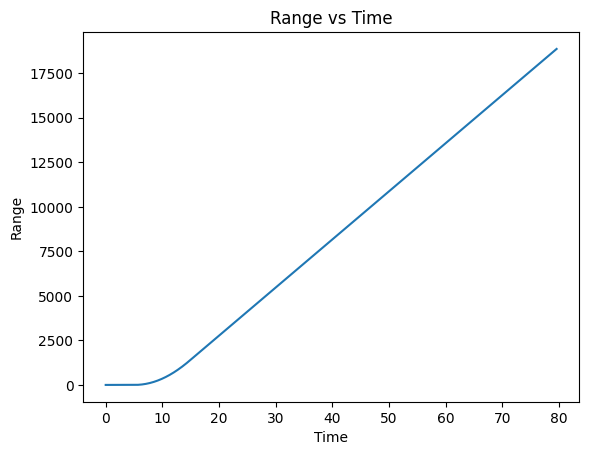

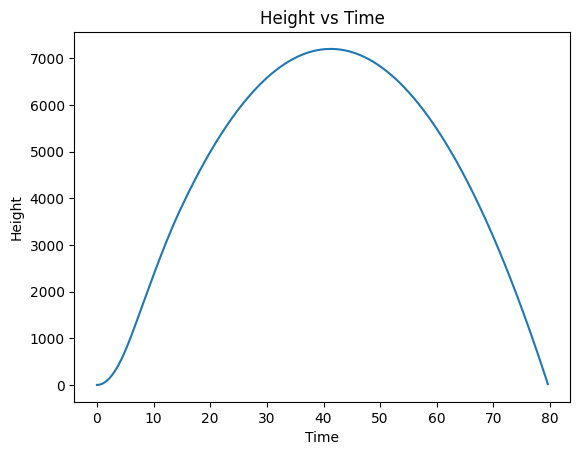

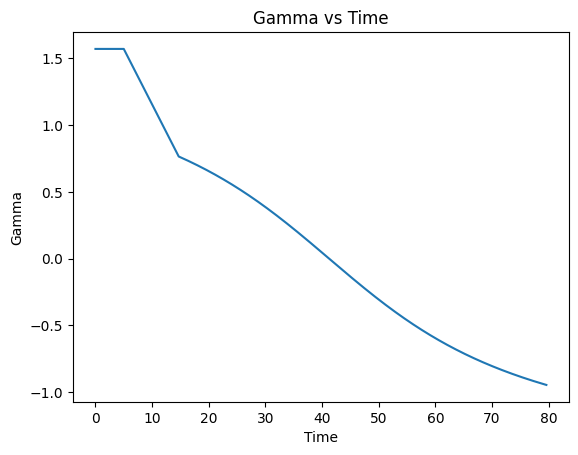

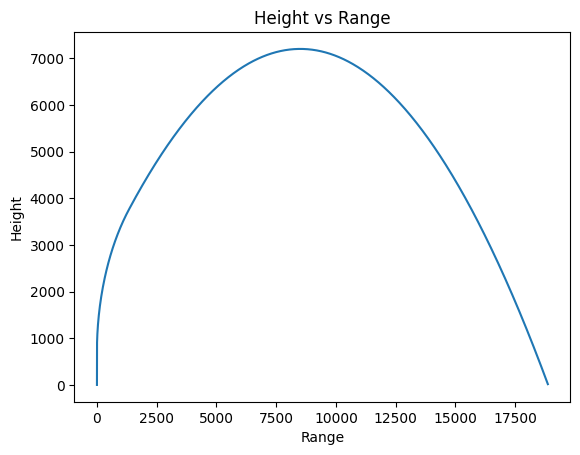

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5338.322586512017
Isp0: 198.44431715051195
payload: 203.51730743159257
missilediam: 0.12027789668128419
drymass: 2009.3223448010576
thrust0: 54395.9342215594


Stage 1 burnout
Velocity (km/s):  2.2286871880500594
Angle (deg h):  43.874101520327194
Range (km):  7.764820059989793
Time (sec):  19.50000000000001
Final results: 
Range (km):  551.3585203617878
Apogee (km):  144.54213016976266
Time to target (sec):  367.6000000000151




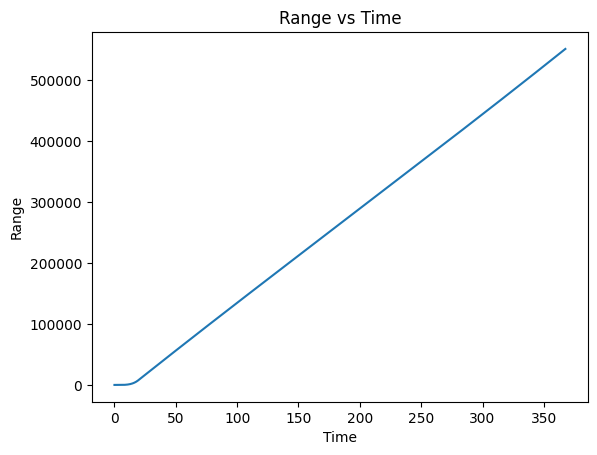

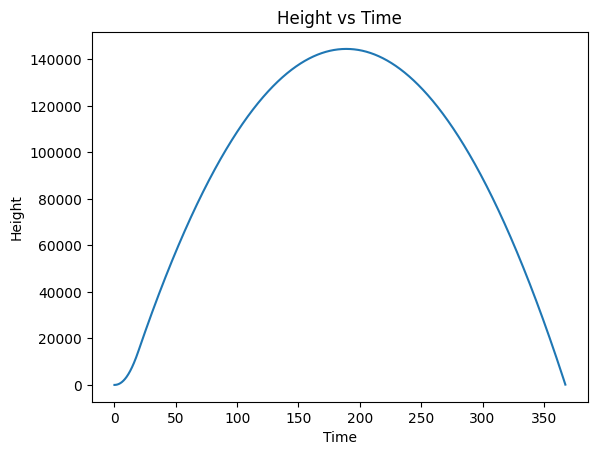

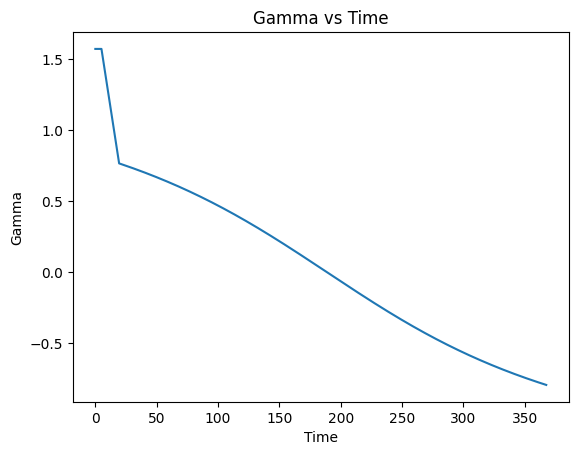

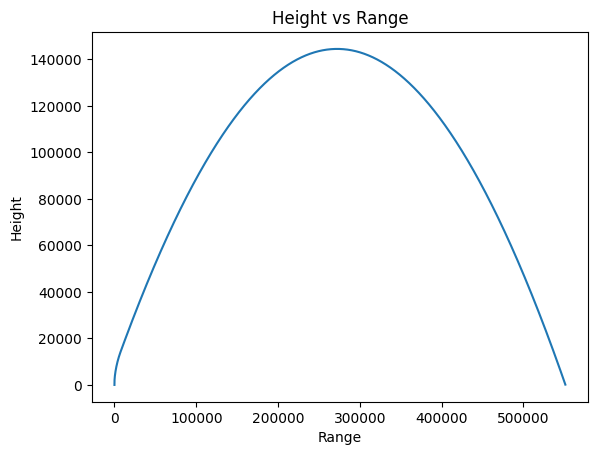

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 1243.0549890721413
Isp0: 449.0096154819059
payload: 641.6943953644823
missilediam: 9.06171198542229
drymass: 1783.2742139923714
thrust0: 39433.860389764304


Stage 1 burnout
Velocity (km/s):  0.27617791173052086
Angle (deg h):  43.77693841505437
Range (km):  0.9594546694413071
Time (sec):  14.199999999999967
Final results: 
Range (km):  11.162466447091417
Apogee (km):  4.885029734395253
Time to target (sec):  65.40000000000056




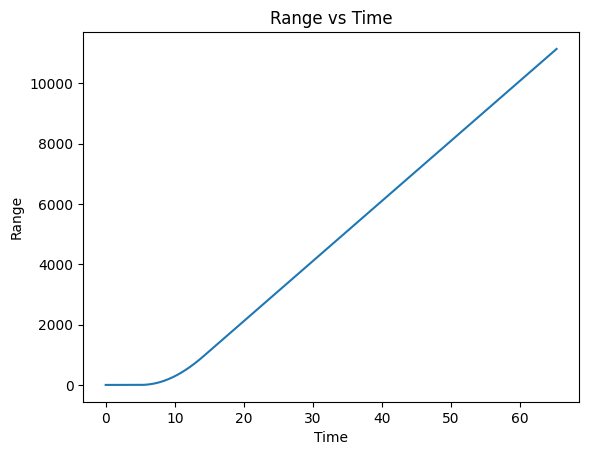

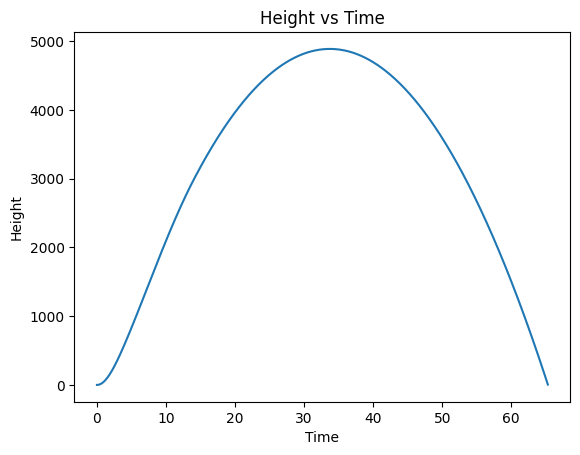

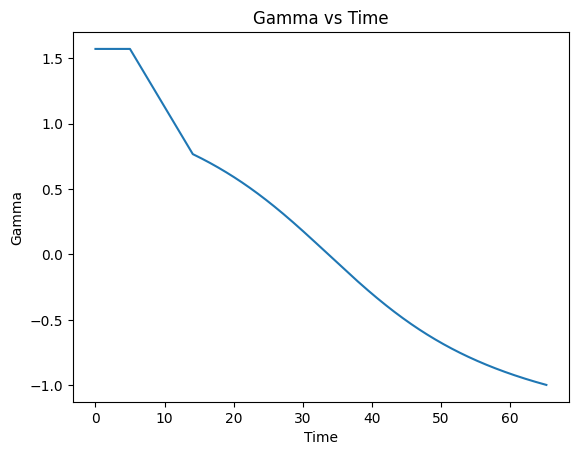

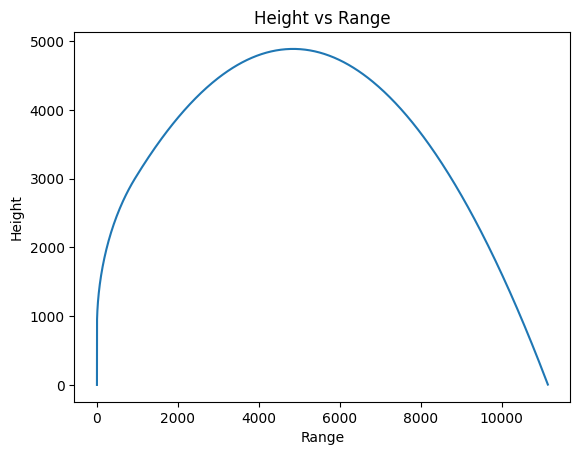

Data written to 'results/results_0.txt'


In [103]:
# Bayesian optimization using emulator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

m3_2_model_emukit = m3_model_emukit

maxim_aquisition = ExpectedImprovement(model=m3_model_emukit)


bayesopt_loop = BayesianOptimizationLoop(model = m3_2_model_emukit,
                                         space = m3_space,
                                         acquisition = maxim_aquisition,
                                         batch_size = 1)

max_iterations = 30
# def neg_run_missile_sim(custom_params):
#     return -run_missile_sim(custom_params)

bayesopt_loop.run_loop(run_missile_sim, max_iterations) # I'm afraid this minimizes
# bayesopt_loop.run_loop(neg_run_missile_sim, max_iterations) # Not sure if enough



In [104]:
results = bayesopt_loop.get_results()
results

In [105]:
results.__dict__

{'minimum_location': array([5.57776525e+03, 7.51164425e+02, 1.88316521e+03, 7.18689686e+00,
        1.61670306e+03, 2.62325238e+04]),
 'minimum_value': -2310.856837889455,
 'best_found_value_per_iteration': array([-1587.57731589, -2310.85683789, -2310.85683789, -2310.85683789,
        -2310.85683789, -2310.85683789, -2310.85683789, -2310.85683789,
        -2310.85683789, -2310.85683789, -2310.85683789, -2310.85683789,
        -2310.85683789, -2310.85683789, -2310.85683789, -2310.85683789,
        -2310.85683789, -2310.85683789, -2310.85683789, -2310.85683789,
        -2310.85683789, -2310.85683789, -2310.85683789, -2310.85683789,
        -2310.85683789, -2310.85683789, -2310.85683789, -2310.85683789,
        -2310.85683789, -2310.85683789, -2310.85683789, -2310.85683789,
        -2310.85683789, -2310.85683789, -2310.85683789])}

## Sensitivity Analysis

### 1. On the simulator

### 2. On the emulator

In [ ]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [ ]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [ ]:
import pandas as pd


In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='first-order-sobol-indices-gp-catapult.svg', directory='./uq')


In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='total-effects-sobol-indices-gp-catapult.svg', directory='./uq')